## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- **Train.csv** - To be used for training and tuning of models.
- **Test.csv** - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Import Core Libraries

In [ ]:
# Installing the libraries with the specified version. I needed to install these individually vs. as a single line to avoid errors.
#!pip install pandas==1.5.3 -q --user #done
#!pip install numpy==1.25.2 -q --user #done
#!pip install matplotlib==3.7.1 -q --user #done
#!pip install seaborn==0.13.1 -q --user #done
#!pip install scikit-learn==1.2.2 -q --user #done
#!pip install imbalanced-learn==0.10.1 -q --user #done
#!pip install xgboost==2.0.3 -q --user #done
#!pip install threadpoolctl==3.3.0 -q --user #done

In [ ]:
# Import libraries we need to do our work

# Read and manipulate data
import numpy as np
import pandas as pd

# HTML styling
from IPython.display import display, HTML

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import shapiro

# Model tuning and metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# Impute missing values
from sklearn.impute import SimpleImputer

# Build logistic regression model
from sklearn.linear_model import LogisticRegression

# Over/under sample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Loading the dataset

In [ ]:
# Load Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define path to data file
path = r'/content/drive/MyDrive/Learning/Data Coursework/PGP-DSBA/6-Model Tuning/Project 6/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

## Data Overview

- Observations
- Sanity checks

In [ ]:
print('Training dataset has', df_train.shape[0], 'rows and', df_train.shape[1], 'columns')

Training dataset has 20000 rows and 41 columns


In [ ]:
print('Test dataset has', df_test.shape[0], 'rows and', df_test.shape[1], 'columns')

Test dataset has 5000 rows and 41 columns


In [ ]:
# Here, we will want to combine the datasets first into our EDA dataframe
df_eda = pd.concat([df_train, df_test], axis=0).reset_index()

In [ ]:
# View information
print('Training')
display(df_eda.info())

Training
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   25000 non-null  int64  
 1   V1      24977 non-null  float64
 2   V2      24976 non-null  float64
 3   V3      25000 non-null  float64
 4   V4      25000 non-null  float64
 5   V5      25000 non-null  float64
 6   V6      25000 non-null  float64
 7   V7      25000 non-null  float64
 8   V8      25000 non-null  float64
 9   V9      25000 non-null  float64
 10  V10     25000 non-null  float64
 11  V11     25000 non-null  float64
 12  V12     25000 non-null  float64
 13  V13     25000 non-null  float64
 14  V14     25000 non-null  float64
 15  V15     25000 non-null  float64
 16  V16     25000 non-null  float64
 17  V17     25000 non-null  float64
 18  V18     25000 non-null  float64
 19  V19     25000 non-null  float64
 20  V20     25000 non-null  float64
 21  V21     25000 non-null  fl

None

In [ ]:
# Describe the data. Can also use include=all to also show categorical series.
df_eda.describe(include='all').T

count         mean          std        min          25%  \
index   25000.0  8499.500000  6007.060566   0.000000  3124.750000   
V1      24977.0    -0.273121     3.446501 -12.381696    -2.738531   
V2      24976.0     0.431931     3.148527 -12.319951    -1.642559   
V3      25000.0     2.498117     3.376625 -10.708139     0.226105   
V4      25000.0    -0.076310     3.428030 -15.082052    -2.338280   
V5      25000.0    -0.059025     2.106000  -8.603361    -1.548581   
V6      25000.0    -1.004782     2.033960 -10.227147    -2.351804   
V7      25000.0    -0.885044     1.763109  -8.124230    -2.035858   
V8      25000.0    -0.553475     3.302968 -15.657561    -2.642665   
V9      25000.0    -0.007422     2.163327  -8.596313    -1.485926   
V10     25000.0    -0.006693     2.183726  -9.853957    -1.400021   
V11     25000.0    -1.918038     3.122172 -14.832058    -3.945890   
V12     25000.0     1.599143     2.925822 -12.948007    -0.408998   
V13     25000.0     1.588880     2.876298 -13.228247    -0.208349   
V14     25000.0    -0.944725     1.792426  -7.813929    -2.159781   
V15     25000.0    -2.422429     3.361377 -16.416606    -4.432551   
V16     25000.0    -2.943880     4.230368 -20.985779    -5.639162   
V17     25000.0    -0.128153     3.343630 -14.091184    -2.217008   
V18     25000.0     1.190599     2.591052 -12.214016    -0.404954   
V19     25000.0     1.187544     3.394428 -14.169635    -1.045095   
V20     25000.0     0.046572     3.667234 -13.922659    -2.413293   
V21     25000.0    -3.621881     3.569714 -17.956231    -5.933420   
V22     25000.0     0.953860     1.649298 -10.122095    -0.103713   
V23     25000.0    -0.377329     4.036824 -14.866128    -3.112878   
V24     25000.0     1.125279     3.923323 -16.387147    -1.497698   
V25     25000.0     0.010498     2.015558  -8.228266    -1.352614   
V26     25000.0     1.868480     3.428152 -11.834271    -0.322190   
V27     25000.0    -0.600410     4.375666 -14.904939    -3.653682   
V28     25000.0    -0.880110     1.919381  -9.269489    -2.168125   
V29     25000.0    -1.007661     2.678917 -12.579469    -2.799879   
V30     25000.0    -0.036167     3.009096 -14.796047    -1.895801   
V31     25000.0     0.483236     3.458316 -13.722760    -1.818319   
V32     25000.0     0.289553     5.517512 -19.876502    -3.444129   
V33     25000.0     0.023837     3.568291 -16.898353    -2.260302   
V34     25000.0    -0.448694     3.180361 -17.985094    -2.110809   
V35     25000.0     2.225937     2.939321 -15.349803     0.334812   
V36     25000.0     1.530816     3.795756 -14.833178    -0.929834   
V37     25000.0     0.013639     1.787566  -5.478350    -1.252857   
V38     25000.0    -0.356352     3.952311 -17.375002    -2.987116   
V39     25000.0     0.900282     1.745877  -6.438880    -0.259414   
V40     25000.0    -0.886985     3.005419 -11.023935    -2.950211   
Target  25000.0     0.055680     0.229307   0.000000     0.000000   

                50%           75%           max  
index   7499.500000  13749.250000  19999.000000  
V1        -0.749797      1.838215     15.493002  
V2         0.464706      2.527319     14.079073  
V3         2.256621      4.570447     17.090919  
V4        -0.137410      2.135586     13.236381  
V5        -0.107352      1.340579      8.133797  
V6        -1.006251      0.365115      6.975847  
V7        -0.920190      0.222579      8.006091  
V8        -0.382091      1.721018     11.679495  
V9        -0.070398      1.420234      8.850720  
V10        0.110723      1.483866      8.108472  
V11       -1.944540      0.102854     11.826433  
V12        1.502393      3.570925     15.080698  
V13        1.652288      3.460339     15.419616  
V14       -0.946795      0.270961      5.734112  
V15       -2.390213     -0.376356     12.246455  
V16       -2.700040     -0.115004     13.975843  
V17       -0.007411      2.075780     19.776592  
V18        0.882952      2.578819     13.642235  
V19        1.281696      3.499366     13.2

In [ ]:
# Retrieve and preview the categorial column values, using a list.

# Create numerical and categorical column lists
list_catcol = df_eda.select_dtypes(include=['object']).columns.to_list()
list_numcol = df_eda.select_dtypes(exclude=['object']).columns.to_list()

print('Dataset has', len(list_catcol), 'categorical columns and', len(list_numcol), 'numerical columns.')

# Use a for loop to show the counts and percent contribution of each categorical column.
for col in list_catcol:
  print(f'***** {col} *****')
  print('Preview counts for:',df_eda[col].value_counts(),'\n')
  print('Preview % breakdown for:',df_eda[col].value_counts(normalize=True),'\n')

Dataset has 0 categorical columns and 42 numerical columns.


In [ ]:
# Check counts, unique counts and duplicate values for each column. Based on this, we can decide how to approach each variable.
for col in df_eda:
  unique_count = df_eda[col].nunique()
  duplicate_count = df_eda[col].count()-df_eda[col].nunique()
  empty_count = df_eda[col].isnull().sum().sum()
  print(f'Series {col} has {unique_count} unique values, {duplicate_count} duplicate values, and {empty_count} missing values.')

Series index has 20000 unique values, 5000 duplicate values, and 0 missing values.
Series V1 has 24977 unique values, 0 duplicate values, and 23 missing values.
Series V2 has 24976 unique values, 0 duplicate values, and 24 missing values.
Series V3 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V4 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V5 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V6 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V7 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V8 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V9 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V10 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V11 has 25000 unique values, 0 duplicate values, and 0 missing values.
Series V12 has 25000 unique values, 0 duplicate values, and 0 miss

In [ ]:
# Check for null values
print(f'EDA dataset has {df_eda.isnull().sum().sum()} null values:',)

# Replace any missing values with NaNs
df_eda = df_eda.replace("?", np.nan)

# Count NaN values
nan_count = df_eda.isnull().sum().sum()

if nan_count > 0:
    print(f"EDA DataFrame has {nan_count} NaN values.")
else:
    print("EDA DataFrame does not have NaN values.")

EDA dataset has 47 null values:
EDA DataFrame has 47 NaN values.


In [ ]:
# Check for duplicate column names
print(df_eda.columns[df_eda.columns.duplicated()])

Index([], dtype='object')


In [ ]:
# Preview rows with missing data
df_eda[df_eda.isnull().any(axis=1)]

index        V1        V2        V3        V4        V5        V6  \
89        89       NaN -3.961403  2.787804 -4.712526 -3.007329 -1.541245   
613      613 -2.048681       NaN -1.623885 -3.324224  0.152256  0.600157   
2236    2236 -3.760658       NaN  0.194954 -1.637958  1.261479 -1.573947   
2508    2508 -1.430888       NaN  0.659576 -2.876402  1.150137 -0.785760   
4653    4653  5.465769       NaN  4.540947 -2.916550  0.399752  2.798925   
5941    5941       NaN  1.008391  1.227702  5.397082  0.064230 -2.706919   
6317    6317       NaN -5.205346  1.997652 -3.707913 -1.042200 -1.593126   
6464    6464       NaN  2.146202  5.004415  4.192063  1.427887 -6.438263   
6810    6810 -2.631454       NaN  2.330188  1.090080  0.603973 -1.139383   
7073    7073       NaN  2.534010  2.762821 -1.673718 -1.942214 -0.029961   
7788    7788 -4.203459       NaN  2.953868  0.584466  4.103940 -0.639211   
8431    8431       NaN -1.398710 -2.008106 -1.750341  0.932279 -1.290327   
8439    8439       NaN -3.840585  0.197220  4.147789  1.151400 -0.993298   
8483    8483 -4.484232       NaN  1.200644 -2.042064  2.779443 -0.801748   
8894    8894  3.263555       NaN  8.446574 -3.253218 -3.417978 -2.995838   
8947    8947 -3.793170       NaN  0.719610  2.306296  0.934728 -0.984321   
9362    9362  2.662045       NaN  2.980068  4.430762 -0.237769  0.671919   
9425    9425 -2.354134       NaN  2.053893  0.811660  2.540366 -0.924875   
9848    9848 -1.763501       NaN  2.845012 -2.753083 -0.811848 -0.101166   
11156  11156       NaN -0.666978  3.715829  4.934000  1.667596 -4.356097   
11287  11287       NaN -2.561519 -0.180836 -7.194814 -1.043832  1.384845   
11456  11456       NaN  1.299595  4.382858  1.583219 -0.076564  0.658770   
11637  11637 -2.270541       NaN  1.710061  1.157522 -0.355177 -5.449480   
12221  12221       NaN -2.326319 -0.051978  0.615063 -0.895755 -2.437003   
12339  12339 -1.663687       NaN -0.712286 -4.346935  1.391670 -0.093951   
12447  12447       NaN  0.752613 -0.271099  1.301204  2.038697 -1.485203   
13086  13086       NaN  2.056243  3.330642  2.741497  2.783166 -0.444191   
13411  13411       NaN  2.704511  4.587169  1.867930  2.050133 -0.925076   
14202  14202       NaN  7.038653  2.144536 -3.201788  4.112972  3.375972   
15520  15520       NaN  1.382556  3.236896 -3.818363 -1.917264  0.437686   
15913  15913  0.768122       NaN  5.296110  0.043018 -1.173729 -2.248575   
16576  16576       NaN  3.933815 -0.761930  2.651889  1.753614 -0.554092   
18104  18104       NaN  1.492173  2.659206  0.222784 -0.303648 -1.347322   
18342  18342 -0.928572       NaN  2.375506 -1.236914  3.228744 -2.100088   
18343  18343 -2.377369       NaN -0.009173 -1.471979  1.295482  0.724894   
18907  18907 -0.119181       NaN  3.657612 -1.231802  1.946873 -0.119089   
20709    709  3.171300       NaN -0.899604 -7.687193 -1.844379  2.229502   
20859    859       NaN  1.481190  2.208128 -2.550029  1.526045 -0.964918   
21070   1070       NaN  1.222743  7.023517 -1.227970 -3.385548 -1.500321   
21639   1639       NaN -5.280584  1.695313 -0.787160 -1.872912 -0.469312   
21777   1777  1.255877       NaN  1.123121  0.347719 -0.199314  0.542522   
21832   1832       NaN -0.558554  5.315575  1.517019 -2.304035 -1.410233   
21869   1869 -1.272832       NaN  4.426359 -3.013970 -1.294693 -0.883173   
22741   2741 -2.938927       NaN  2.913242  1.431121  4.003345 -4.743048   
23266   3266  5.896134       NaN  7.342806 -1.052112 -1.393952 -0.410402   
24051   4051       NaN  3.983783  0.524783 -4.776552  2.590121  1.040410   
24186   4186  5.034513       NaN  4.450708 -6.077425  0.445417  2.491588   

             V7        V8        V9  ...        V32       V33        V34  \
89    -0.881148  1.476656  0.574700  ...  -8.326069 -5.140552   1.121314   
613   -1.812802  0.852194 -1.522600  ...   3.264218  2.379064  -2.457084   
2236  -3.685700  1.575651 -0.309823  ...   7.620821  1.695061  -3.956354   
2508  -1.560174  2.898635 -2.346989  ...   6.279266  3

In [ ]:
# Preview the data
display(df_eda.head())

index        V1        V2        V3        V4        V5        V6  \
0      0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511   
1      1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938   
2      2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824   
3      3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780   
4      4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960   

         V7        V8        V9  ...       V32       V33        V34       V35  \
0 -2.910870  0.050714 -1.522351  ...  3.059700 -1.690440   2.846296  2.235198   
1  0.732600 -4.332135  0.565695  ... -1.795474  3.032780  -2.467514  1.894599   
2 -2.098941 -3.173204 -2.081860  ... -0.257101  0.803550   4.086219  2.292138   
3  0.207309 -2.493629  0.344926  ... -3.584425 -2.577474   1.363769  0.622714   
4  0.205433  4.848994 -1.854920  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 42 columns]

Out of 25,000 rows of data, 47 of them have NaN values (missing data).
Since we do not have any business context for these values, but we know they're all numerical, we can use the median to ensure we impute values that lie within the 50% quartile.

In [ ]:
# Fill in NaNs for the purpose of our EDA analysis
df_eda = df_eda.fillna(df_eda.median())

# Recheck for null values
print(f'EDA dataset has {df_eda.isnull().sum().sum()} null values:',)

EDA dataset has 0 null values:


In [ ]:
# Recheck data types
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   25000 non-null  int64  
 1   V1      25000 non-null  float64
 2   V2      25000 non-null  float64
 3   V3      25000 non-null  float64
 4   V4      25000 non-null  float64
 5   V5      25000 non-null  float64
 6   V6      25000 non-null  float64
 7   V7      25000 non-null  float64
 8   V8      25000 non-null  float64
 9   V9      25000 non-null  float64
 10  V10     25000 non-null  float64
 11  V11     25000 non-null  float64
 12  V12     25000 non-null  float64
 13  V13     25000 non-null  float64
 14  V14     25000 non-null  float64
 15  V15     25000 non-null  float64
 16  V16     25000 non-null  float64
 17  V17     25000 non-null  float64
 18  V18     25000 non-null  float64
 19  V19     25000 non-null  float64
 20  V20     25000 non-null  float64
 21  V21     25000 non-null  float64
 22

## Exploratory Data Analysis (EDA)

####EDA Helpers

In [ ]:
# Function to plot a boxplot and a histogram on same scale

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
  '''
  Boxplot and histogram combined

  data: dataframe
  feature: dataframe column
  figsize: size of figure (default (12,7))
  kde: whether to the show density curve (default False)
  bins: number of bins for histogram (default None)
  '''
  # Create a figure with two subplots
  f2, (ax_box2, ax_hist2) = plt.subplots(
      nrows=2,  # Number of rows of the subplot grid
      sharex=True,  # x-axis will be shared among all subplots
      gridspec_kw={'height_ratios': (0.25, 0.75)},  # Ratio of subplot heights
      figsize=figsize,  # Size of the figure
  )

  # Boxplot
  sns.boxplot(
      data=data, x=feature, ax=ax_box2, showmeans=True, color='blue'
  )
  ax_box2.set_title(f'Boxplot of {feature}')  # Title for the boxplot

  # Histogram
  if bins:
      sns.histplot(
          data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette='winter'
      )
  else:
      sns.histplot(
          data=data, x=feature, kde=kde, ax=ax_hist2
      )

  ax_hist2.axvline(
      data[feature].mean(), color='green', linestyle="--", label='Mean'
  )
  ax_hist2.axvline(
      data[feature].median(), color='black', linestyle="-", label='Median'
  )
  ax_hist2.set_title(f'Histogram of {feature}')  # Title for the histogram
  ax_hist2.legend()  # Add legend to the histogram plot

  # Adjust layout
  plt.tight_layout()
  plt.show()


In [ ]:
def calculate_z_scores(values, mean, std_dev):
  '''
  Function to calculate z-score
  '''
  values_array = np.array(values)

  if std_dev == 0:
      raise ValueError("Standard deviation is zero; cannot calculate z-scores.")
  z_scores = (values_array - mean) / std_dev

  return z_scores

In [ ]:
# Function to print the statistics for each feature

def print_feature_statistics(data, feature):
  '''
  Show the statistics of a feature.

  data: dataframe
  feature: dataframe column
  '''

  # Chart high-level assessment for each numerical series
  mean = data[feature].mean()
  median = data[feature].median()
  min = data[feature].min()
  max = data[feature].max()
  mode = data[feature].mode()
  std_dev = data[feature].std()
  variance = data[feature].var()
  this_range = max-min
  this_avg_z_score = np.mean(calculate_z_scores(data[feature], mean, std_dev))

  print('\n')
  print(f'***** {feature} *****')
  print(f' * Mean =', mean)
  print(f' * Median =' , median)
  print(f' * Min =' , min)
  print(f' * Max =' , max)
  print(f' * Range =', min, 'to' , max,'(', round(this_range,3), ')')

  if not mode.empty:
      print(f' * Mode =', mode.iloc[0])  # Print only the first mode
  else:
      print(f' * Mode = No mode')
  print(f' * Standard Deviation =', std_dev)
  print(f' * Variance =', variance)

  if(this_avg_z_score <= -2 or this_avg_z_score >= 2):
    print(f' * Not a normal distribution.', end='')
  else:
    print(f' * Normal distribution.', end='')

  # Calculate Shapiro-Wilks to test normal distribution
  stat, p = shapiro(data[feature])
  print(f'\n * Shapiro test statistic:', stat , end='')
  print(f'\n * P-value:', p, end='')

  if(p <= .05):
    print(f'\n * Has statistical significance.', end='')
  else:
    print(f'\n * Does not have statistical significance.', end='')

### Univariate Analysis

In [ ]:
# Analyze critical statistics
for feature in df_eda.columns:
    print_feature_statistics(df_eda, feature)



***** index *****
 * Mean = 8499.5
 * Median = 7499.5
 * Min = 0
 * Max = 19999
 * Range = 0 to 19999 ( 19999 )
 * Mode = 0
 * Standard Deviation = 6007.060565789698
 * Variance = 36084776.64106564
 * Normal distribution.
 * Shapiro test statistic: 0.9267368219914156
 * P-value: 1.0927088805999006e-74
 * Has statistical significance.

***** V1 *****
 * Mean = -0.27355985398908006
 * Median = -0.749796735
 * Min = -12.38169567
 * Max = 15.49300222
 * Range = -12.38169567 to 15.49300222 ( 27.875 )
 * Mode = -0.749796735
 * Standard Deviation = 3.4449451048104507
 * Variance = 11.867646775157487
 * Normal distribution.
 * Shapiro test statistic: 0.9801293012964551
 * P-value: 4.591698125099776e-49
 * Has statistical significance.

***** V2 *****
 * Mean = 0.43196290092623996
 * Median = 0.4647059405
 * Min = -12.31995112
 * Max = 14.07907276
 * Range = -12.31995112 to 14.07907276 ( 26.399 )
 * Mode = 0.4647059405
 * Standard Deviation = 3.147015023135167
 * Variance = 9.903703555838435


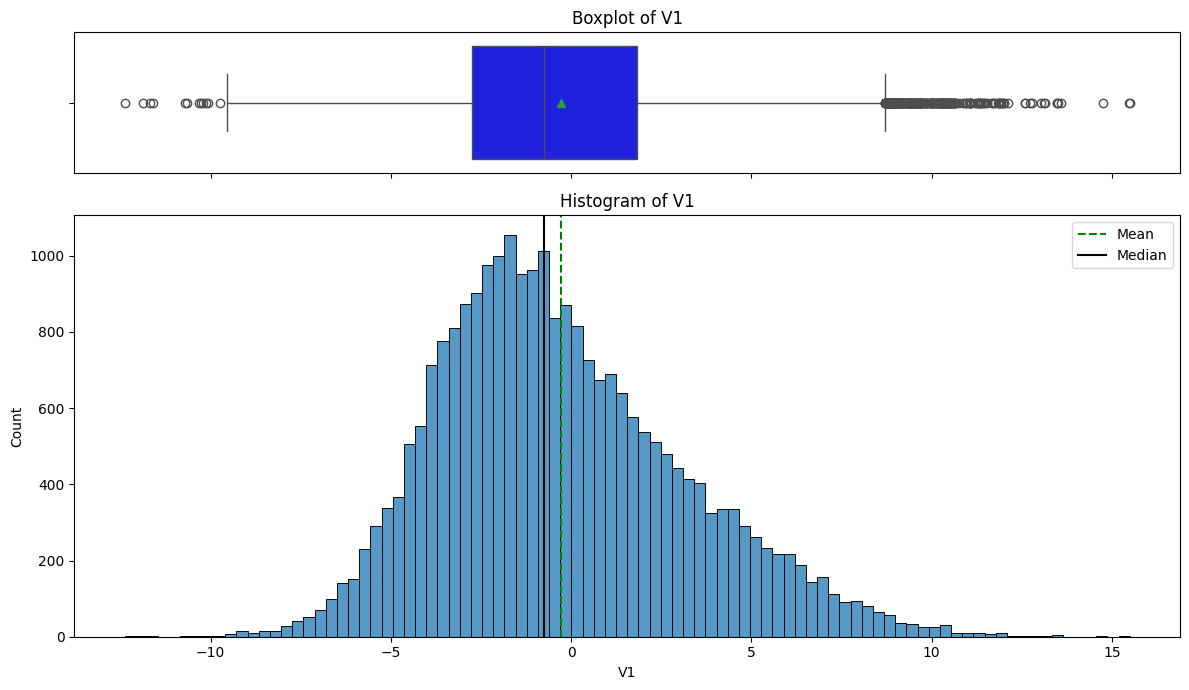

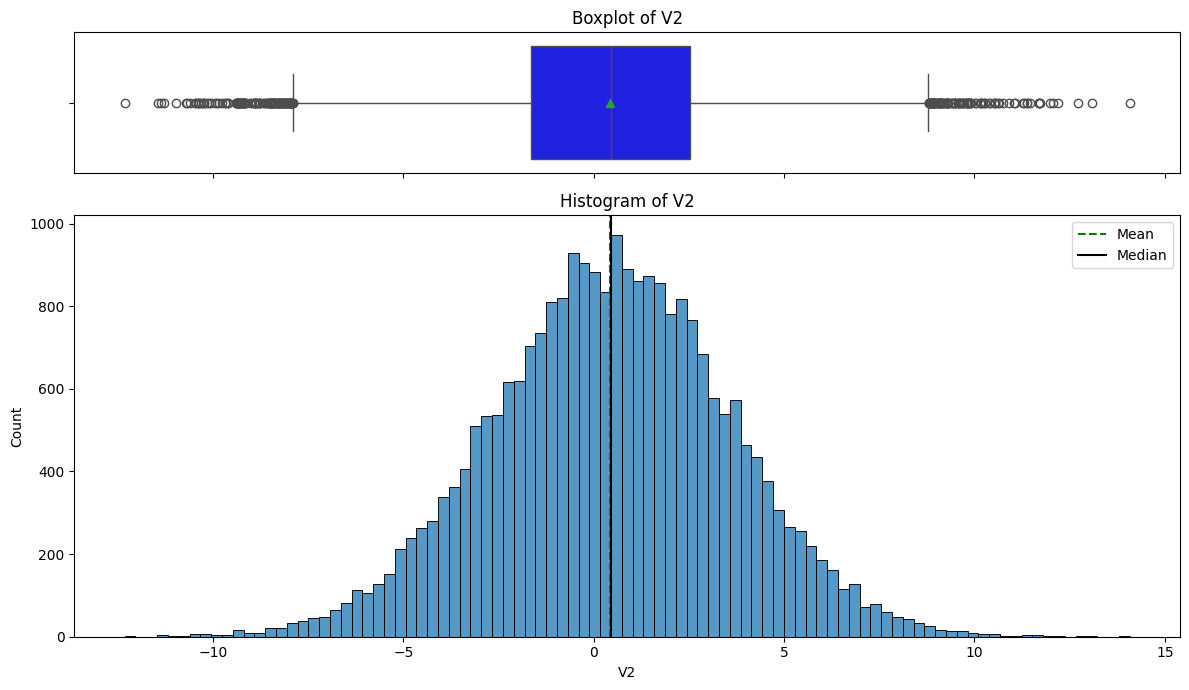

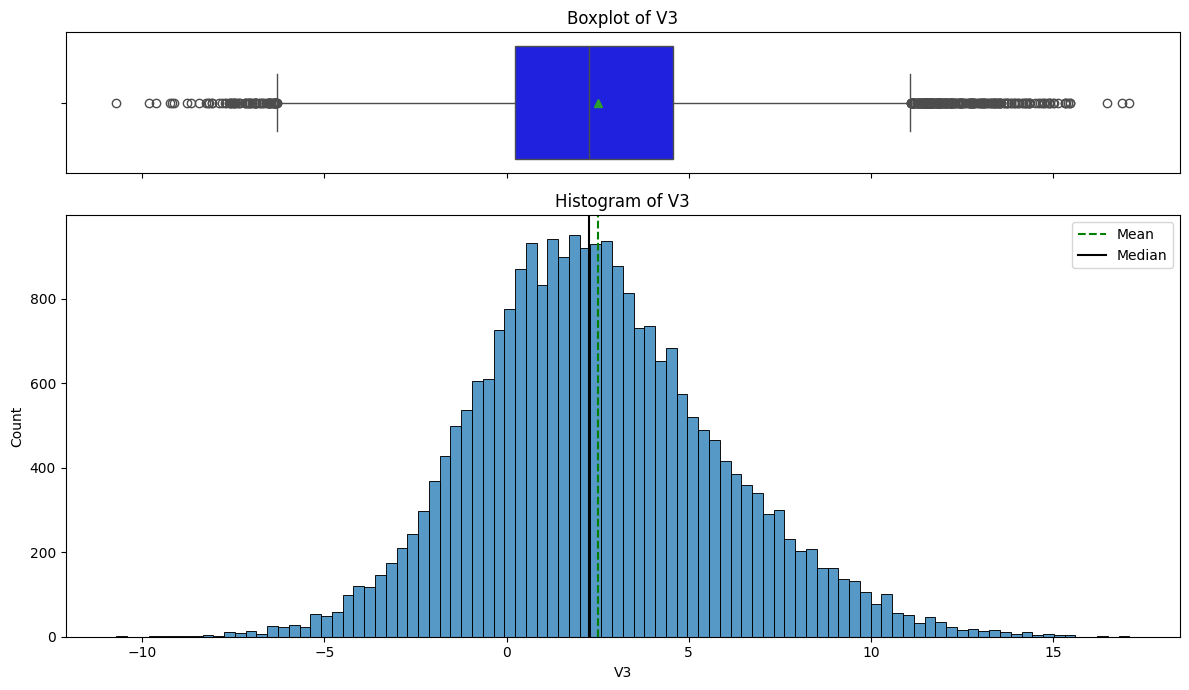

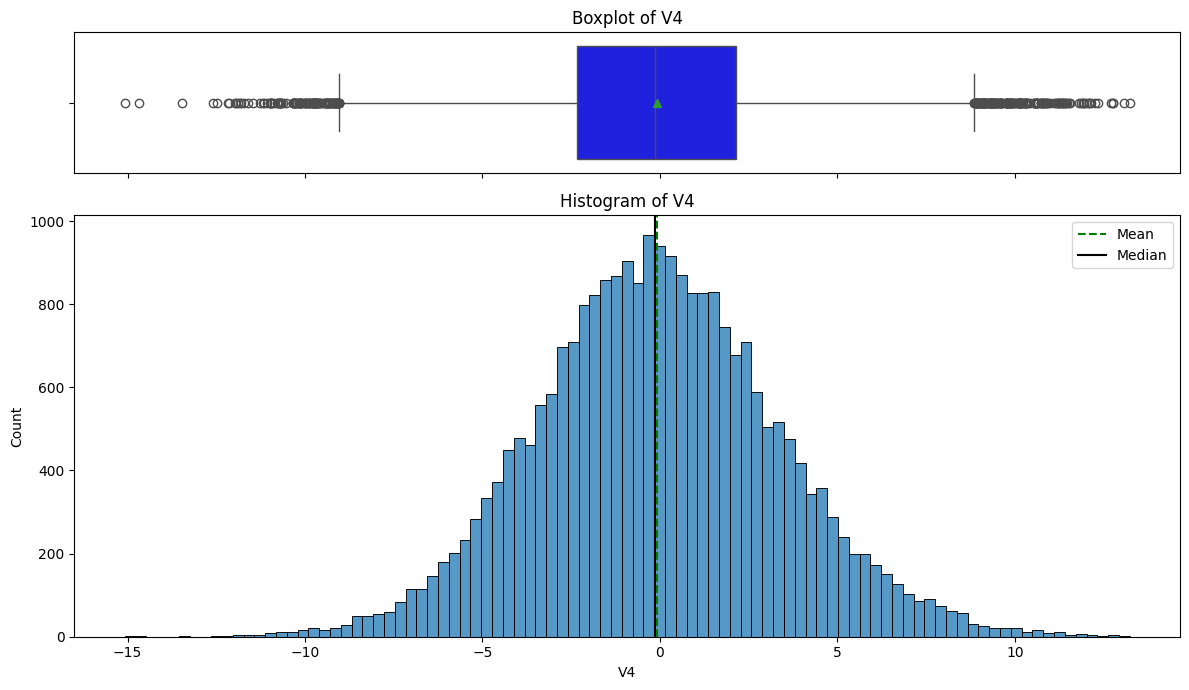

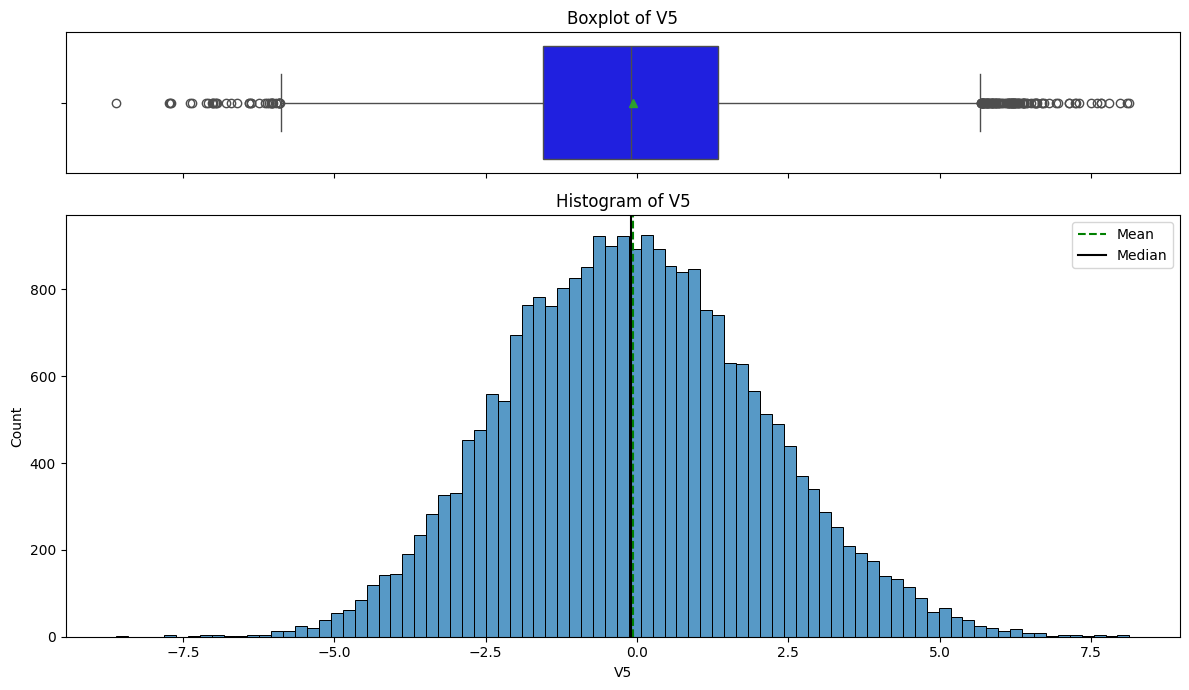

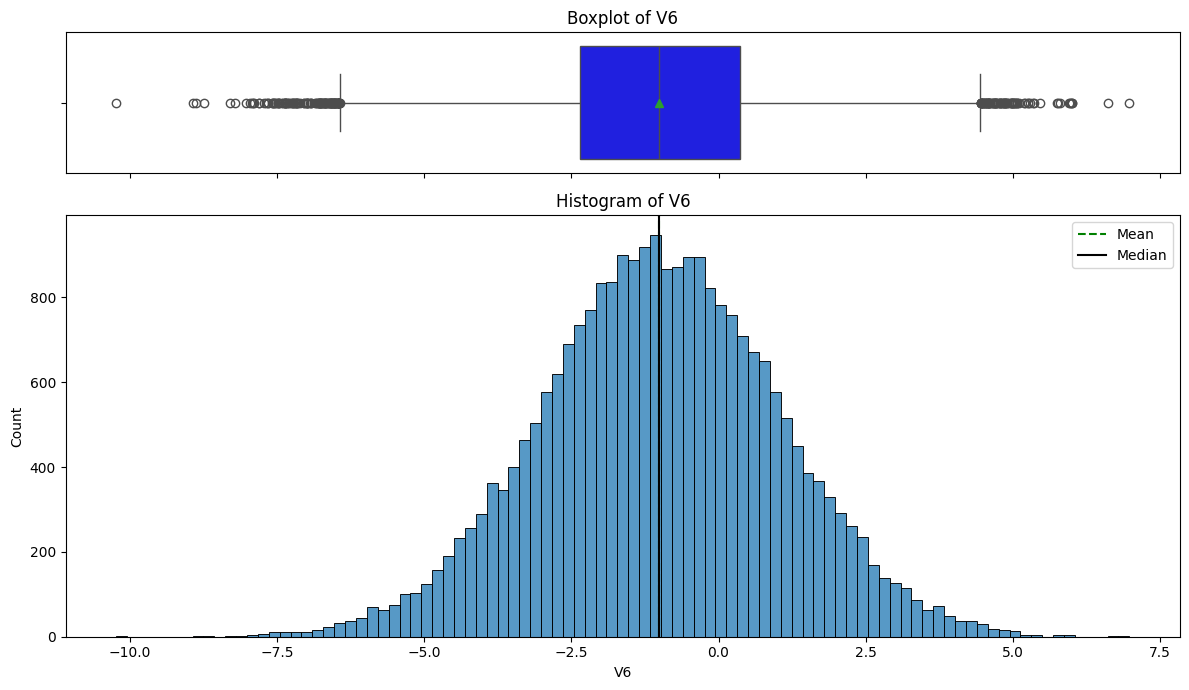

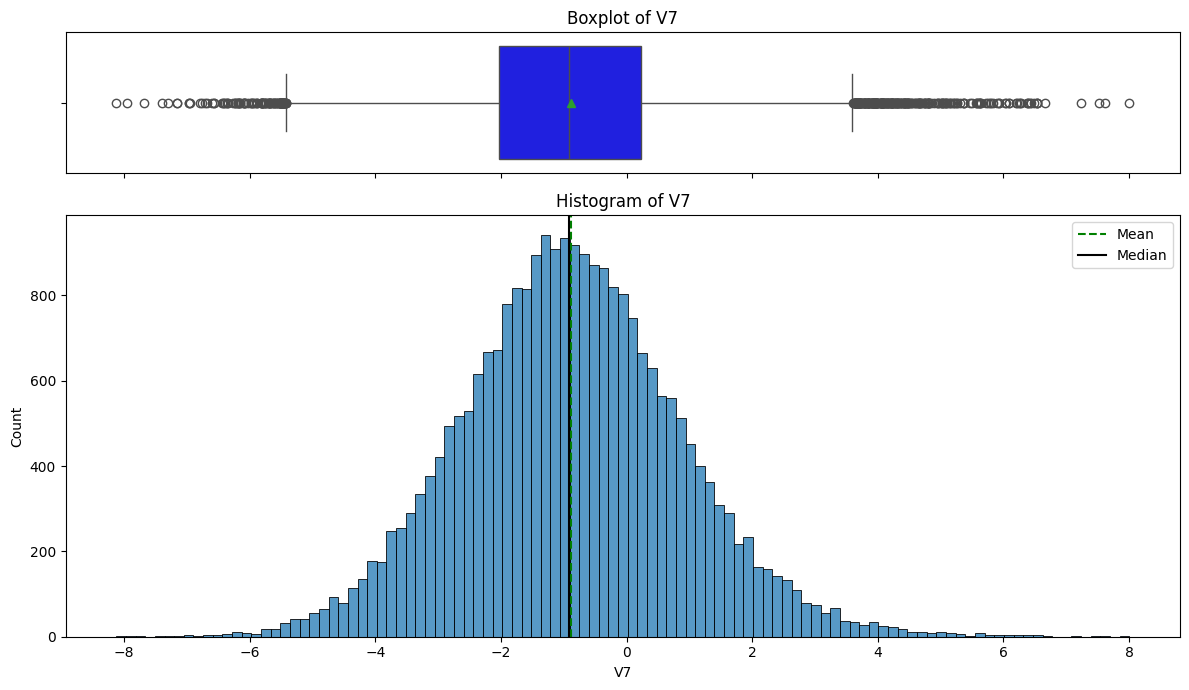

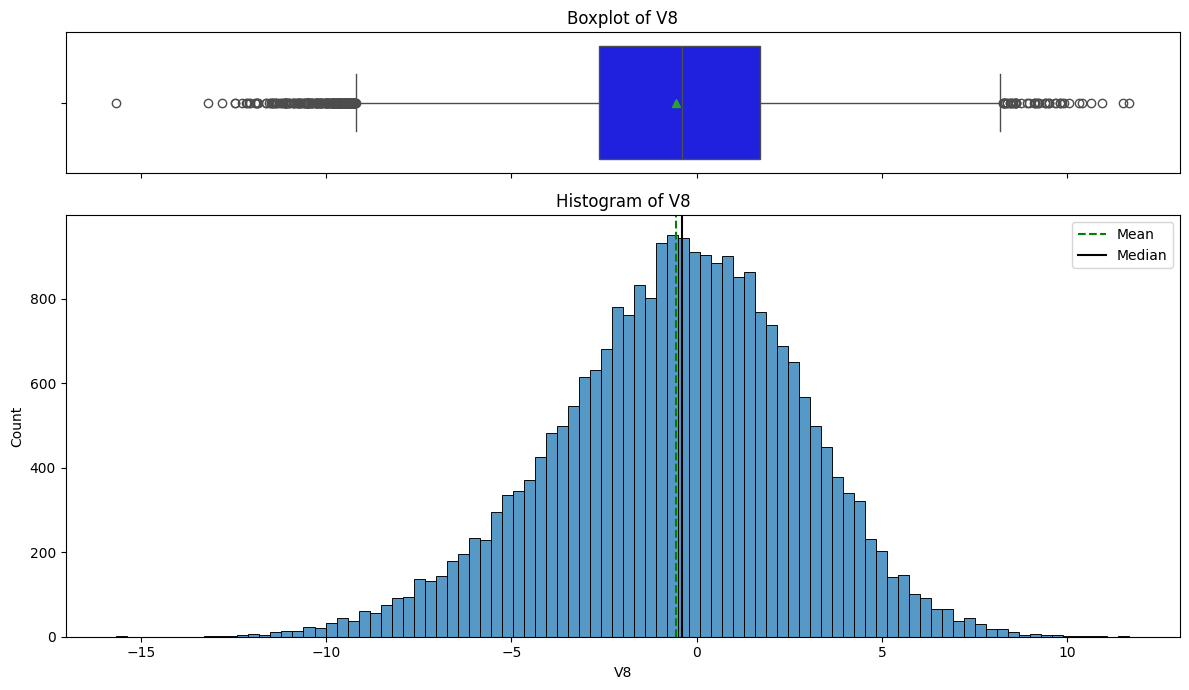

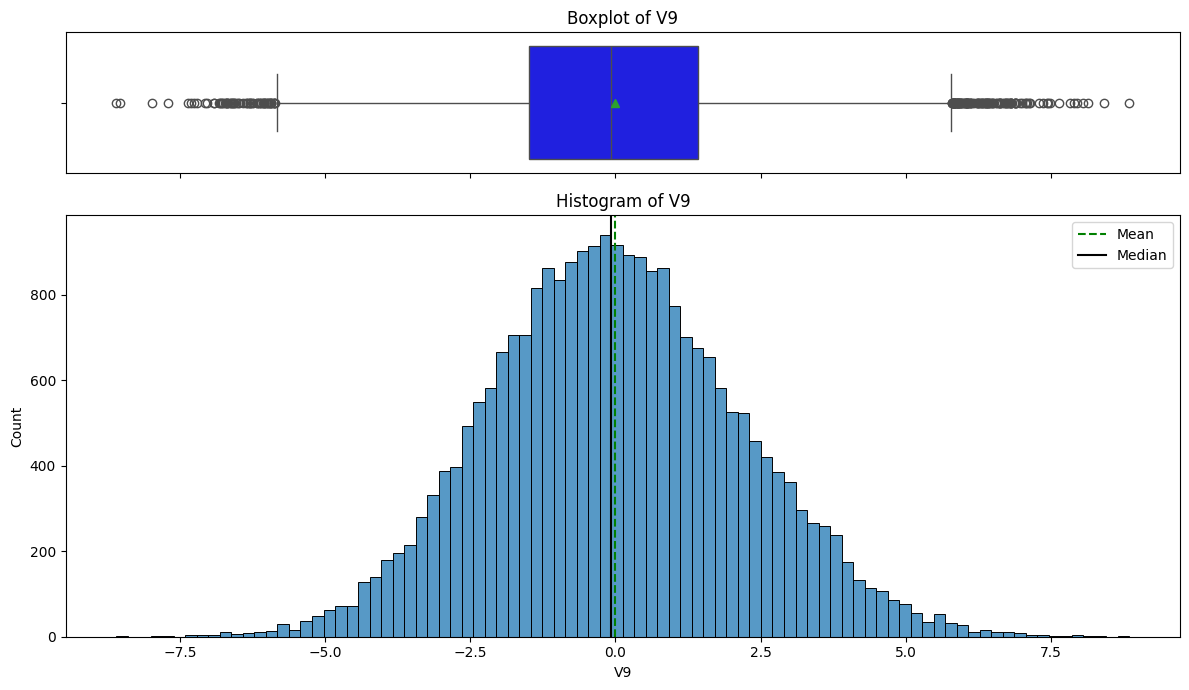

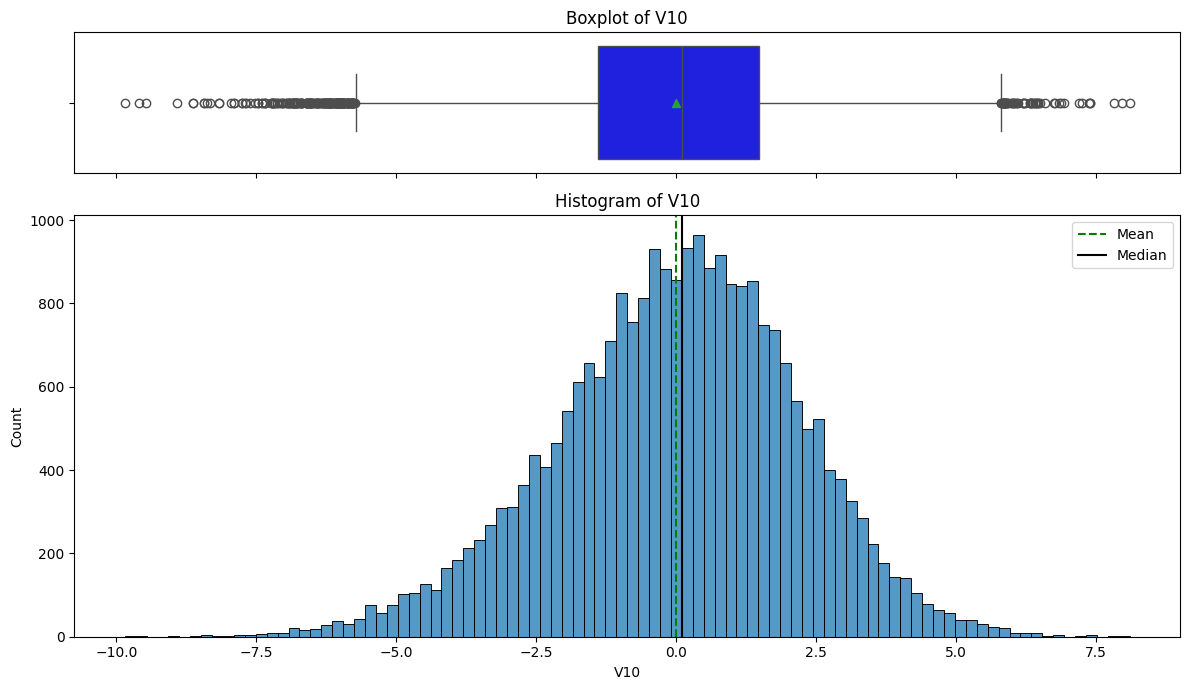

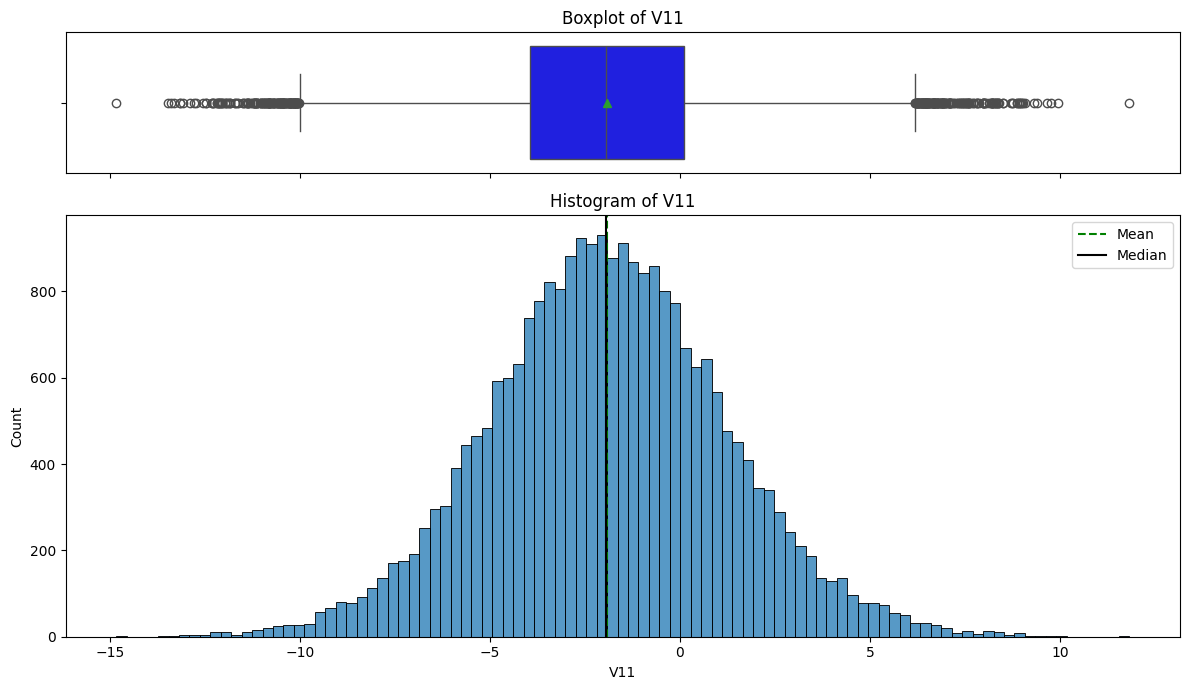

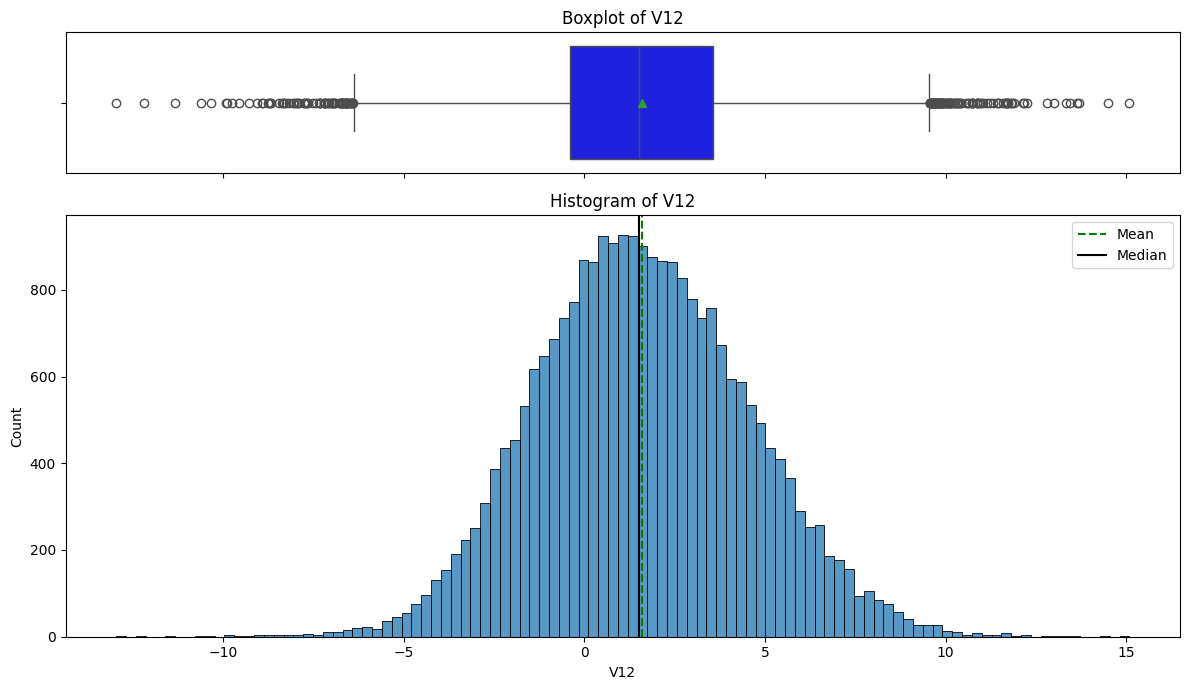

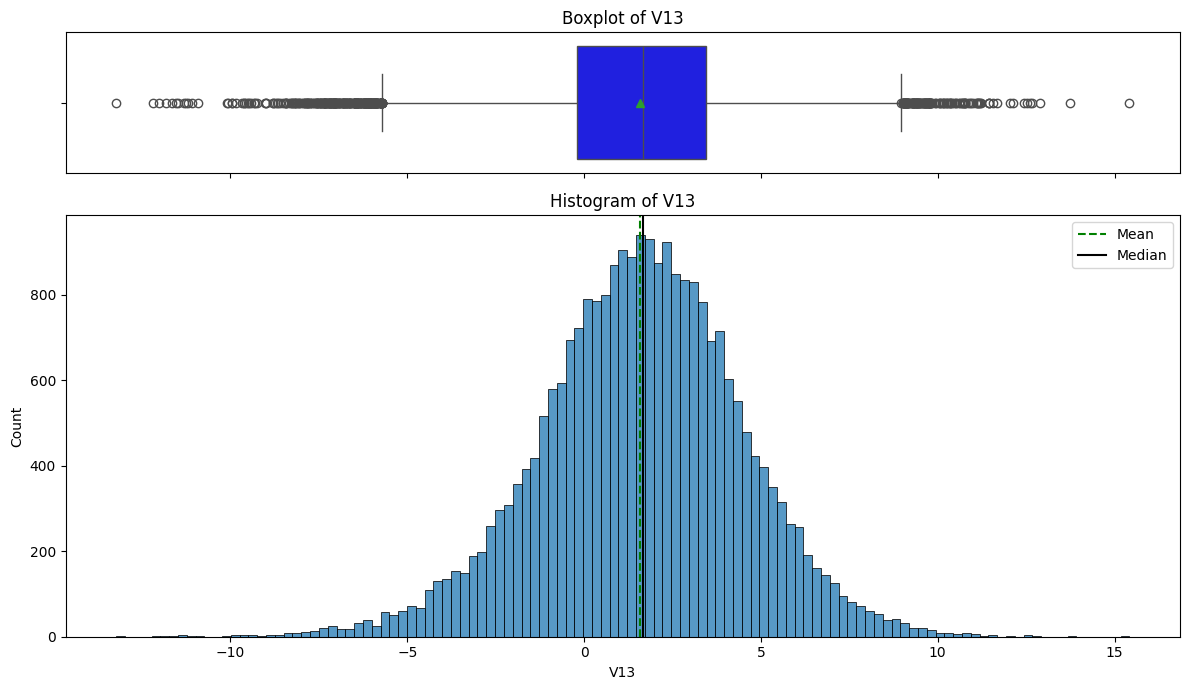

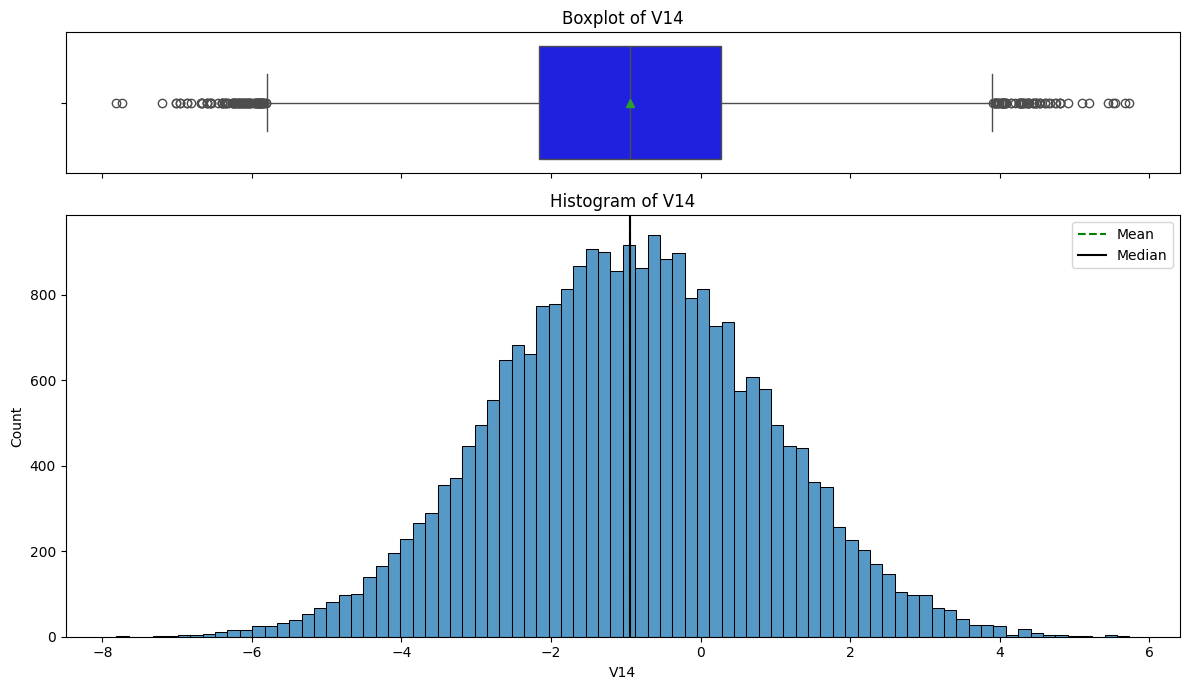

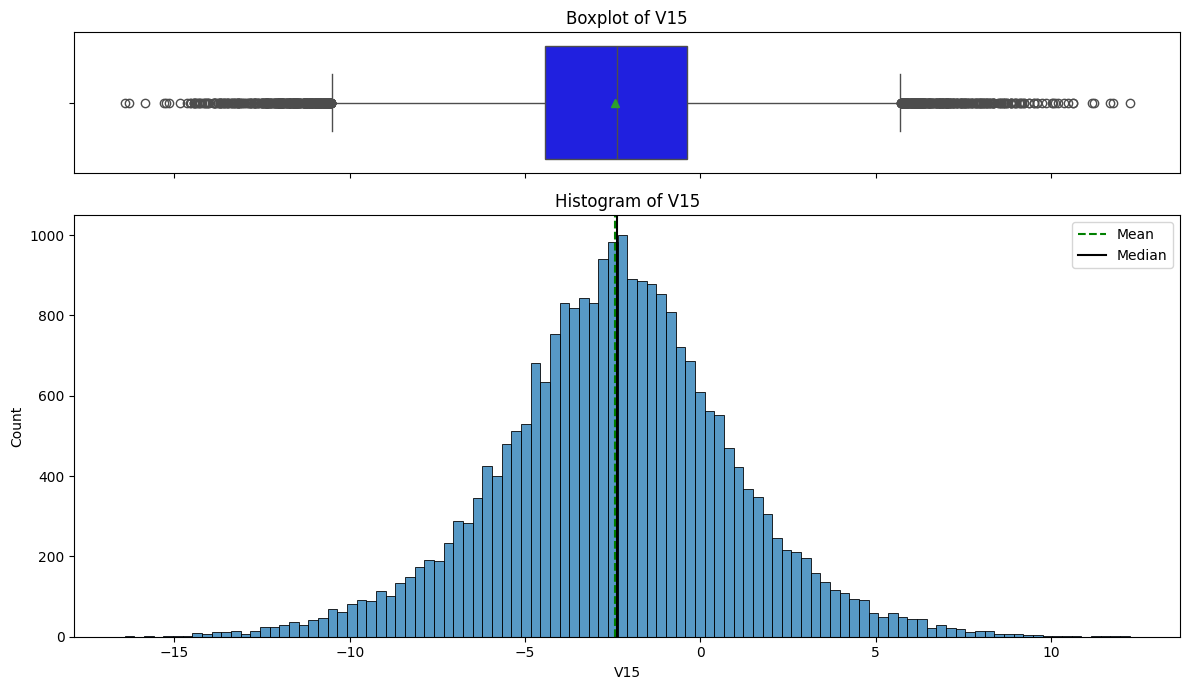

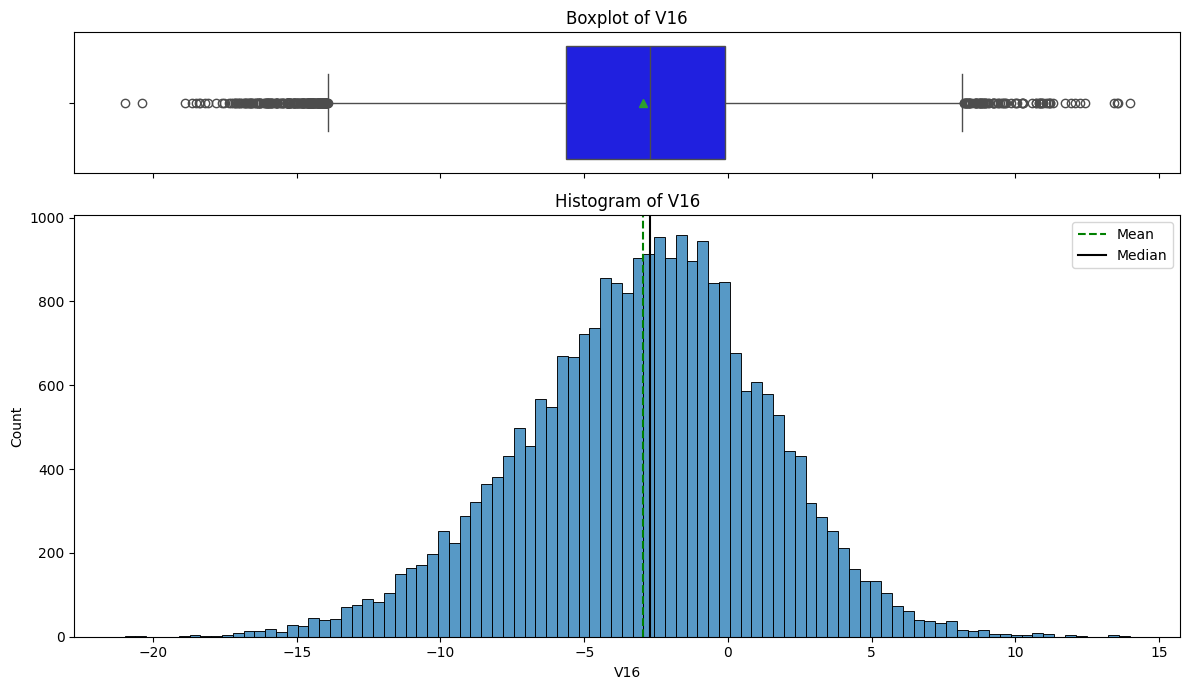

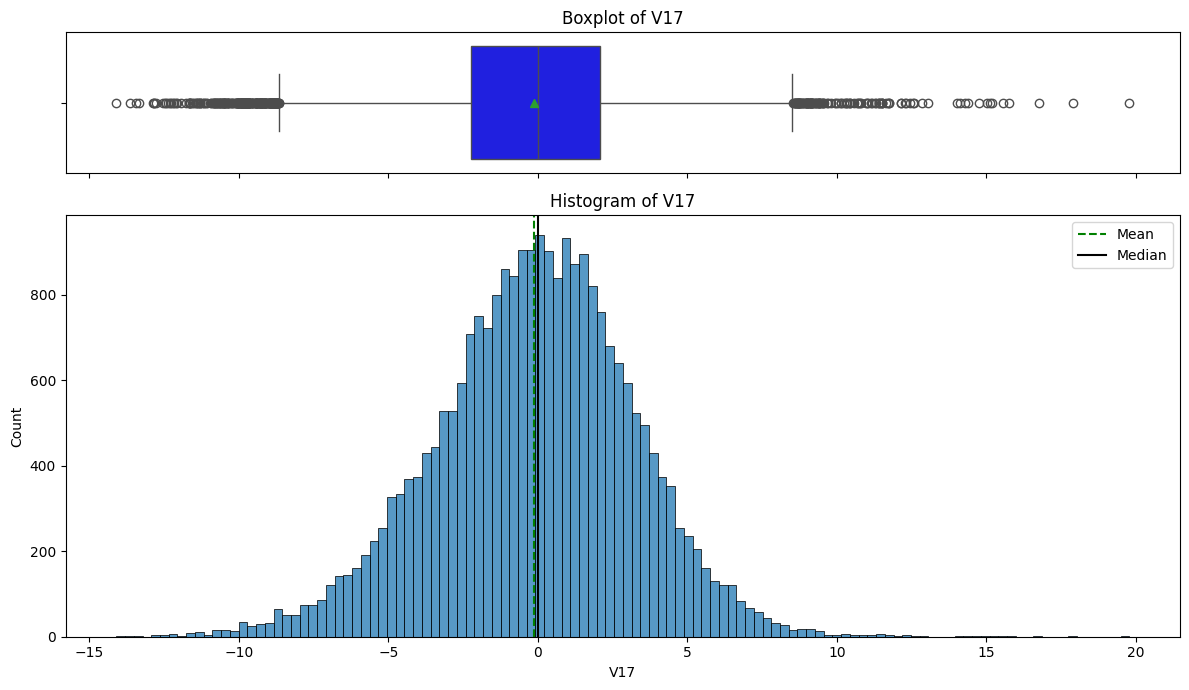

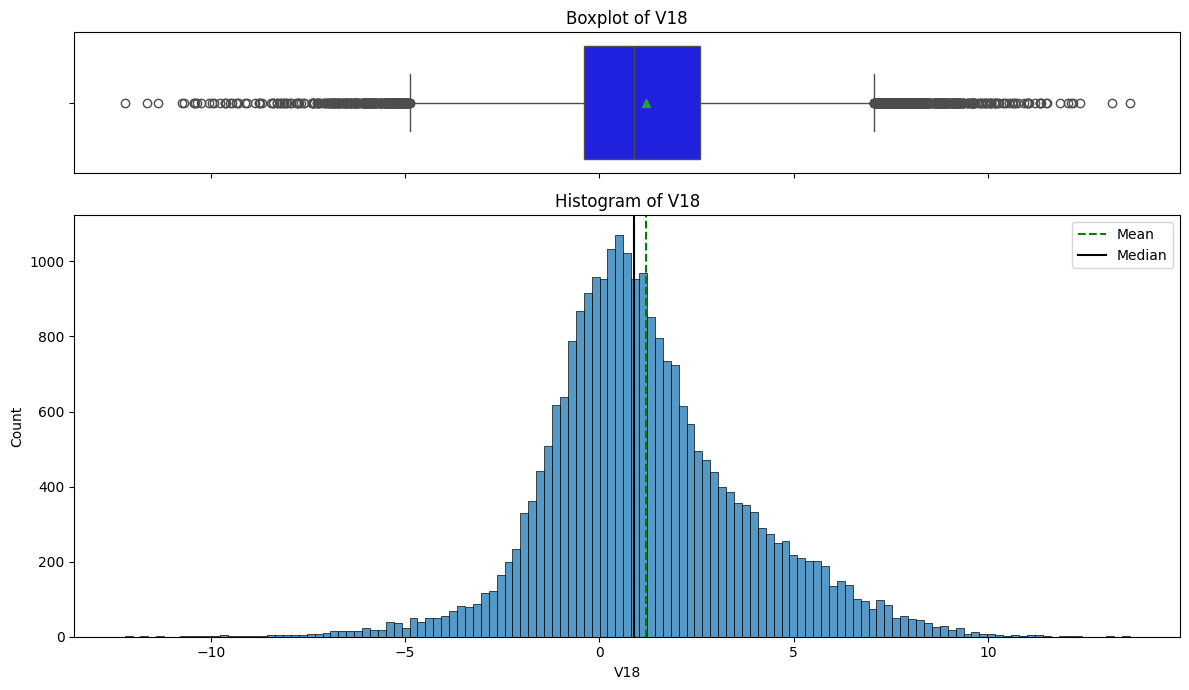

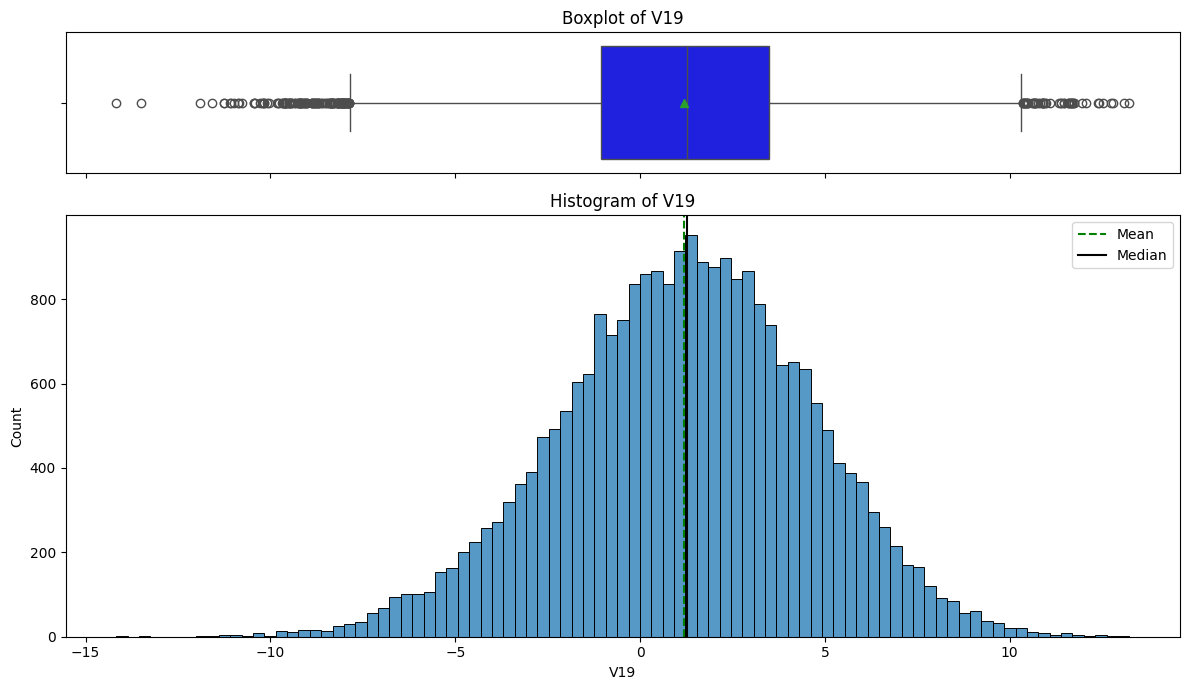

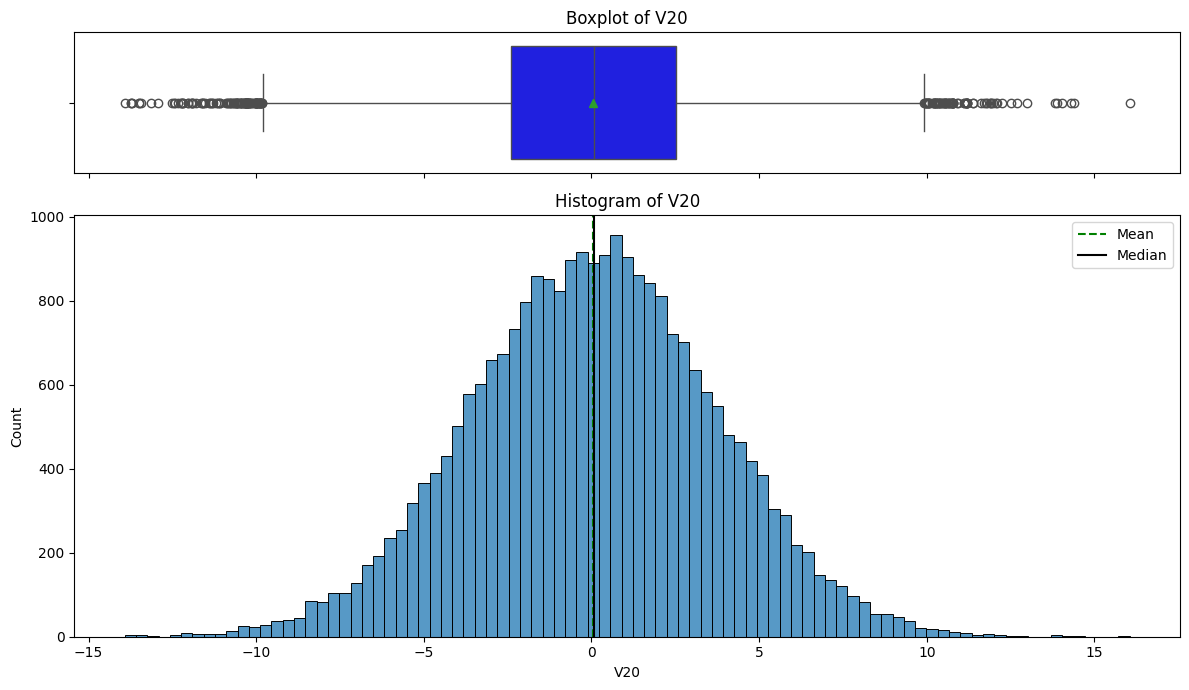

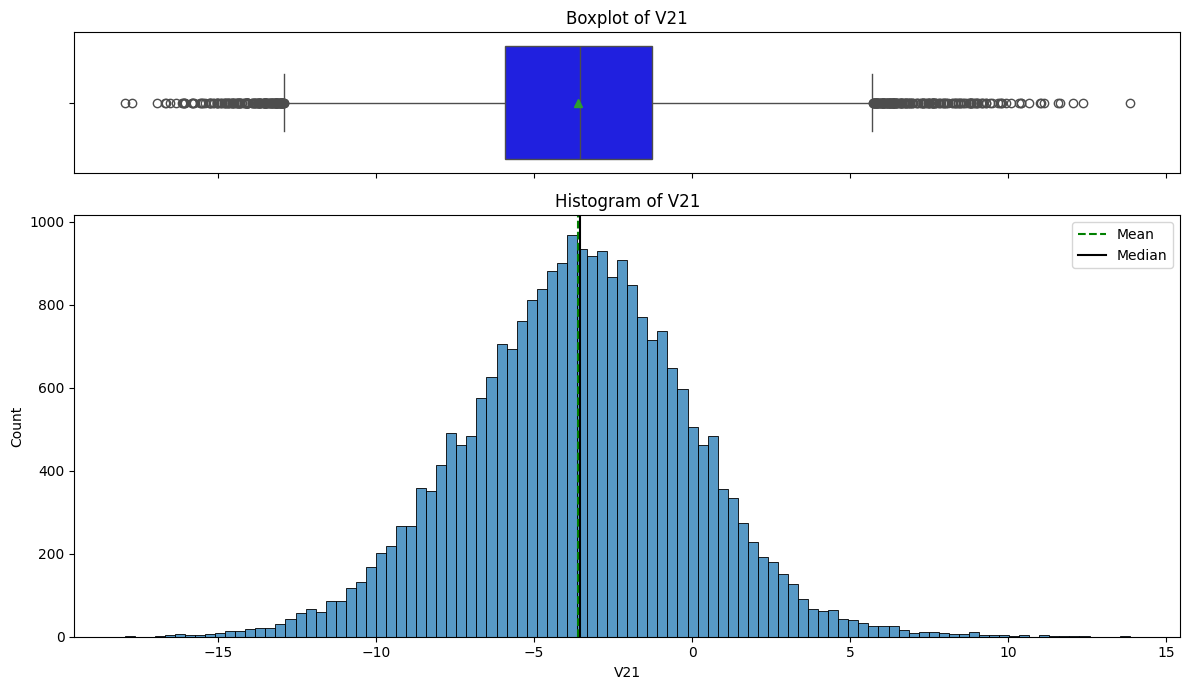

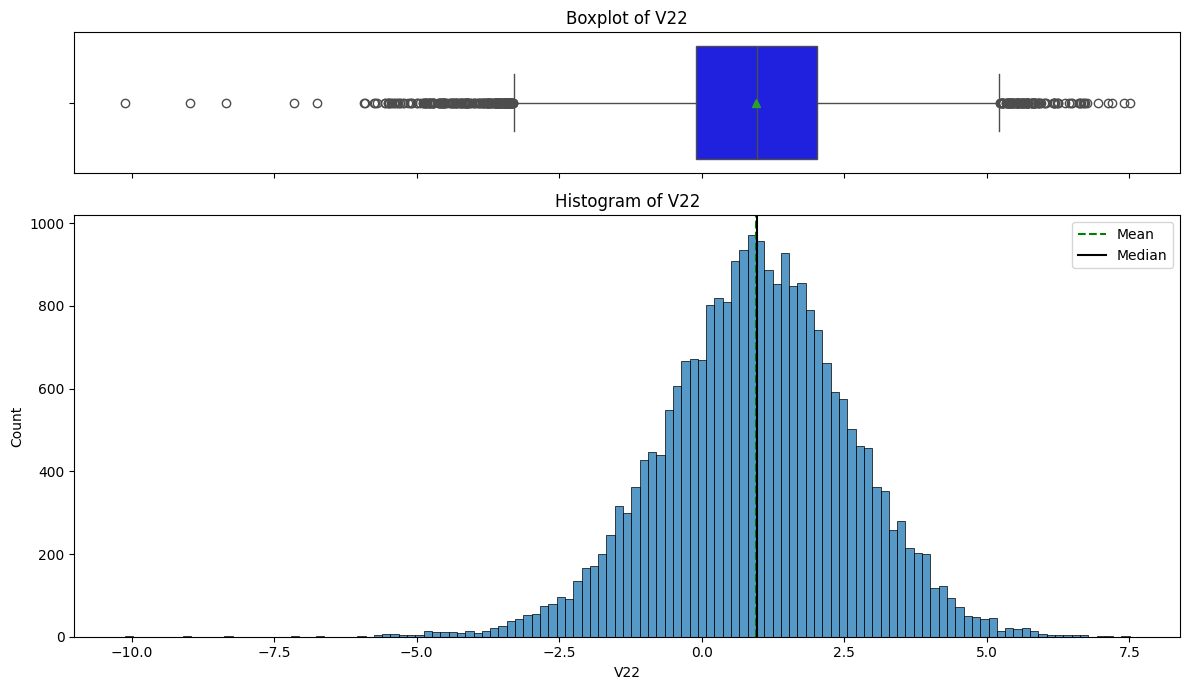

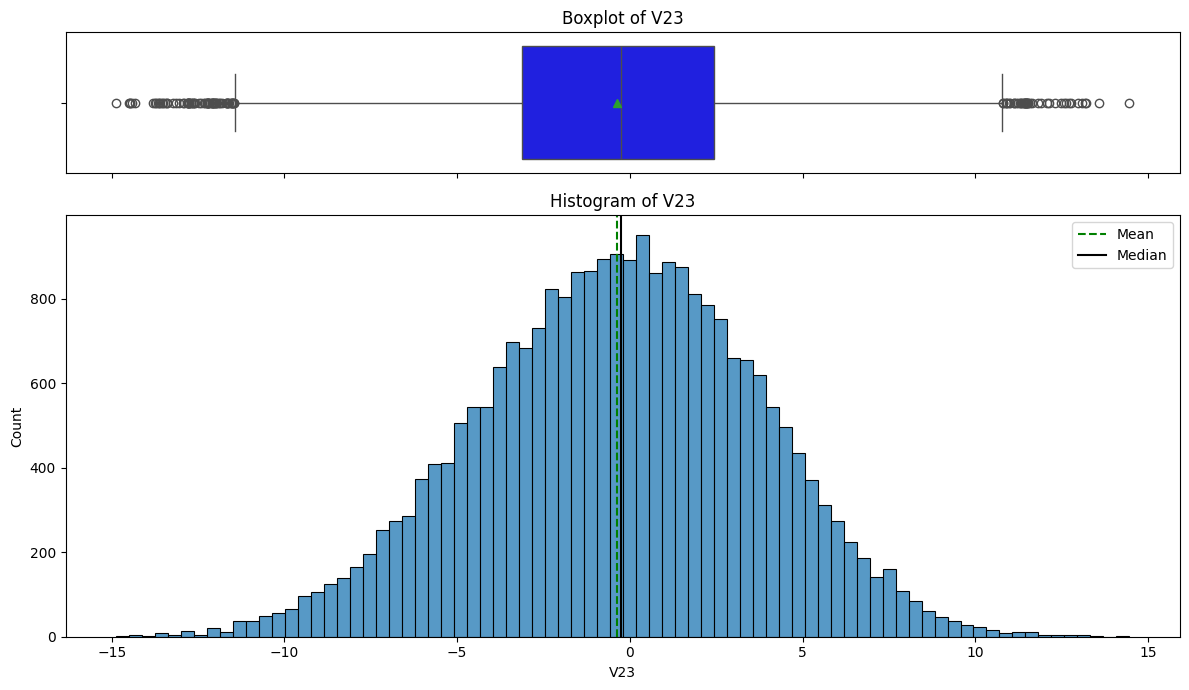

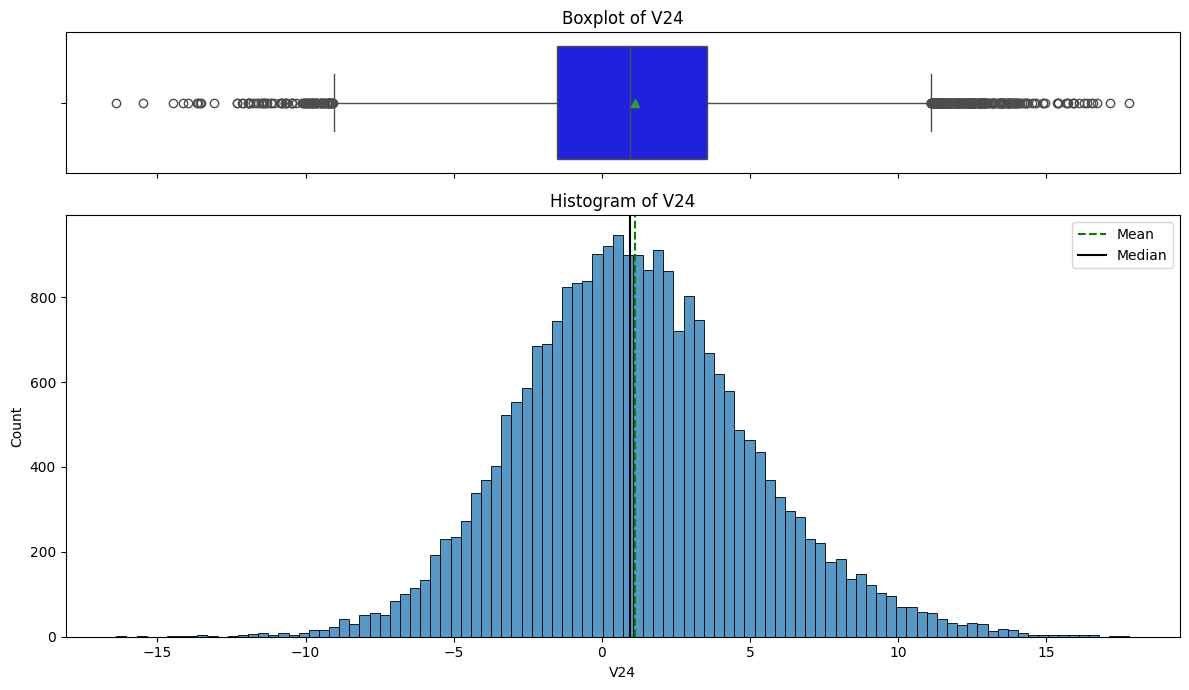

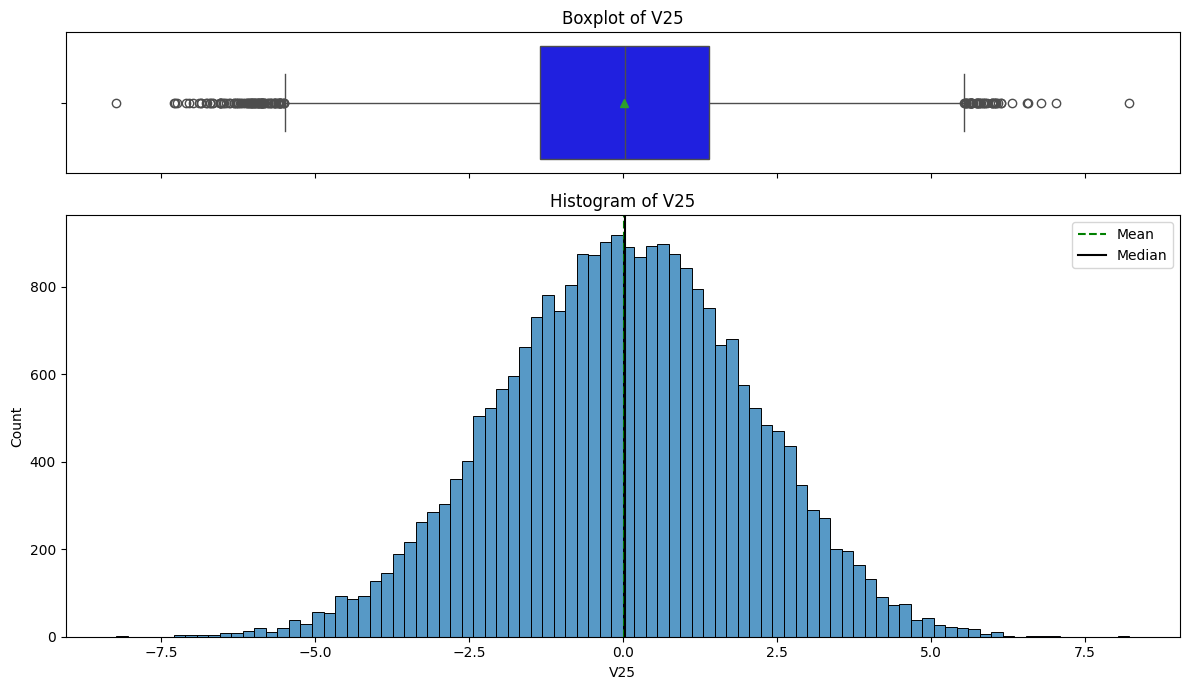

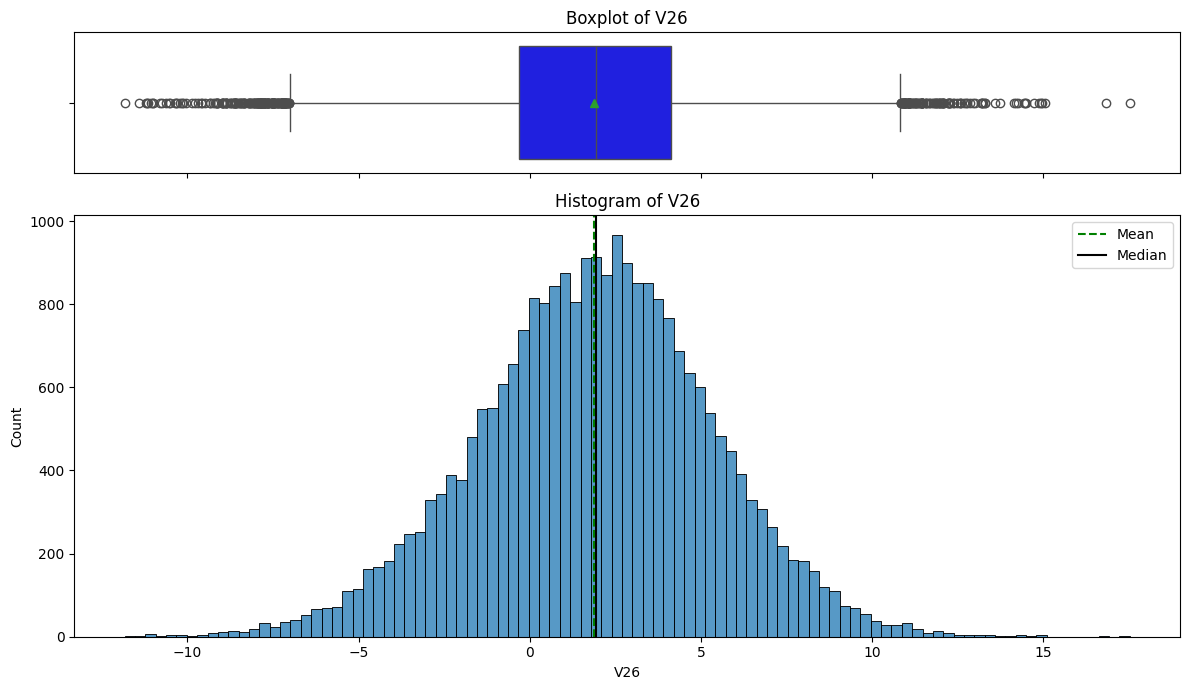

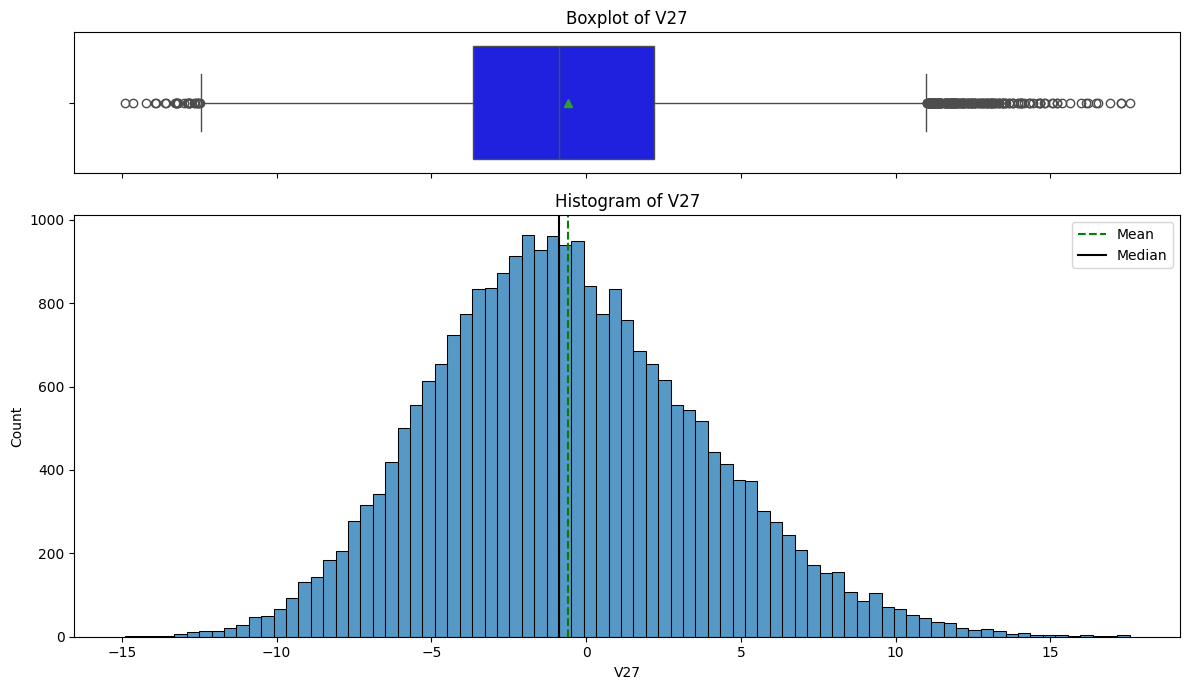

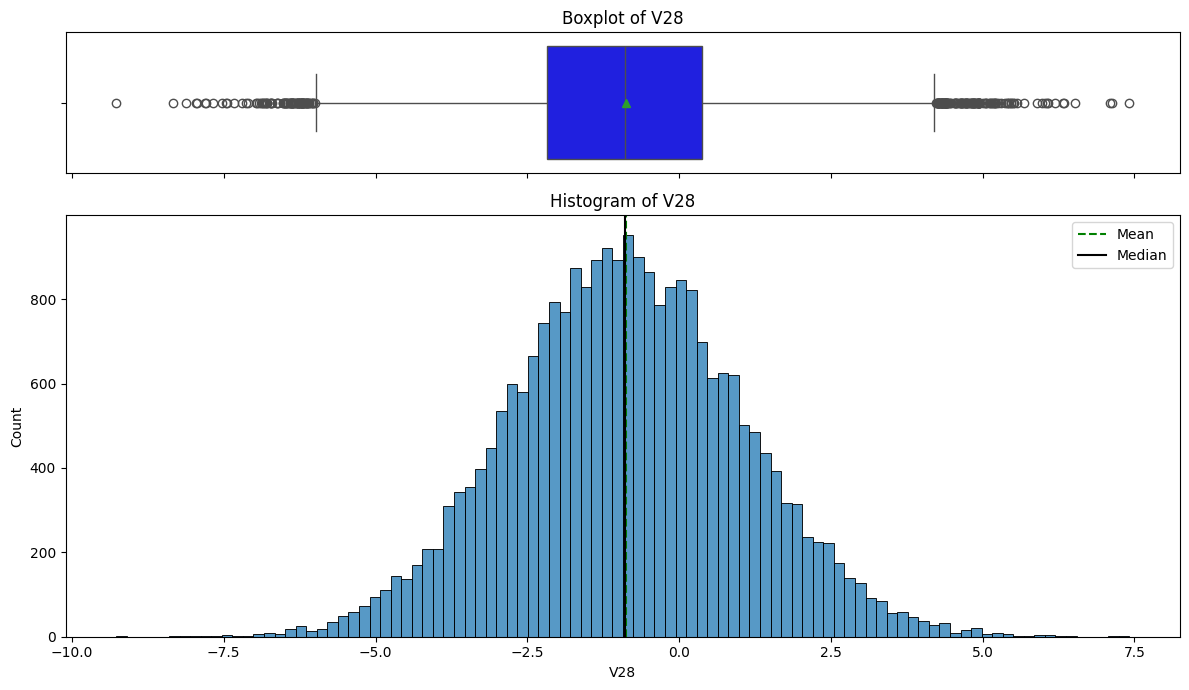

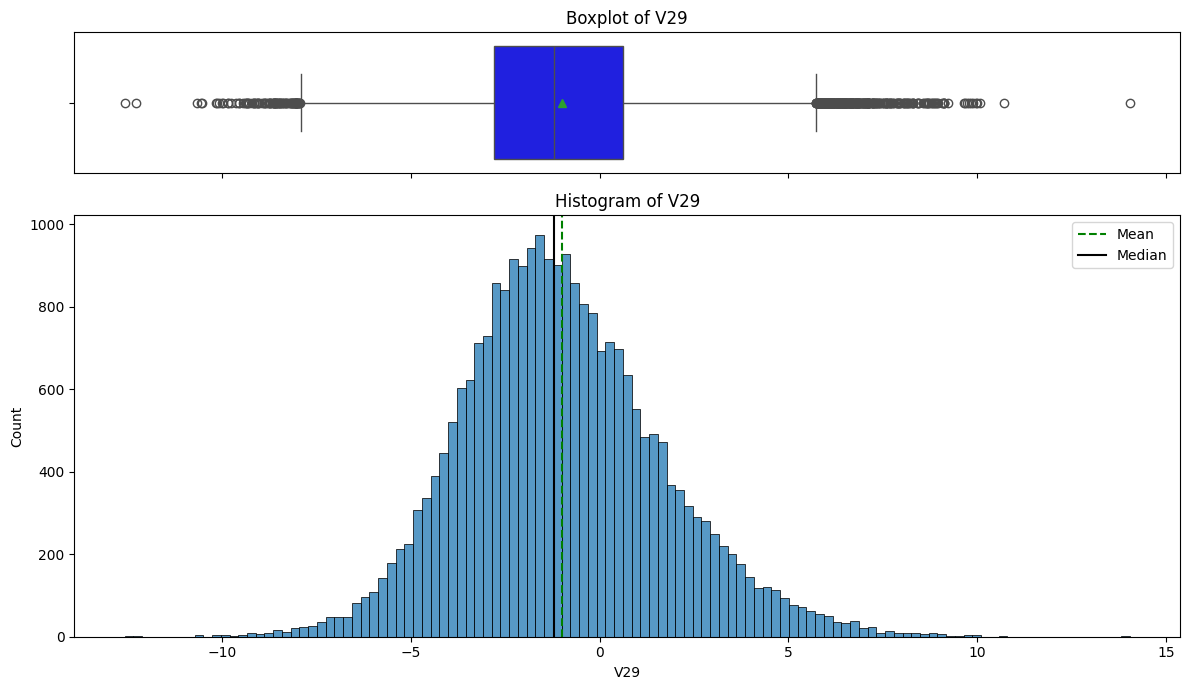

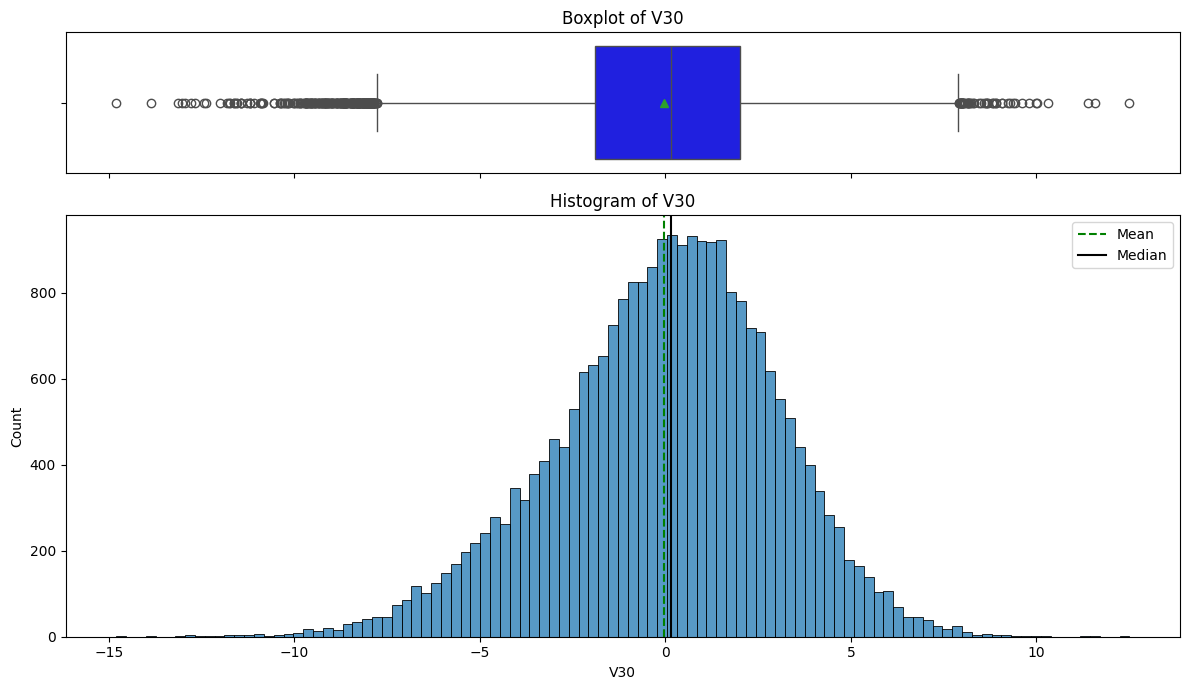

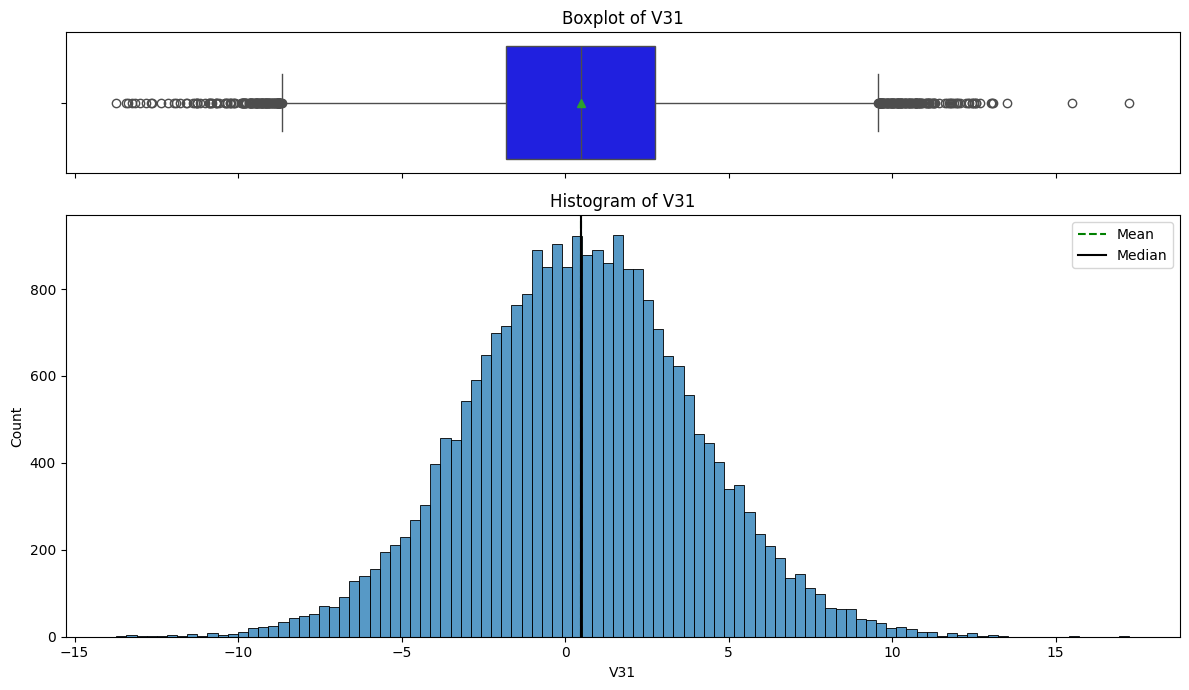

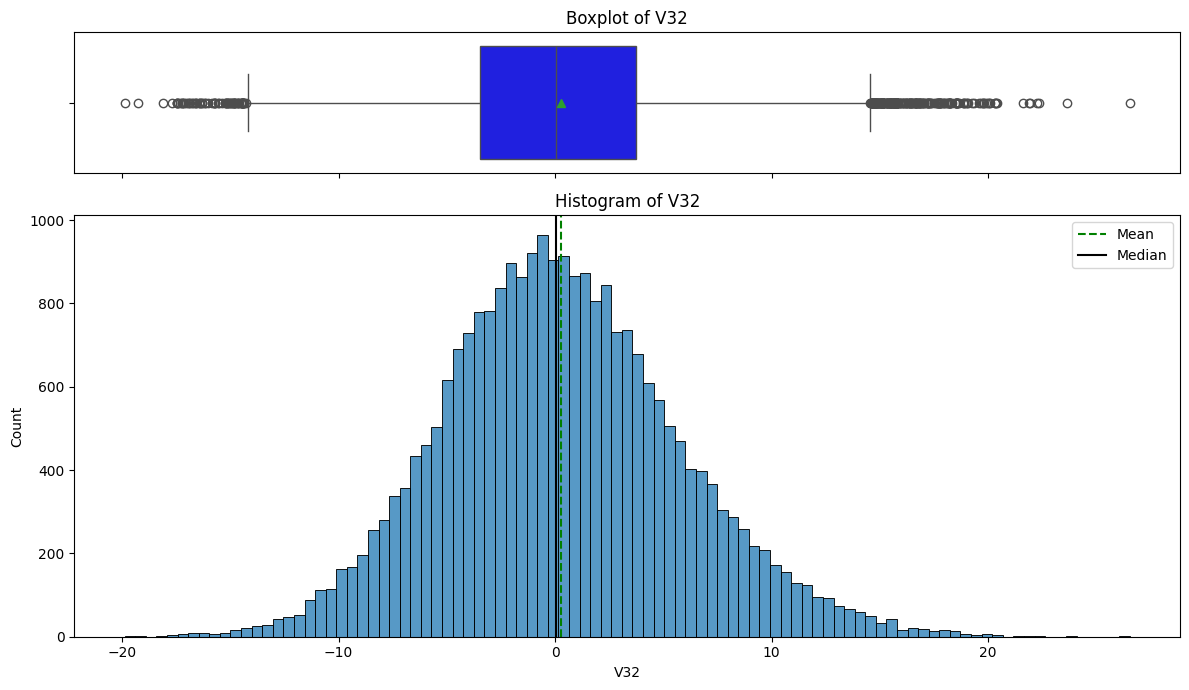

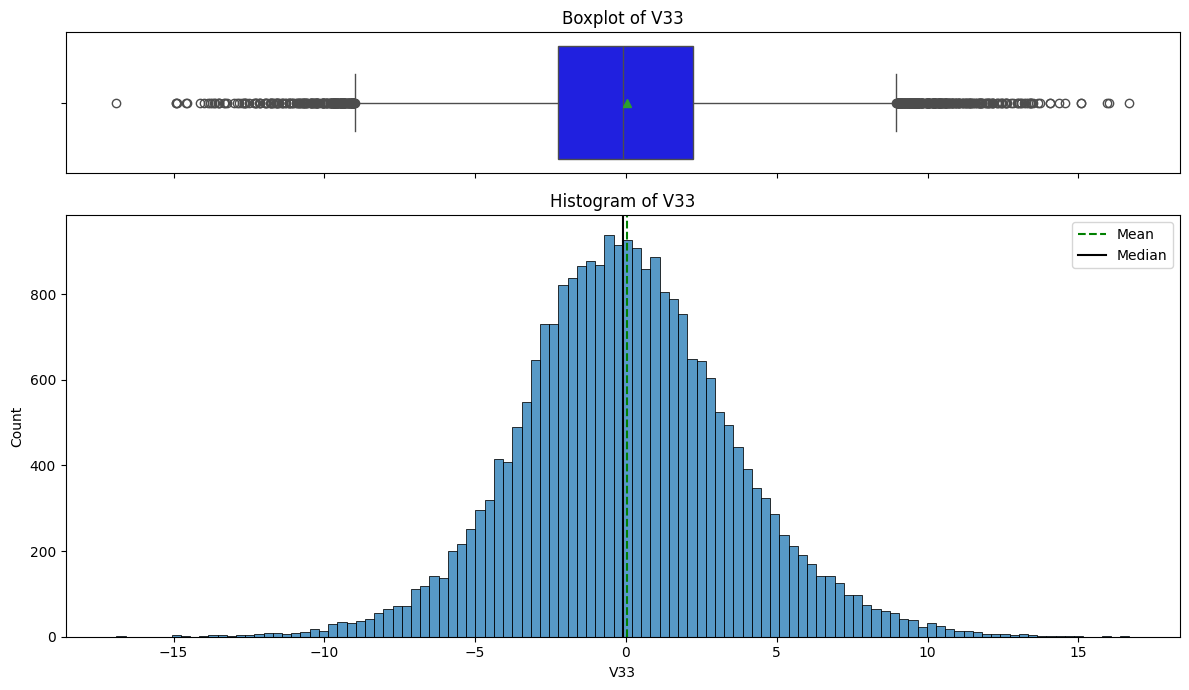

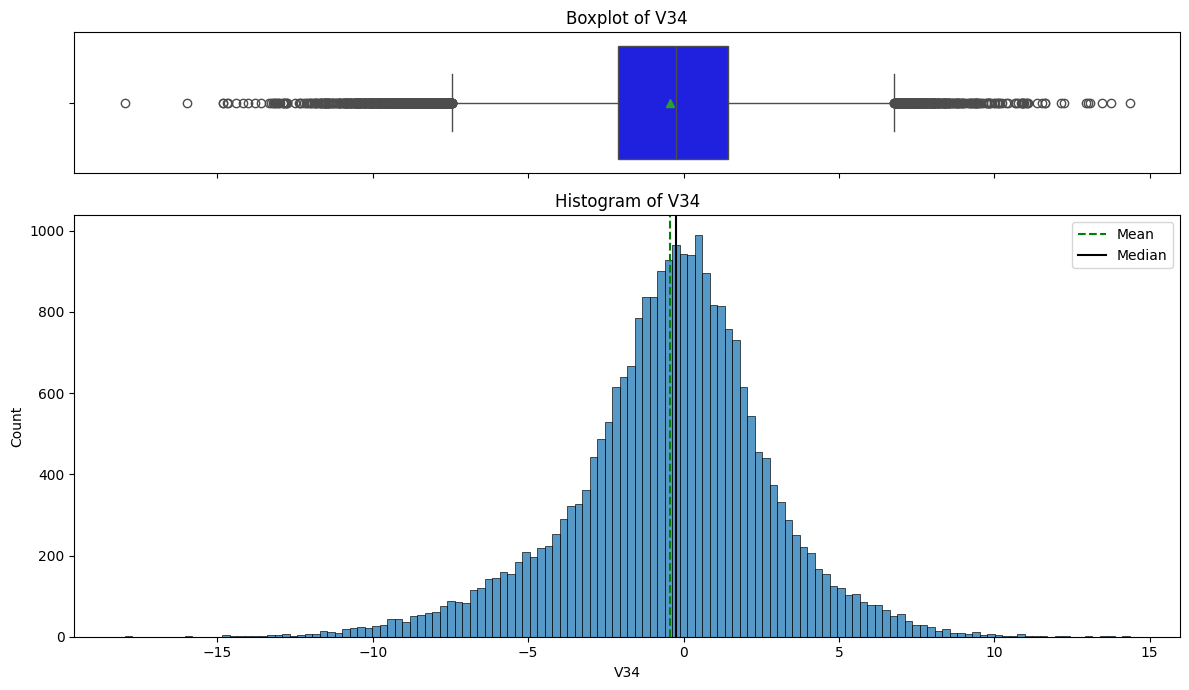

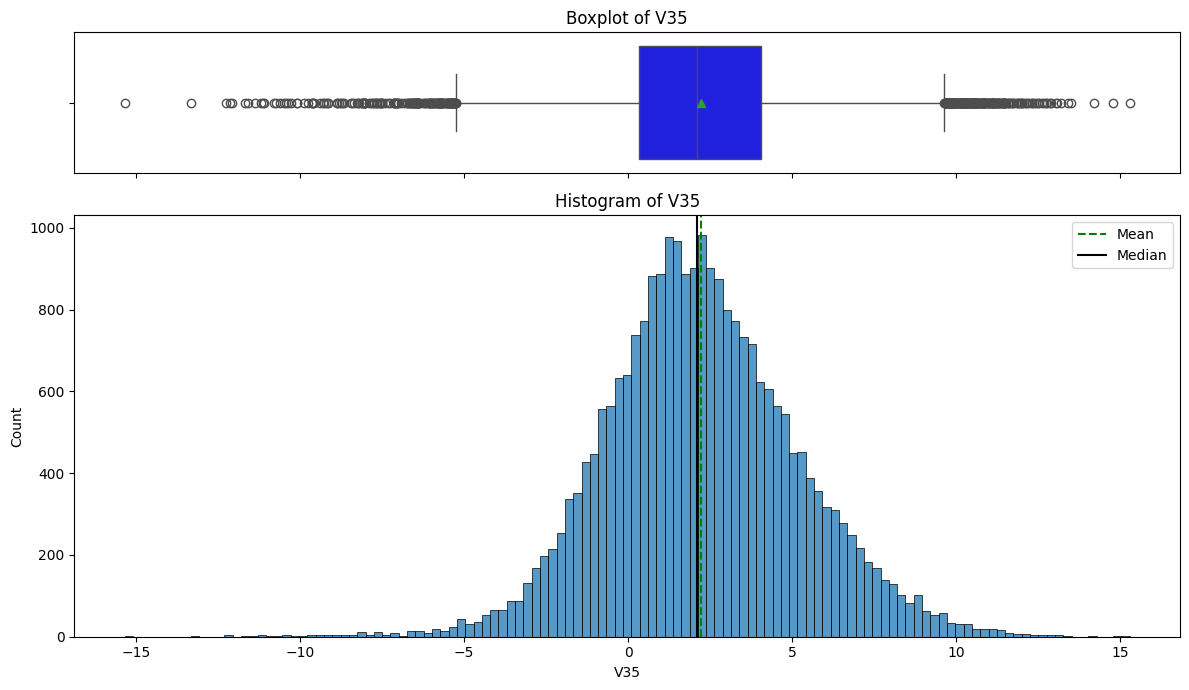

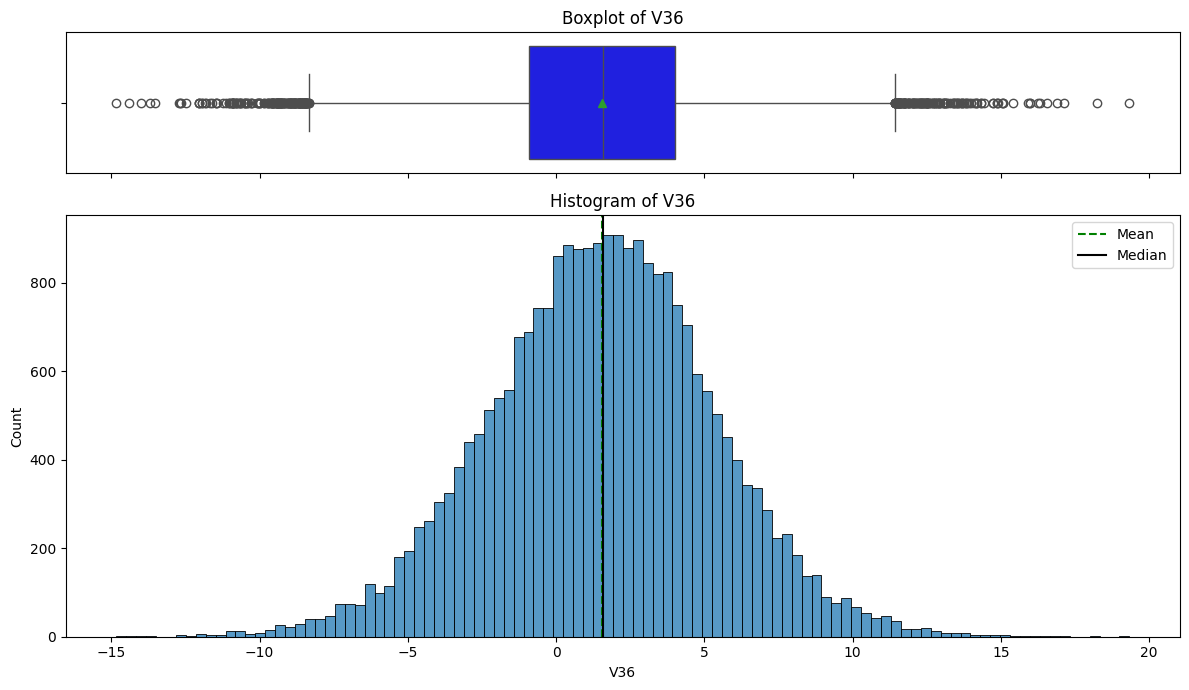

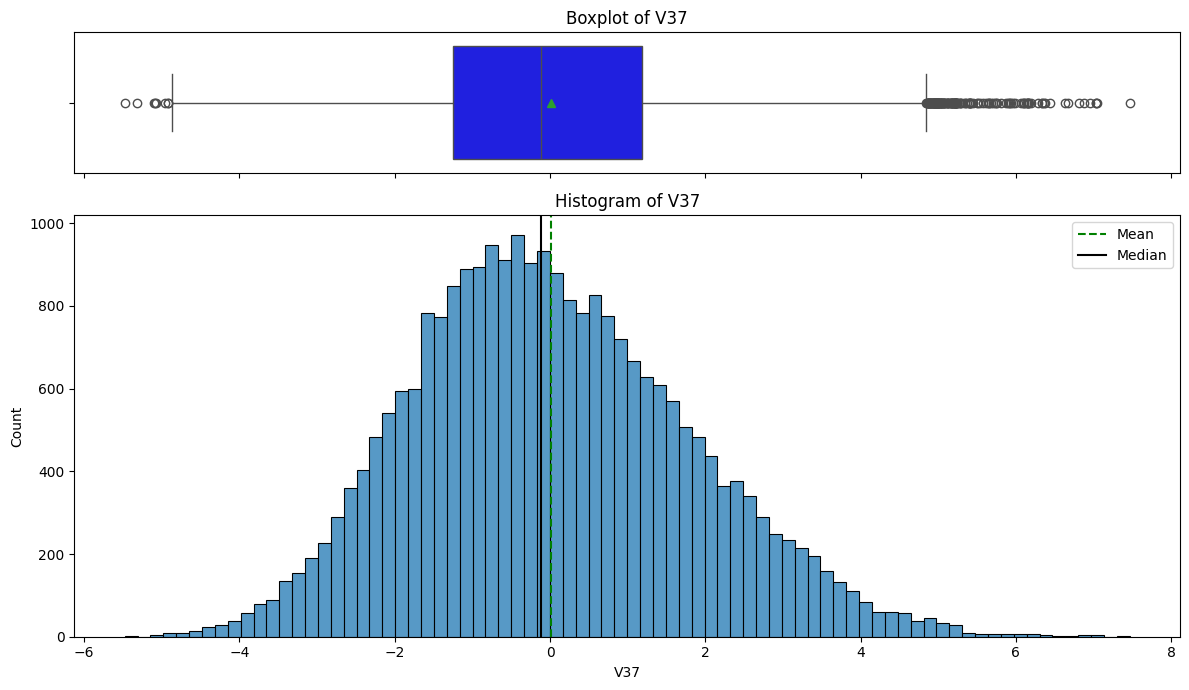

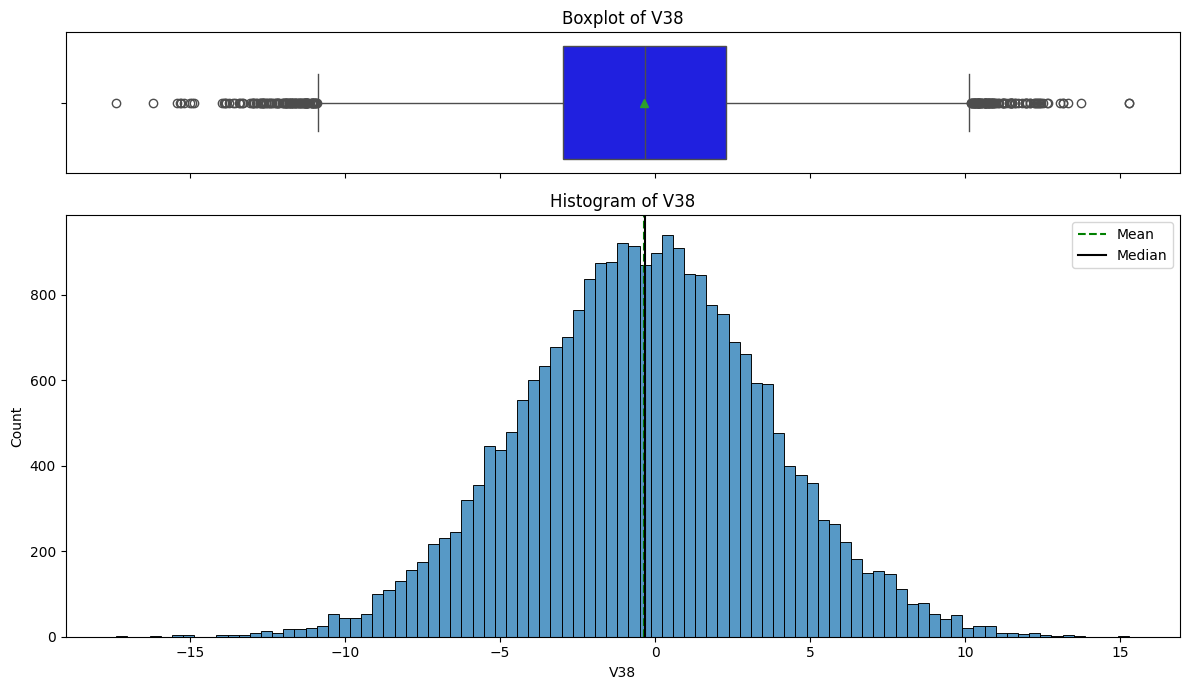

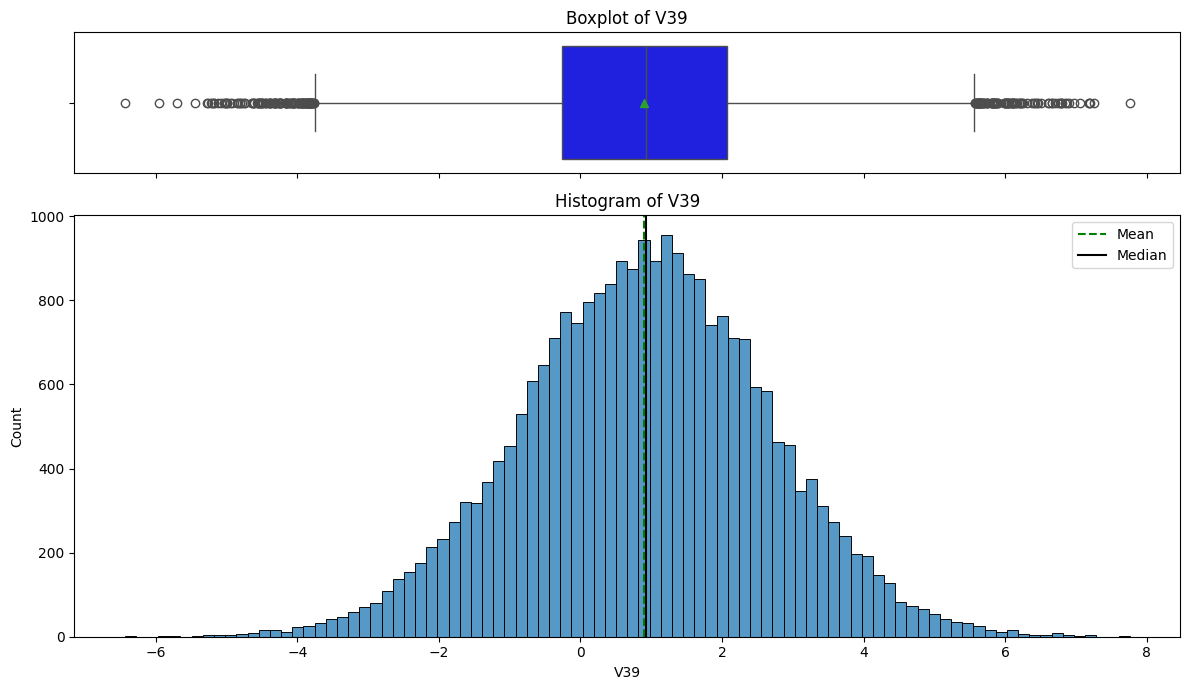

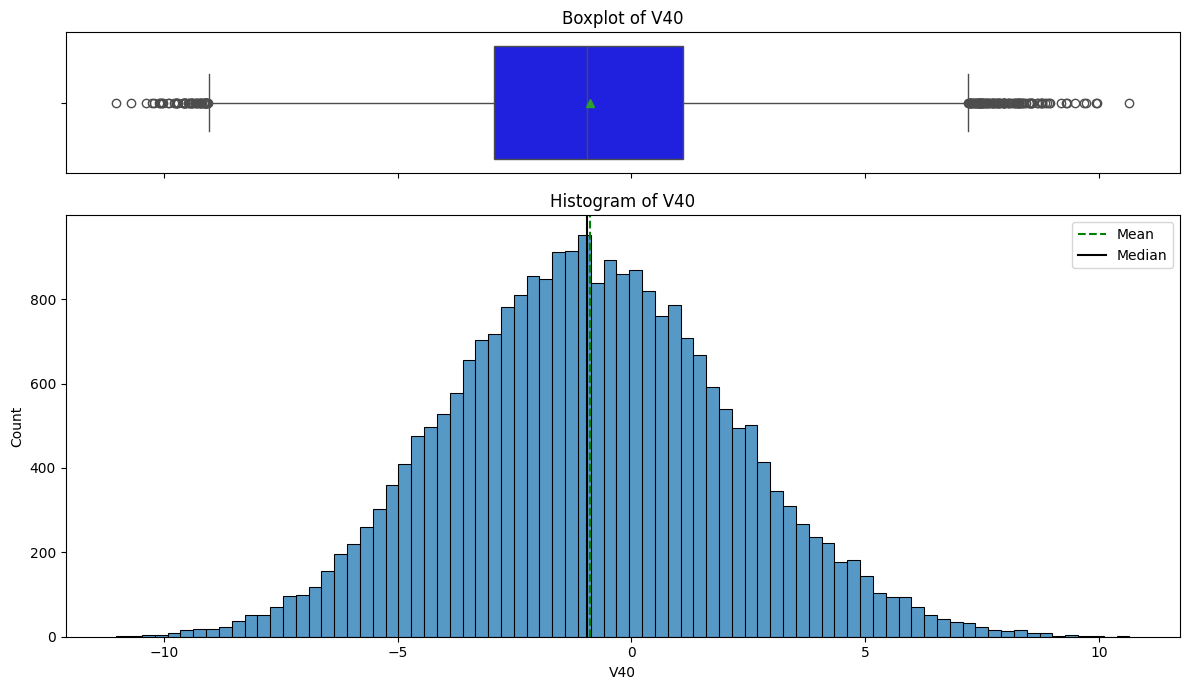

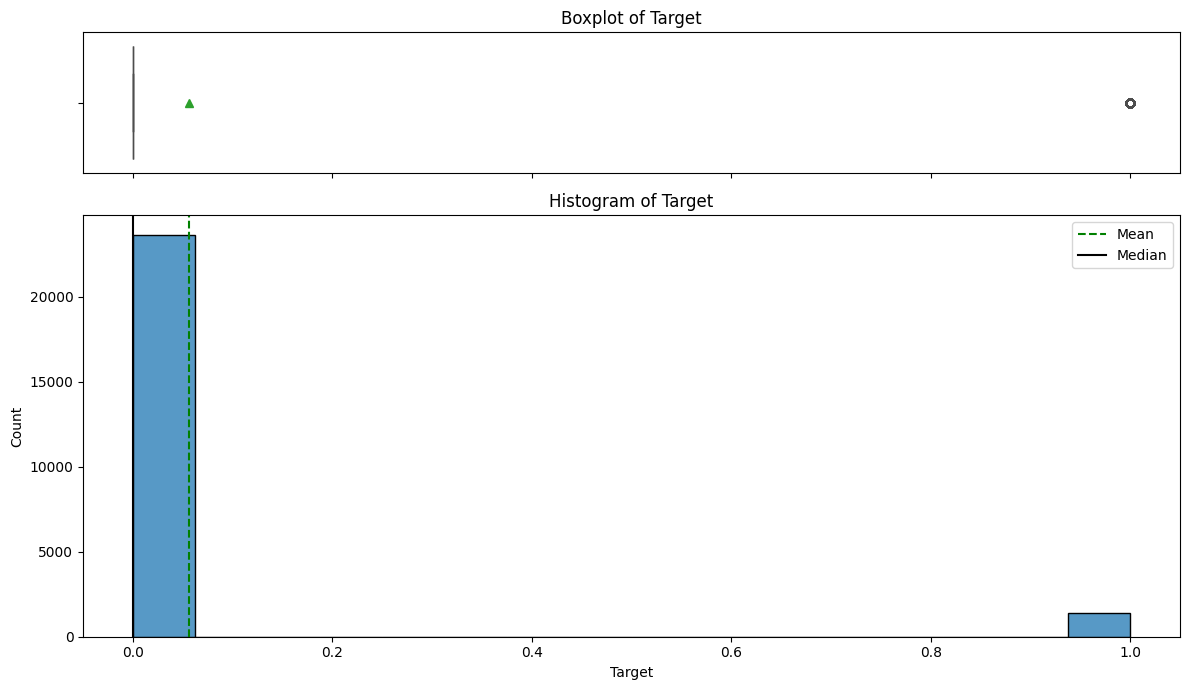

In [ ]:
# Drop index for this purpose
df_eda = df_eda.drop(['index'], axis=1)

# Analyze features
for feature in df_eda.columns:
  histogram_boxplot(df_eda, feature, figsize=(12, 7), kde=False, bins=None)


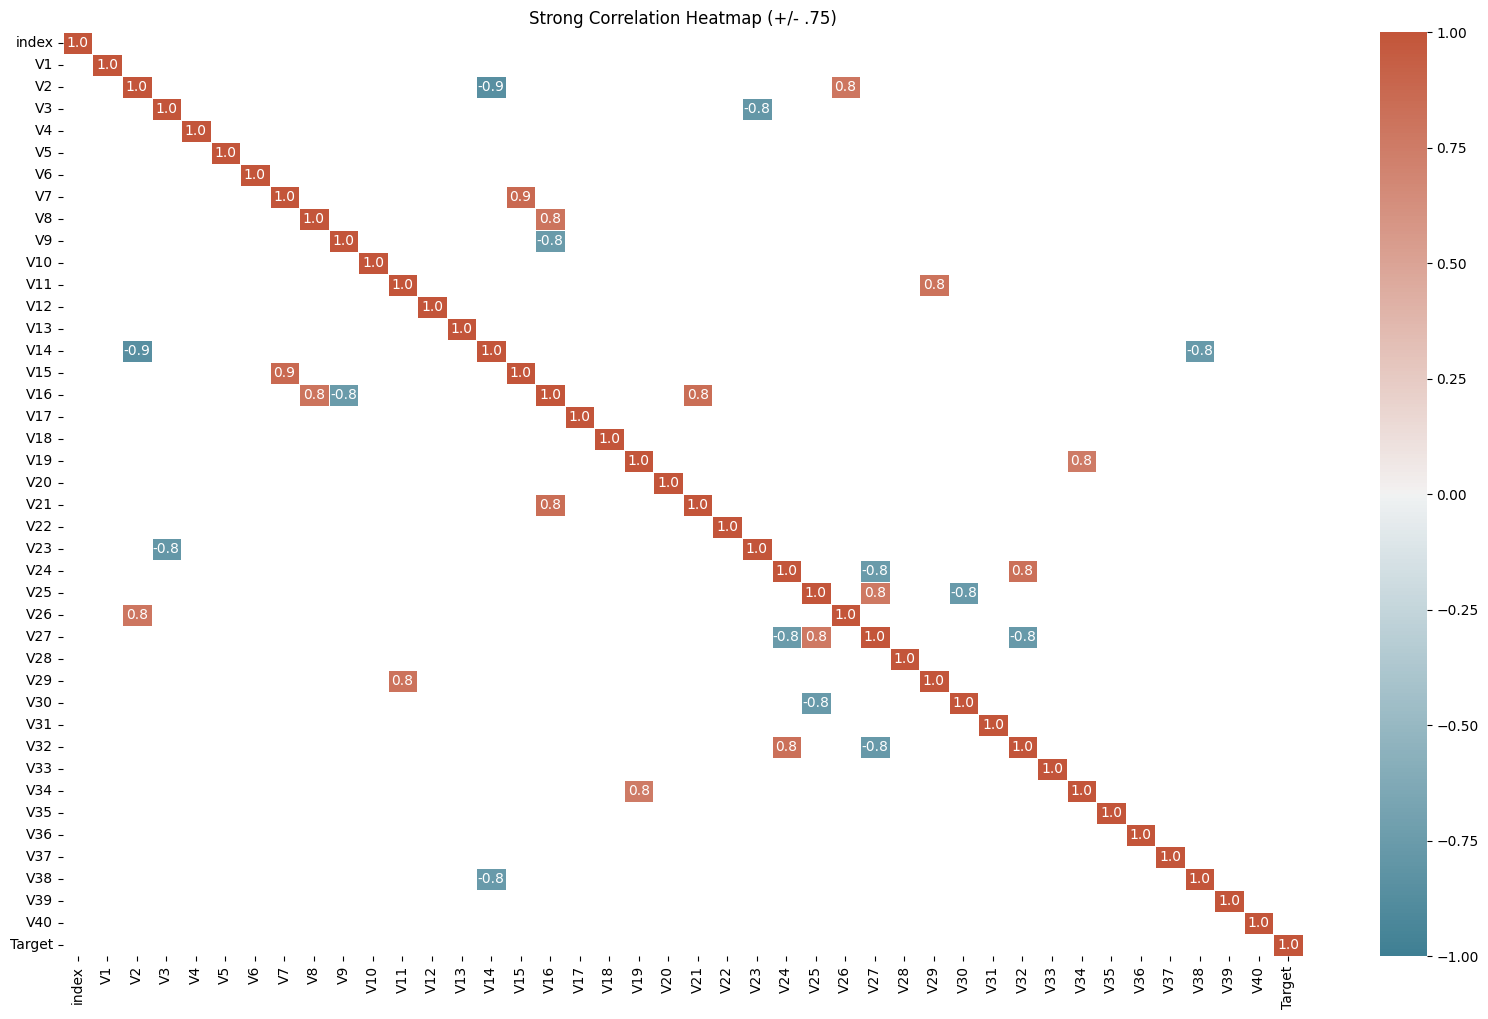

In [ ]:
# Examine any correlations and highlight anything > .75

corr_matrix = df_eda.corr()

# Create a mask for any correlations <= 0.75
mask = np.abs(corr_matrix) <= 0.75 # to handle both positive and negative correlations

# Define color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(20, 12))

# Plot heatmap with the mask
ax = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt=".1f", linewidths=.5, vmin=-1, vmax=1)

# Rotate y-axis labels
plt.yticks(rotation=0)

plt.title('Strong Correlation Heatmap (+/- .75)')

plt.show()


**OBSERVATIONS**

**Values**
* Most common target value is 0.

* Target variable is imbalanced. We will need to address this later during modeling.

* Nearly all features outside of target have a few outliers.

*	Series V1 has 24977 unique values, 0 duplicate values, and 23 missing values.

*	Series V2 has 24976 unique values, 0 duplicate values, and 24 missing values.

*	Series V3 to V40 all have 25000 unique values, 0 duplicate values, and 24 missing values.

*	Series Target has 2 unique values, 24998 duplicate values, and 0 missing values.

**Statistical Significance and Distribution**
*	Of the 40 V* features, 38 are statistically significant, with a p-value of .05 or smaller
*	All 40 V* features have a normal distribution, based on z-scores falling between -2 and 2.

**Correlation**

* In our correlation heatmap, we can see that the Target variable has correlations with three V* features in particular:
	* V15 (0.3)
	* V21 (0.3)
	* V18 (-.3)
* A few other V* features have notable correlations > +/- .75, as shown in the heatmap analysis. Later, we will confirm feature importance for any of these.


###Bivariate Analysis

Next, let's visualize some of the other (non-Target) correlations we detected earlier. All of the following items had correlations higher than +/-.75 with other variables.

In addition, we'll also visualize V15, V21 and V18 with regard to our Target variable.

* V2-V14: -.9
* V2-V26: +.8
* V3-V23: -.8
* V7-V15: +.9
* V8-V16: +.8
* V9-V16: -.8
* V11-V29: +.8
* V14-V38: -.8
* V16-V21: +.8
* V19-V34: +.8
* V24-V27 -.8
* V24-V32: +.8
* V25-V27: +.8
* V32-V27: +.8
* V25-V30: -.8

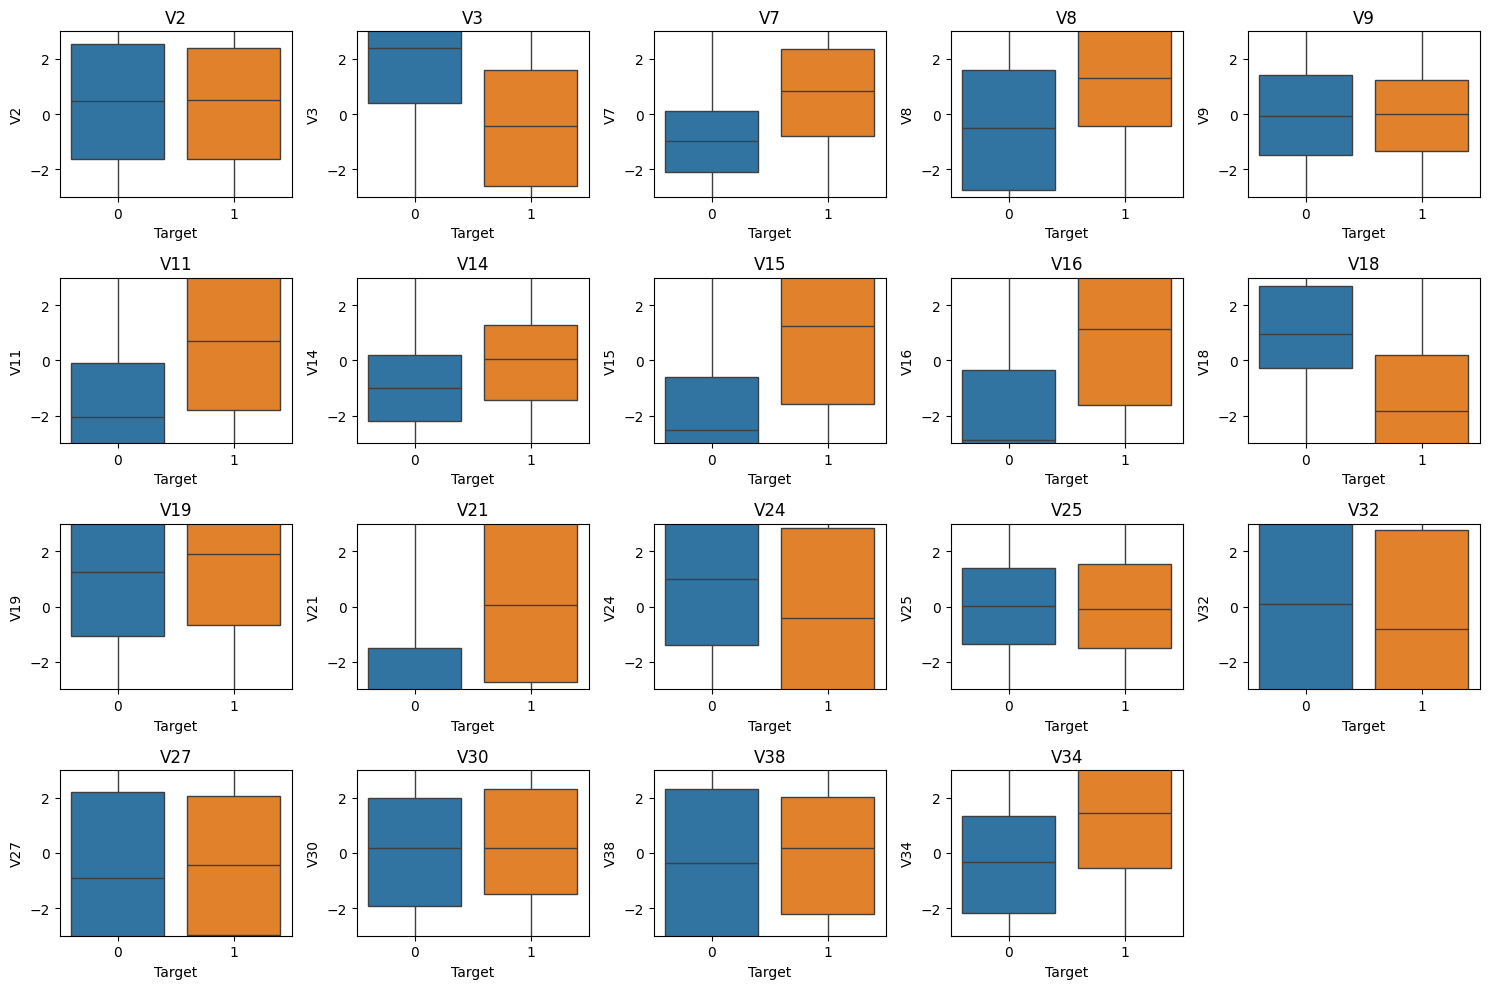

In [ ]:
# Create barplots of important features against target variable
cols = df_eda[['V2', 'V3', 'V7', 'V8', 'V9', 'V11', 'V14', 'V15', 'V16', 'V18', 'V19', 'V21', 'V24', 'V25', 'V32', 'V27', 'V30', 'V38', 'V34']].columns.tolist()
plt.figure(figsize=(15,10))

# Loop through each important feature
for i, variable in enumerate(cols):
    plt.subplot(4, 5, i+1)
    sns.boxplot(data=df_eda, x=df_eda['Target'], y=variable, showfliers=False, hue=df_eda['Target'])
    plt.ylim(-3, 3)
    plt.tight_layout()
    plt.legend().set_visible(False)
    plt.title(variable)
plt.show()

In [ ]:
# Create pairplots for the same

# Time this as it takes very long to run
%%time

# Ensure 'Target' is included
df_eda_pairplot = df_eda[cols + ['Target']]

# Create pairplot
sns.pairplot(df_eda_pairplot, hue='Target', diag_kind='kde')

# Show the plot
plt.show()


Output hidden; open in https://colab.research.google.com to view.

**NOTE**
The correlation heatmap is very complex, and renders fine in the notebook but will not export to HTML. Therefore, I have also included this as a screenshot image below for visibility.

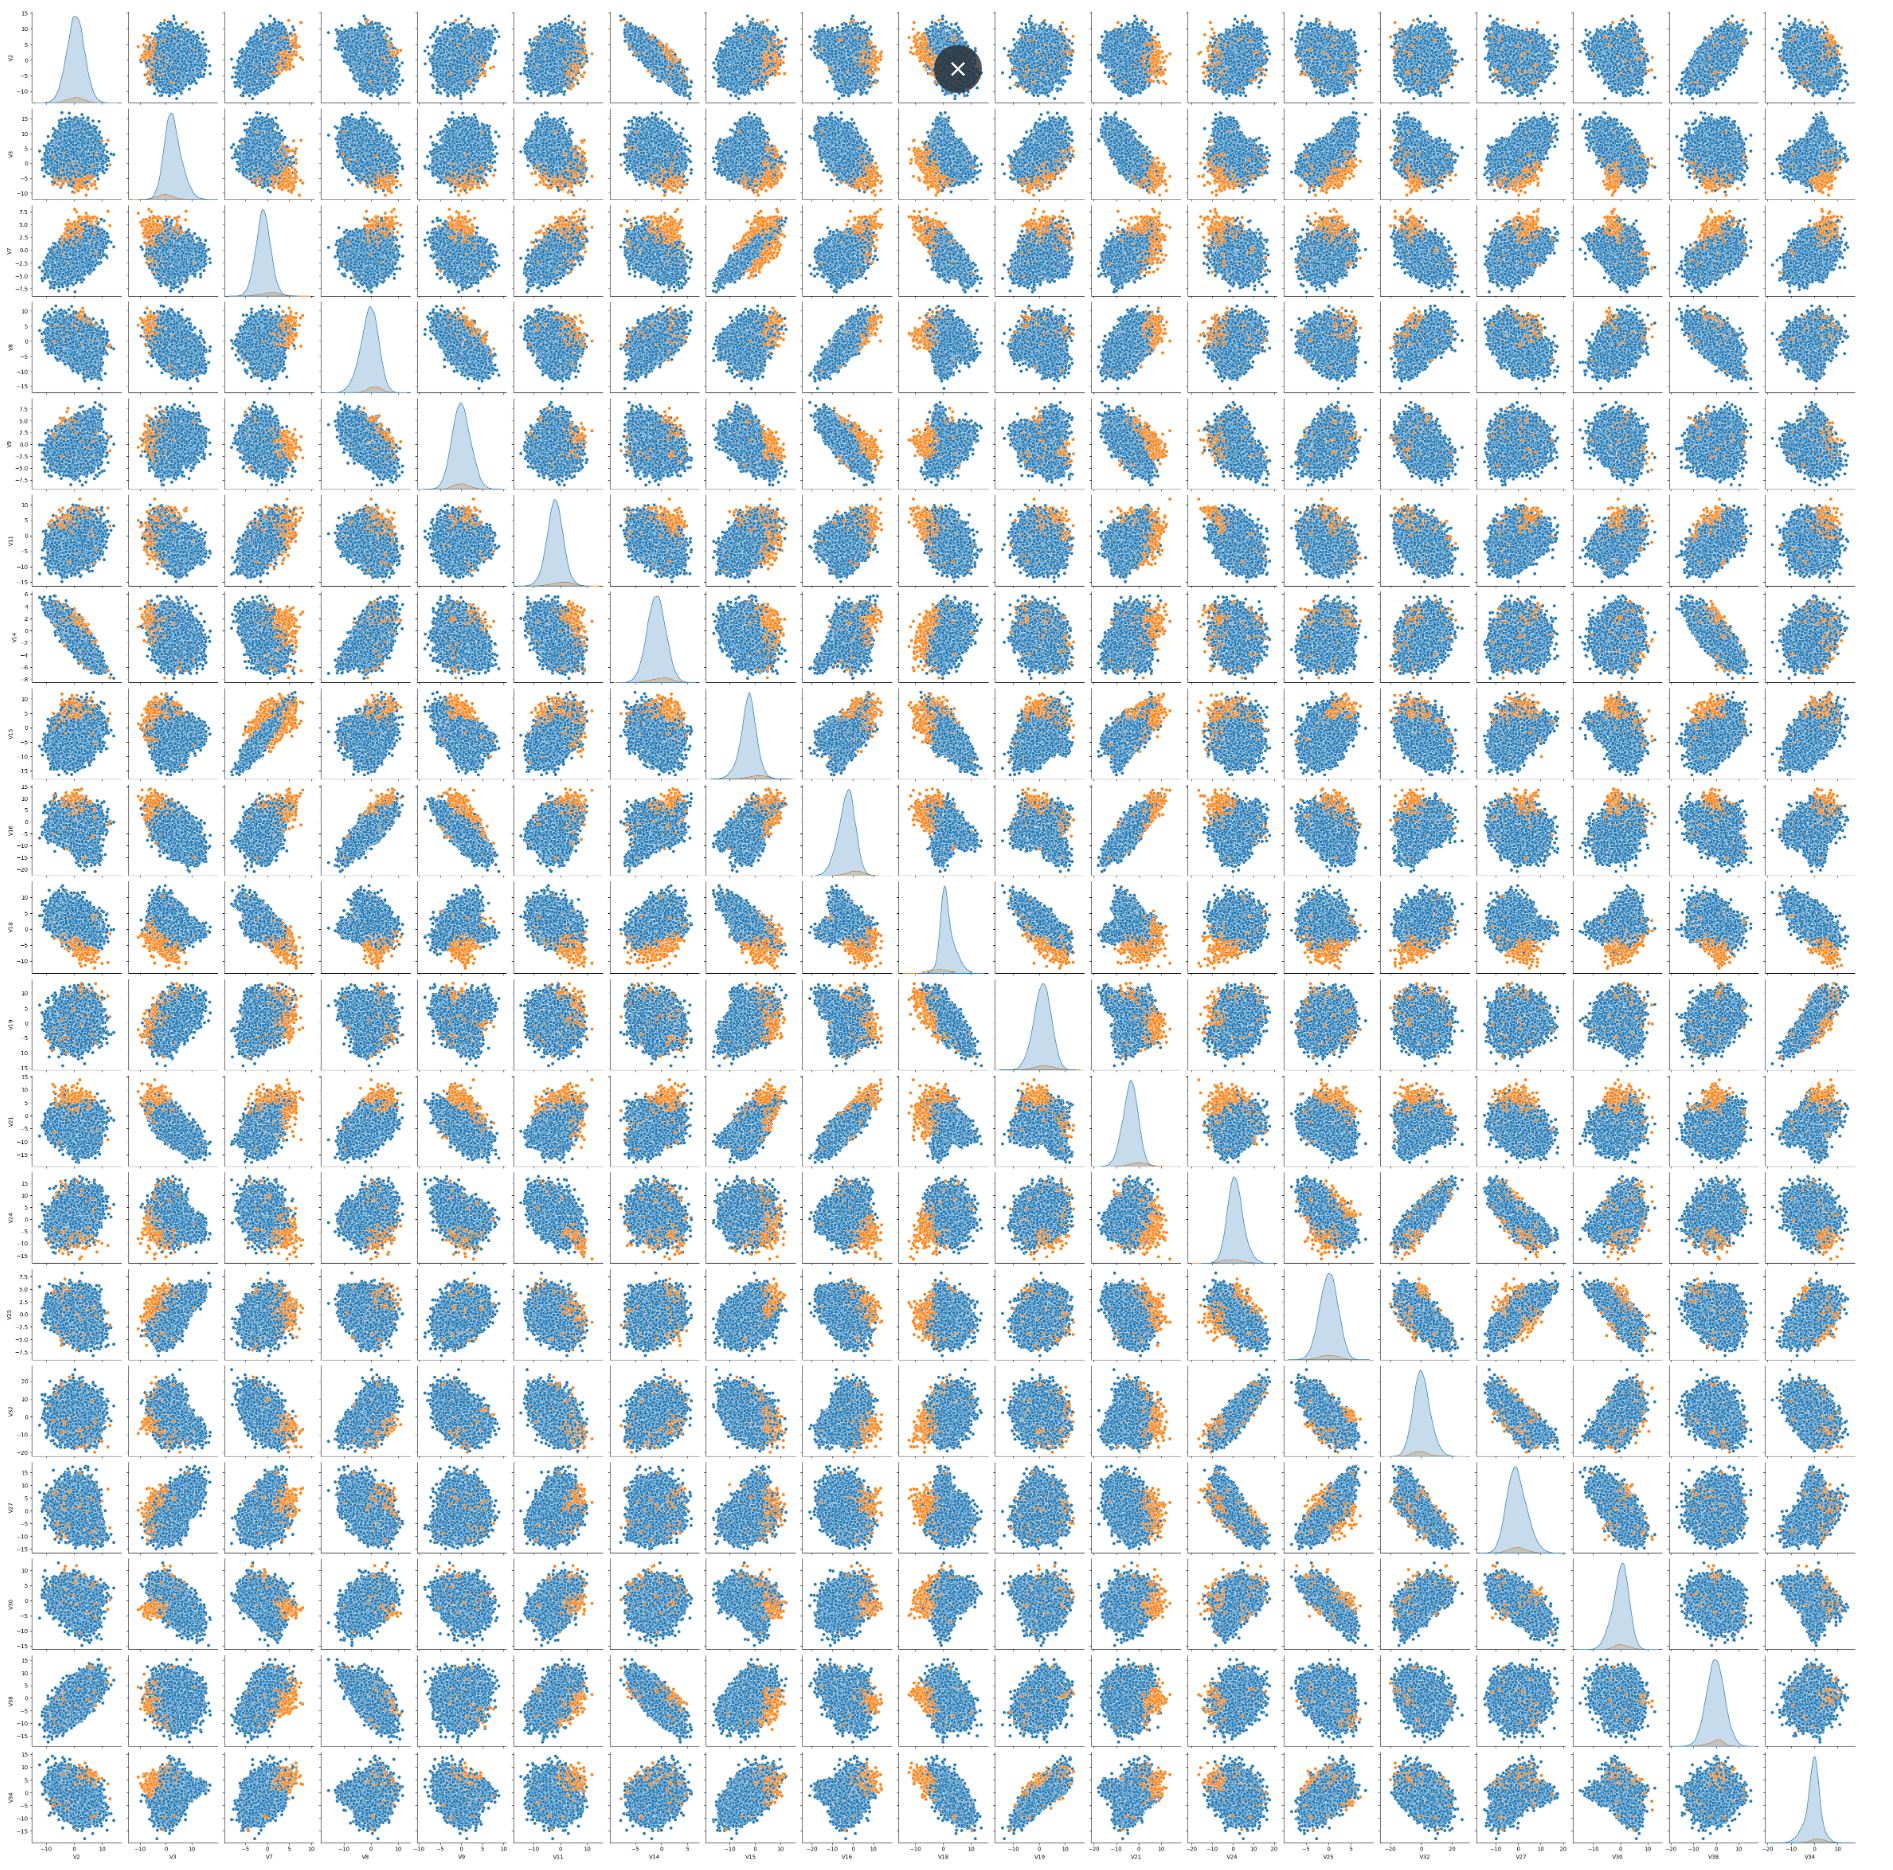

**OBSERVATIONS**

We can observe that some of the V variables have distinctly diagonal plots, indicating strong positive or negative correlations. These confirm the correlations we noted earlier for the various pairs.

## Model Building

Before we can build the model, we need to perform some data processing to prepare the raw data.

We will also define the functions that we'll use later for model building and construction.

Before we begin, let's revisit the goal of this project:

**GOAL: Predict generator failures in order to minimize overall maintenance costs through proactive inspections or repairs vs. full replacements.**

Null Hypothesis:

* H<sub>0</sub>: No features have an impact on generator failure.

Alternative Hypothesis:

* H<sub>A</sub>: One or more features have an impact on generator failure.


###Evaluation Criterion

The goal of our model is to identify which variables most accurately predict generator failures, and produce a tuned model that can most accurately predict the most expensive failures.

* **False negatives (FN)** - The failure occurred, but was not predicted.
  * The company will spend money replacing the generator.
  * This results in the highest cost, and is the least desirable outcome.

* **True positives (TP):**  - The failure was predicted accurately, and the company must spend money on repairs.
  * This results in a moderate cost, but less than a full replacement.
  * While accurate, this doesn't further the goal of missing predictions.

* **False positives (FP)** - The model predicted a failure, but none occurred
  * The company will spend money on inspections.
  * This results in the lowest cost.


###Model Helpers

For efficiency, let's define some useful functions to apply throughout model building.

In [ ]:
# Libraries to build linear model for statistical analysis and prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# Libraries to aid in scoring
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score

# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from xgboost import XGBClassifier

# Libraries for ensemble modeling (stacking)
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
  )


# Libraries for model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso


# Other helpful libraries
import math
from itertools import product
from collections import Counter

In [ ]:
# Function to compute metrics to check performance of a classification model built using sklearn
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    '''
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            'Accuracy': acc,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    '''
    Function to plot a confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''
    # Predict using independent variables
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)

    labels = np.asarray(
        [
            ['{0:0.0f}'.format(item) + '\n{0:.2%}'.format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt='')
    plt.ylabel('True')
    plt.xlabel('Predicted')

In [ ]:
# Function to show number of rows and columns
def print_dataframe_shape(df_name, df):
    '''
    Function to print number of rows and columns
    '''

    print(f'Number of rows and columns for {df_name}:')
    print(df.shape)

### Scorer Selection

Next, we want to define which type of scorer to use for cross-validation and hyperparameter tuning. But, how should we decide which metrics to target?

As noted in the project: *It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.*

Based on this, and the fact that the model should excel at prevening False Negatives (highest cost implication), we should maximize **Recall**.

Recall seeks to minimize false negatives by predicting which generators will fail. Then, they can be inspected or repaired ahead of full replacement, for less cost than a full replacement.

Next, let's specify Recall as our **scorer** metric during cross-validation and hyperparameter tuning.

In [ ]:
# Initiate scorer
scorer = metrics.make_scorer(metrics.recall_score)

### Data Pre-processing

Before generating any models, we need to perform data cleanup.

We know at this point that all of our features are numerical and are nearly all unique values. We will not need to perform one-hot encoding or dummy variable creation as part of feature engineering.

Our *target* variable is an integer and is represented as 0 (No Failure) or 1 (Failure). This will become our y variable.

Next, we will follow these steps to complete our preprocessing:
* Copy the dataset
* Create train, validation and test datasets
* Address missing / NaN values
* Impute any values as needed

In [ ]:
# Create a copy of the original datasets
# These were already split up for us.
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()

In [ ]:
# Revisit counts of each existing dataset
print_dataframe_shape('df_train', df_train)
print_dataframe_shape('df_test', df_test)

Number of rows and columns for df_train:
(20000, 41)
Number of rows and columns for df_test:
(5000, 41)


In [ ]:
# Drop the target variable from the raw datasets

# Training data
X_train_raw = df_train.drop(['Target'], axis=1)
y_train_raw = df_train['Target']

# Test data
X_test_raw = df_test.drop(['Target'], axis=1)
y_test_raw = df_test['Target']

In [ ]:
# Split the training dataset into two: training and validation sets, with a 70/30 split
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_raw, test_size=0.25, random_state=1, stratify=y_train_raw
  )

# New test datasets we'll use for our models, based on the original raw data
X_test = X_test_raw
y_test = y_test_raw

# New train and validation data
print_dataframe_shape('X_train', X_train)
print_dataframe_shape('y_train', y_train)

print_dataframe_shape('X_validation', X_validation)
print_dataframe_shape('y_validation', y_validation)

# Original test data
print_dataframe_shape('X_test', X_test)
print_dataframe_shape('y_test', y_test)


Number of rows and columns for X_train:
(15000, 40)
Number of rows and columns for y_train:
(15000,)
Number of rows and columns for X_validation:
(5000, 40)
Number of rows and columns for y_validation:
(5000,)
Number of rows and columns for X_test:
(5000, 40)
Number of rows and columns for y_test:
(5000,)


####Impute Missing Values (NaN)**

In [ ]:
# Find nulls in validation data
for col in X_validation.columns:
  if X_validation[col].isnull().sum() > 0:
      print('Missing value count for',col,':', X_validation[col].isnull().sum())
      print('   Min:', X_validation[col].min())
      print('   Max:', X_validation[col].max())
      print('   Range:', X_validation[col].max()-X_validation[col].min())
      print('   Mean:', X_validation[col].mean())
      print('   Median:', X_validation[col].median())

Missing value count for V1 : 3
   Min: -11.87645069
   Max: 15.49300222
   Range: 27.36945291
   Mean: -0.22887998734900936
   Median: -0.707505303
Missing value count for V2 : 4
   Min: -10.46760681
   Max: 11.71257436
   Range: 22.180181169999997
   Mean: 0.4393718537067655
   Median: 0.480740976


In [ ]:
# Find nulls in test data
for col in X_test.columns:
  if X_test[col].isnull().sum() > 0:
      print('Missing value count for',col,':', X_test[col].isnull().sum())
      print('   Min:', X_test[col].min())
      print('   Max:', X_test[col].max())
      print('   Range:', X_test[col].max()-X_test[col].min())
      print('   Mean:', X_test[col].mean())
      print('   Median:', X_test[col].median())

Missing value count for V1 : 5
   Min: -12.38169567
   Max: 13.50435159
   Range: 25.886047259999998
   Mean: -0.2776216101771772
   Median: -0.764766844
Missing value count for V2 : 6
   Min: -10.71617927
   Max: 14.07907276
   Range: 24.79525203
   Mean: 0.3979275522226672
   Median: 0.4273690785


We need to address nulls / NaN for series V1 and V2.

Since we know that all of our features are numerical, we can use the *SimpleImputer* function to train each dataset during model fitting. This will prevent data leakage.

Because we don't have any categorical values, we will not need to generate any dummy variables.

In [ ]:
# Instantiate SimpleImputer for imputing the missing values with the media
# Paulo recommends we should impute first, then do SMOTE.
imp_mode = SimpleImputer(missing_values=pd.NA, strategy='median')

In [ ]:
# Use  the SimpleImputer to transform each data set and fill in missing values with the media (50% quartile) value
X_train[:] = imp_mode.fit_transform(X_train[:])
X_validation[:] = imp_mode.transform(X_validation[:])
X_test[:] = imp_mode.transform(X_test[:])

In [ ]:
# Re-check for nulls
j = 0

# Find nulls in training data
for col in X_train.columns:
  if X_train[col].isnull().sum() > 0:
      print('Training: Missing value count for',col,':', X_train[col].isnull().sum())
      j = X_train[col].isnull().sum()

# Find nulls in validation data
for col in X_validation.columns:
  if X_validation[col].isnull().sum() > 0:
      print('Validation: Missing value count for',col,':', X_validation[col].isnull().sum())
      j = j + X_validation[col].isnull().sum()

# Find nulls in test data
for col in X_test.columns:
  if X_test[col].isnull().sum() > 0:
      print('Missing value count for',col,':', X_test[col].isnull().sum())
      j = j + X_test[col].isnull().sum()
print(f'Finished checking datasets. {j} NaN values found.')

Finished checking datasets. 0 NaN values found.


#### Handle Outliers

Earlier, we detected that we don't have a lot of outliers and that most of our data is fairly normally distributed. We also do not have any business context of the various encoded V* variables.

For these reasons, we will not remove any outliers.

#### Feature Engineering

This dataset has a lot of variables. High imensionality will impact our modeling. Normally, we should reduce variables that don't have impact on our target variable. But in this case, the variables are encoded and we do not have context. Therefore it would be risky to remove any of the data.

That said, earlier using corr(), we found that three variables have measurable impact on our target variable:

* V15
* V18
* V21

While the other V* series have some cross-impact, they have little to no correlation with generator failure.

Once we create our final model, we will evaluate feature importance as a whole so that we can assess which ones actually impact our model. In future runs, we could perhaps use that information and discuss with the business the possibility of removing some of the variables from our analysis.

No other good candidates exist for feature engineering, as this is a dataset of abstract, numerical values. We do not need to generate dummy variables or convert categorical variables to measurable numeric ones.

### Model: Run 0 - Raw Data

Now that our dataset has been split and cleaned, we can start model generation.

The goal of our model is to identify which variables most accurately predict generator failures, and produce a tuned model that can most accurately predict the most expensive failures.

Let's run a performance check on the model prior to any tuning.
We will also store the results so we can reference the improvements later.


In [ ]:
# Initiate dictionary to store model names
model_0_dict = {}

# Appending models into the dictionary
model_0_dict = {'0_Bagging' : BaggingClassifier(random_state=1)
               ,'0_RandomForest' : RandomForestClassifier(random_state=1)
               ,'0_GradientBoost' : GradientBoostingClassifier(random_state=1)
               ,'0_AdaBoost' : AdaBoostClassifier(random_state=1)
               ,'0_XGBoost' :  XGBClassifier(random_state=1, eval_metric='logloss')
               ,'0_DecisionTree' : DecisionTreeClassifier(random_state=1)
               ,'0_LogisticRegression' : LogisticRegression(random_state=1)
               }

In [ ]:
# Train each of the models in our model list

# Time the run
%%time

# Create empty lists to store names and results for Run 0
models_0 = model_0_dict.items()
names_0 = []
results_0 = []

print('\nModel Run 0: Cross-Validation performance on training data:')

# Loop through mode list to calculate mean cross validation scores
for name, model in models_0:
    kfold = StratifiedKFold(
          n_splits=5
        , shuffle=True
        , random_state=1
    )
    cv_result = cross_val_score(
          estimator=model
        , X=X_train
        , y=y_train
        , scoring = scorer
        ,cv=kfold
    )
    results_0.append(cv_result)
    names_0.append(name)
    print('{}: {}'.format(name, cv_result.mean()))

print('\nModel Run 0: Performance on validation data:')

for name, model in models_0:
    model.fit(X_train, y_train)
    scores = recall_score(y_validation, model.predict(X_validation))
    print('{}: {}'.format(name, scores))


Cross-Validation performance on training data
model_0_Bagging: 0.7210807301060529
model_0_RandomForest: 0.7235192266070268
model_0_GradientBoost: 0.7066661857008874
model_0_AdaBoost: 0.6309140754635308
model_0_XGBoost: 0.8100497799581561
model_0_DecisionTree: 0.6982829521679532
model_1_LogisticRegression: 0.4927566553639709

Validation Performance:

model_0_Bagging: 0.7302158273381295
model_0_RandomForest: 0.7266187050359713
model_0_GradientBoost: 0.7230215827338129
model_0_AdaBoost: 0.6762589928057554
model_0_XGBoost: 0.8309352517985612
model_0_DecisionTree: 0.7050359712230215
model_1_LogisticRegression: 0.48201438848920863
CPU times: user 7min 50s, sys: 1.33 s, total: 7min 51s
Wall time: 9min 24s


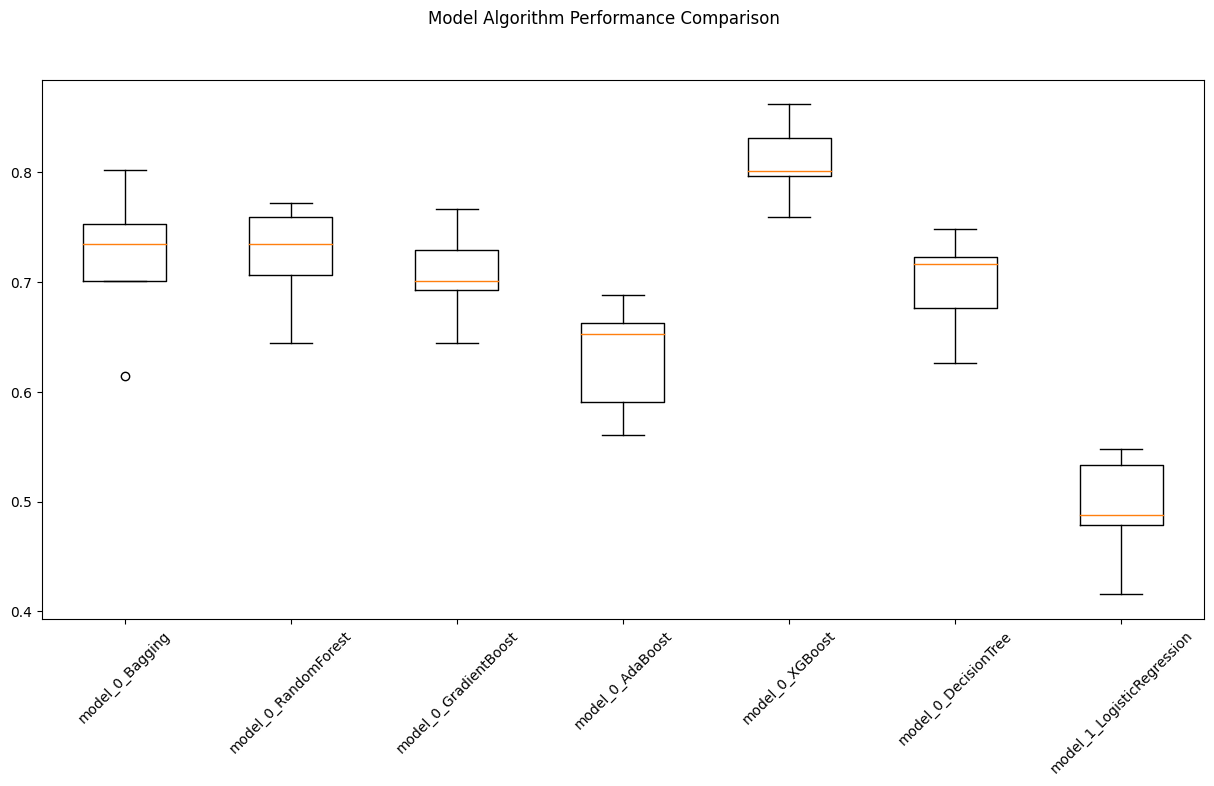

In [ ]:
# Plotting boxplots for CV scores for Run 0
fig = plt.figure(figsize=(15, 7))
fig.suptitle("Model Run 0: Algorithm Performance Comparison")
ax = fig.add_subplot(1, 1, 1)
plt.boxplot(results_0)
ax.set_xticklabels(names_0)
plt.xticks(rotation=45)
plt.show()

#### Model Performance - Raw Data

We trained the raw data using seven different training algoritms. In the fitted result, neither AdaBoost nor Logistic Ridge Regression performed well, but the other models show promise and all exceed 70% Recall.

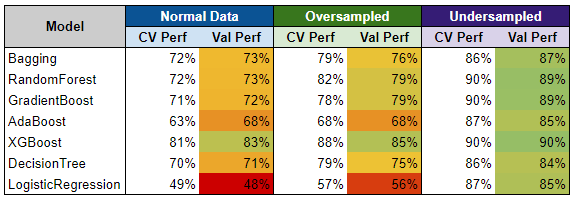


Best Performing Models:

* Training: XGBoost achieved the highest score with 0.810.
* Validation: XGBoost also led with a score of 0.831.
* The next best performing model was Bagging, at .730.
* The worst performing model was Logistic Regression.

Overall Performance:

Training (Sorted from highest to lowest):
* XGBoost: 0.810
* RandomForest: 0.724
* Bagging: 0.721
* GradientBoost: 0.707
* DecisionTree: 0.698
* AdaBoost: 0.631
* LogisticRegression: 0.493

Validation (Sorted from highest to lowest):
* XGBoost: 0.831
* Bagging: 0.730
* RandomForest: 0.727
* GradientBoost: 0.723
* DecisionTree: 0.705
* AdaBoost: 0.676
* LogisticRegression: 0.482

####Model Data Balancing

In checking for class imbalance next, we can see that our minority class is underrepresented. Ideally, we will have at least a 10% minority to majority ratio.

In [ ]:
# Check class imbalance for training, validation and test data

print('*********************************')
print('Target ratio: y_train')
print(y_train.value_counts(1))
print('*********************************')
print('Target ratio: y_validation')
print(y_validation.value_counts(1))
print('*********************************')
print('Target ratio: y_test')
print(y_test.value_counts(1))


*********************************
Target ratio: y_train
Target
0    0.944533
1    0.055467
Name: proportion, dtype: float64
*********************************
Target ratio: y_validation
Target
0    0.9444
1    0.0556
Name: proportion, dtype: float64
*********************************
Target ratio: y_test
Target
0    0.9436
1    0.0564
Name: proportion, dtype: float64


####Oversample Data

Since undersampling the majority class would result in losing quite a bit of information, we will use oversampling to obtain at least a 10/1 ratio of majority to minority class counts for each target value.

SMOTE (Synthetic Minority Oversampling Technique) will help us accomplish this by generating synthetic values based on neighboring samples.


In [ ]:
# Check the distribution of classes
class_distribution = Counter(y_train)
print(class_distribution)

Counter({0: 14168, 1: 832})


In [ ]:
# Check unique class labels
unique_classes = np.unique(y_train)
print(f'Unique classes in y_train: {unique_classes}')


Unique classes in y_train: [0 1]


In [ ]:
# Apply Synthetic Minority Over Sampling Technique to raise class balance to 10%

# Define ratio
desired_ratio = 0.1  # 10% of the total dataset; we are at 5% now.

# Initialize and apply SMOTE with the desired ratio
sm_train = SMOTE(sampling_strategy=desired_ratio
            , k_neighbors=5
            , random_state=1
            )

# Apply SMOTE to resample training data
X_train_over, y_train_over = sm_train.fit_resample(X_train, y_train)

# Fit model
X_train_over, y_train_over = sm_train.fit_resample(X_train, y_train)

# Check new class distribution
print('New class distribution:', Counter(y_train_over))

New class distribution: Counter({0: 14168, 1: 1416})


In [ ]:
print("Pre-OverSampling, y_train = '1': {}".format(sum(y_train == 1)))
print("Pre-OverSampling, y_train = '0': {} \n".format(sum(y_train == 0)))

print("Post-OverSampling, y_train = '1': {}".format(sum(y_train_over == 1)))
print("Post-OverSampling, y_train = '0': {} \n".format(sum(y_train_over == 0)))

print_dataframe_shape('New X_train', X_train_over)
print_dataframe_shape('New y_train', y_train_over)


Pre-OverSampling, y_train = '1': 832
Pre-OverSampling, y_train = '0': 14168 

Post-OverSampling, y_train = '1': 1416
Post-OverSampling, y_train = '0': 14168 

Number of rows and columns for New X_train:
(15584, 40)
Number of rows and columns for New y_train:
(15584,)


####Undersampled Data

Let's also try under sampling to obtain at least a 10/1 ratio of majority to minority class counts for each target value.

RandomUnderSampler() will help us accomplish this by expanding the impact of the minority class by dropping majority samples.

In [ ]:
# Apply undersampling

random_us = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = random_us.fit_resample(X_train, y_train)

# Check new class distribution
print('New class distribution:', Counter(y_train_over))

New class distribution: Counter({0: 14168, 1: 1416})


In [ ]:
print("Pre-Undersampling, y_train = '1': {}".format(sum(y_train == 1)))
print("Pre-Undersampling, y_train = '0': {} \n".format(sum(y_train == 0)))

print("Post-Undersampling, y_train = '1': {}".format(sum(y_train_under == 1)))
print("Post-Undersampling, y_train = '0': {} \n".format(sum(y_train_under == 0)))

print_dataframe_shape('New X_train', X_train_under)
print_dataframe_shape('New y_train', y_train_under)


Pre-Undersampling, y_train = '1': 832
Pre-Undersampling, y_train = '0': 14168 

Post-Undersampling, y_train = '1': 832
Post-Undersampling, y_train = '0': 832 

Number of rows and columns for New X_train:
(1664, 40)
Number of rows and columns for New y_train:
(1664,)


### Model Run 1 - Oversampled and Undersampled Data

Let's see how the oversampled and undersampled models performs. To do this, we'll repeat the steps from earlier.

* Train the model.
* Fit the model.
* Use trained model on validation dataset to assess performance.

In [ ]:
# Initiate new dictionary to store model names and dataframe to store trained models
model_1_dict = {}

# Appending models into the dictionary
model_1_dict = {'1_Bagging' : BaggingClassifier(random_state=1)
               ,'1_RandomForest' : RandomForestClassifier(random_state=1)
               ,'1_GradientBoost' : GradientBoostingClassifier(random_state=1)
               ,'1_AdaBoost' : AdaBoostClassifier(random_state=1)
               ,'1_XGBoost' :  XGBClassifier(random_state=1, eval_metric='logloss')
               ,'1_DecisionTree' : DecisionTreeClassifier(random_state=1)
               ,'1_LogisticRegression' : LogisticRegression(random_state=1)
               }

# Check new dictionary
model_1_dict

{'1_Bagging': BaggingClassifier(random_state=1),
 '1_RandomForest': RandomForestClassifier(random_state=1),
 '1_GradientBoost': GradientBoostingClassifier(random_state=1),
 '1_AdaBoost': AdaBoostClassifier(random_state=1),
 '1_XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=1

In [ ]:
# Run model using the oversampled data

# Time the run
%%time

# Create empty lists to store names and results for Run 0
models_1a = model_1_dict.items()
names_1a = []
results_1a = []

print('\nRun 1a: Cross-Validation performance on oversampled training data:')

# Loop through mode list to calculate mean cross validation scores
for name, model in models_1a:
    kfold = StratifiedKFold(
          n_splits=5
        , shuffle=True
        , random_state=1
    )
    cv_result = cross_val_score(
          estimator=model
        , X=X_train_over
        , y=y_train_over
        , scoring = scorer
        ,cv=kfold
    )
    results_1a.append(cv_result)
    names_1a.append(name)
    print('{}: {}'.format(name, cv_result.mean()))

print('\nRun 1a: Performance on validation data:')

for name, model in models_1a:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_validation, model.predict(X_validation))
    print('{}: {}'.format(name, scores))



Run 1a: Cross-Validation performance on oversampled training data:
1_Bagging: 0.7937913701289008
1_RandomForest: 0.8248643806300701
1_GradientBoost: 0.7824963917782313
1_AdaBoost: 0.6786592345592992
1_XGBoost: 0.8778330761956902
1_DecisionTree: 0.7895685064450306
1_LogisticRegression: 0.5712885084357736

Run 1a: Performance on validation data:
1_Bagging: 0.7553956834532374
1_RandomForest: 0.7913669064748201
1_GradientBoost: 0.7913669064748201
1_AdaBoost: 0.6762589928057554
1_XGBoost: 0.8453237410071942
1_DecisionTree: 0.7482014388489209
1_LogisticRegression: 0.564748201438849
CPU times: user 7min 32s, sys: 1.41 s, total: 7min 33s
Wall time: 8min 32s


**OBSERVATIONS**

* For the oversampled Training Data, XGBoost still performs the best in both cross-validation and validation phases, showing strong performance across both the oversampled training and validation datasets.
* Logistic Regression consistently shows the lowest performance among all models, both in cross-validation and validation phases.
* Performance improvements are seen with oversampling, particularly in XGBoost, which shows a notable increase between training and validation.

Best Performing Models (Sorted from highest to lowest):
* XGBoost: 0.878
* RandomForest: 0.825
* Bagging: 0.794
* DecisionTree: 0.790
* GradientBoost: 0.782
* AdaBoost: 0.679
* LogisticRegression: 0.571

Validation Data
Best Performing Models (Sorted from highest to lowest):
* XGBoost: 0.845
* GradientBoost: 0.791
* RandomForest: 0.791
* Bagging: 0.755
* DecisionTree: 0.748
* AdaBoost: 0.676
* LogisticRegression: 0.565


In [ ]:
# Run this again, but using the undersampled data

# Time the run
%%time

# Create empty lists to store names and results for Run 0
models_1b = model_1_dict.items()
names_1b = []
results_1b = []

print('\nRun 1b: Cross-Validation performance on undersampled training data:')

# Loop through mode list to calculate mean cross validation scores
for name, model in models_1b:
    kfold = StratifiedKFold(
          n_splits=5
        , shuffle=True
        , random_state=1
    )
    cv_result = cross_val_score(
          estimator=model
        , X=X_train_under
        , y=y_train_under
        , scoring = scorer
        ,cv=kfold
    )
    results_1b.append(cv_result)
    names_1b.append(name)
    print('{}: {}'.format(name, cv_result.mean()))

print('\nRun 1b: Performance on validation data:')

for name, model in models_1b:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_validation, model.predict(X_validation))
    print('{}: {}'.format(name, scores))


Run 1b: Cross-Validation performance on undersampled training data:
1_Bagging: 0.8641945025611427
1_RandomForest: 0.9038669648654498
1_GradientBoost: 0.8990621167303946
1_AdaBoost: 0.8666113556020489
1_XGBoost: 0.9014717552846114
1_DecisionTree: 0.8617776495202367
1_LogisticRegression: 0.8726138085275232

Run 1b: Performance on validation data:
1_Bagging: 0.8705035971223022
1_RandomForest: 0.8920863309352518
1_GradientBoost: 0.8884892086330936
1_AdaBoost: 0.8489208633093526
1_XGBoost: 0.89568345323741
1_DecisionTree: 0.841726618705036
1_LogisticRegression: 0.8525179856115108
CPU times: user 39 s, sys: 283 ms, total: 39.3 s
Wall time: 36.8 s


**OBSERVATIONS**

Overall, undersampled data generally shows superior performance compared to oversampled data in both cross-validation and validation phases. This indicates that the models trained on undersampled data have better generalization performance.

Best Performance on Training Data:
* Oversampled Data: XGBoost with 0.878
* Undersampled Data: RandomForest with 0.904

Best Performance on Validation Data:
* Oversampled Data: XGBoost with 0.845
* Undersampled Data: XGBoost with 0.896

Best Performing Models on Training data (Sorted from highest to lowest):
* XGBoost: 0.901
* RandomForest: 0.904
* GradientBoost: 0.899
* AdaBoost: 0.867
* Bagging: 0.864
* LogisticRegression: 0.873
* DecisionTree: 0.862

Best Performing Models on validation data (Sorted from highest to lowest):
* XGBoost: 0.896
* RandomForest: 0.892
* GradientBoost: 0.888
* Bagging: 0.871
* AdaBoost: 0.849
* LogisticRegression: 0.853
* DecisionTree: 0.842

####Model Performance Comparisons


Through a round of modeling, and two follow-up runs using oversampled and undersampled data, we were able to identify candidate models. Clearly, training with undersampled data resulted in superior validation, while the oversampled data improved each validation performance score by a few percentage points.

**Top Performers**
* XGBoost consistently performed well across all datasets, especially in the undersampled data.
* Random Forest and Gradient Boost showed strong results in the undersampled dataset, indicating their robustness with balanced data.

**Normal Training Data**

* XGBoost achieved the highest performance with a CV score of 81% and a Validation score of 83%.
* Bagging and Random Forest performed similarly with CV scores of 72% and Validation scores of 73%.
* Logistic Regression had the lowest performance with CV and Validation scores of 49% and 48%, respectively.

**Oversampled Training Data**

* XGBoost again led with CV of 88% and Validation of 85%.
* Random Forest followed closely with CV of 82% and Validation of 79%.
* AdaBoost showed modest performance with CV and Validation scores of 68%.

**Undersampled Training Data**

* Random Forest achieved the highest performance with a CV score of 90% and a Validation score of 89%.
* XGBoost and Gradient Boost also performed well, both with CV scores of 90% and Validation scores of 90% and 89%, respectively.
* Logistic Regression maintained moderate performance with CV of 87% and Validation of 85%.


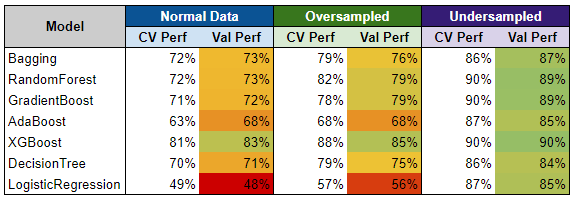

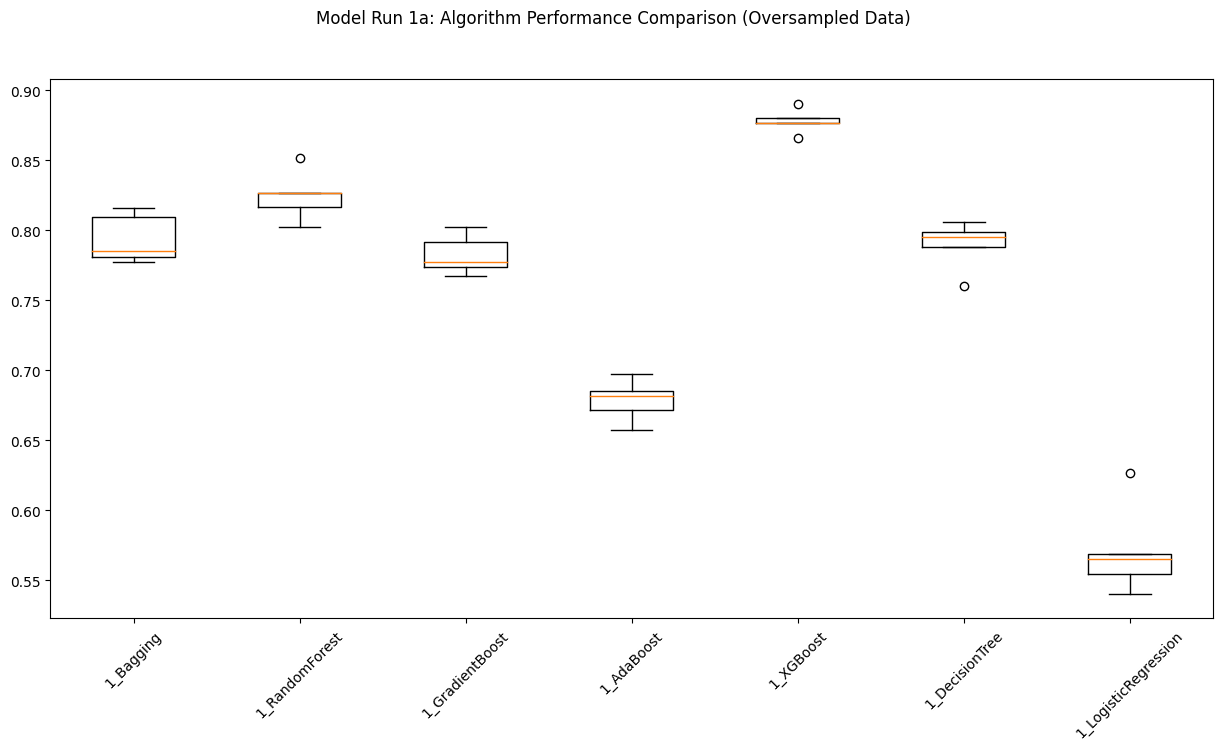

In [ ]:
# Plotting boxplots for CV scores for Run 1a (oversampled data)
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Model Run 1a: Algorithm Performance Comparison (Oversampled Data)')
ax = fig.add_subplot(1, 1, 1)
plt.boxplot(results_1a)
ax.set_xticklabels(names_1a)
plt.xticks(rotation=45)
plt.show()

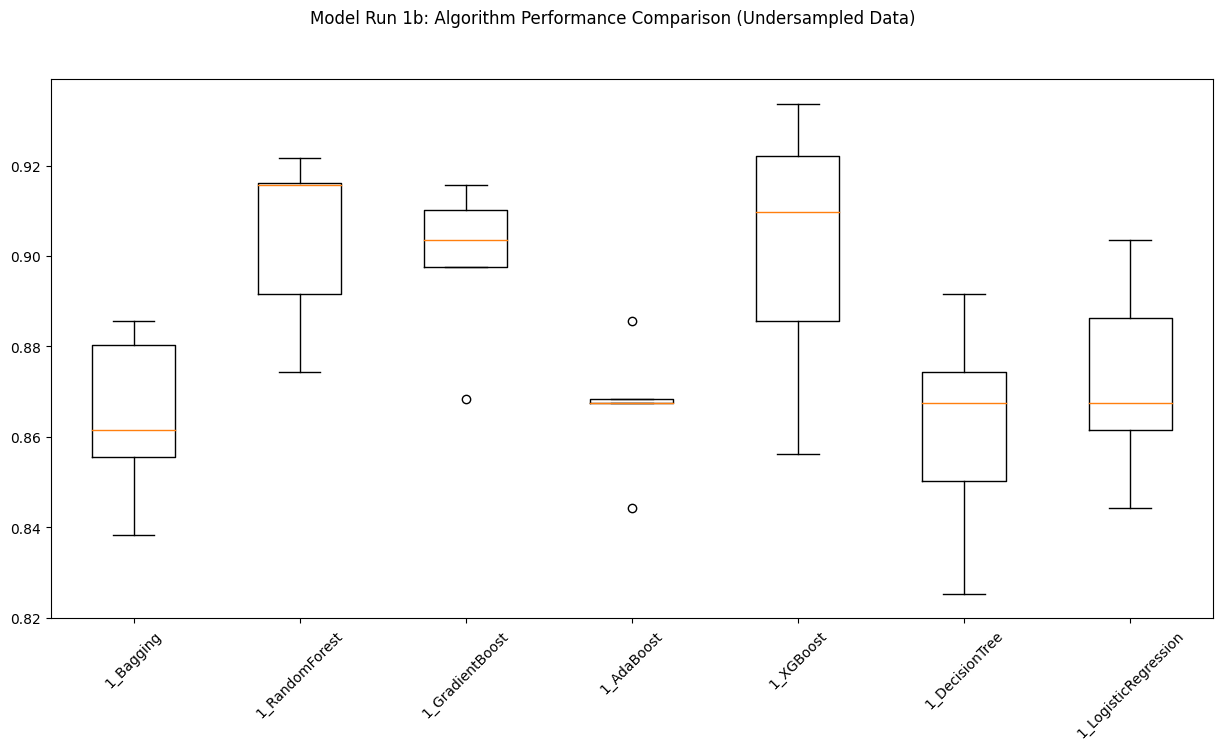

In [ ]:
# Plotting boxplots for CV scores for Run 1b (undersampled data)
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Model Run 1b: Algorithm Performance Comparison (Undersampled Data)')
ax = fig.add_subplot(1, 1, 1)
plt.boxplot(results_1b)
ax.set_xticklabels(names_1b)
plt.xticks(rotation=45)
plt.show()

### Model Run 2 - Hyperparameter Tuning

Based on our initial run with normal, oversampled and undersampled data, we found models with the most promise. We'll train three in particular using the undersampled data.

* **XGBoost**: XGBoost consistently performs well across both training and validation datasets, making it a strong candidate for tuning.

  * Cross-Validation Performance (Undersampled Training Data): 0.901
  * Validation Performance (Undersampled Data): 0.896

* **Random Forest**: RandomForest shows the highest cross-validation score on undersampled data and performs competitively on validation data.

  * Cross-Validation Performance (Undersampled Training Data): 0.904
  * Validation Performance (Undersampled Data): 0.892

* **Gradient Boost**: GradientBoost has strong performance in cross-validation and validation phases, making it a viable model for tuning.

  * Cross-Validation Performance (Undersampled Training Data): 0.899
  * Validation Performance (Undersampled Data): 0.888

We will select these models based on their high performance metrics in both training and validation phases, specifically focusing on their ability to generalize well to unseen data.

Next, let's tune these models to help further with optimizing performance.

#####XG Boost: Tuning

Let's tune the XG Boost model using the recommended hyperparameters provided with the project:

```
param_grid = {
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5, 10],
    'learning_rate': [0.1, 0.2],
    'gamma': [0, 3, 5],
    'subsample': [0.8, 0.9]
}
```




In [ ]:
# Time model building
%%time

# Tuning XGBoost
estimator_xgboost = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of recommended tuning parameters
parameter_grid_xgb = {
    'n_estimators':np.arange(50,110,25), # Reduced due to modeling time
    'scale_pos_weight': [5, 10],
    'learning_rate': [0.1, 0.2],
    'gamma': [0, 3, 5],
    'subsample': [0.8, 0.9]
  }

# Run the Grid CV search
grid_obj_xgboost = GridSearchCV(
      estimator_xgboost,
      parameter_grid_xgb,
      scoring=scorer
      )

# Fit the model to the data, using undersampled data
grid_obj_xgboost = grid_obj_xgboost.fit(X_train_under, y_train_under)

# Set the model to the best combination of parameters
tuned_model_xgboost = grid_obj_xgboost.best_estimator_

# Fit the model to the data using best estimator
tuned_model_xgboost.fit(X_train_under, y_train_under)

# Print out best parameters
print("Best parameters are {} with CV score={}:" .format(grid_obj_xgboost.best_params_, grid_obj_xgboost.best_score_))

Best parameters are {'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 50, 'scale_pos_weight': 10, 'subsample': 0.8} with CV score=0.9338720150061324:
CPU times: user 6min 1s, sys: 1.36 s, total: 6min 2s
Wall time: 3min 53s


In [ ]:
# Calculating metrics on training data
tuned_model_xgboost_train = model_performance_classification_sklearn(
    tuned_model_xgboost, X_train, y_train
)
print('Training performance:')
tuned_model_xgboost_train

Training performance:


Accuracy  Recall  Precision        F1
0  0.827333     1.0   0.243133  0.391161

In [ ]:
# Calculating metrics on validation data
tuned_model_xgboost_val = model_performance_classification_sklearn(
    tuned_model_xgboost, X_validation, y_validation
)
print('Validation performance:')
tuned_model_xgboost_val

Validation performance:


Accuracy    Recall  Precision        F1
0    0.8104  0.917266   0.216102  0.349794

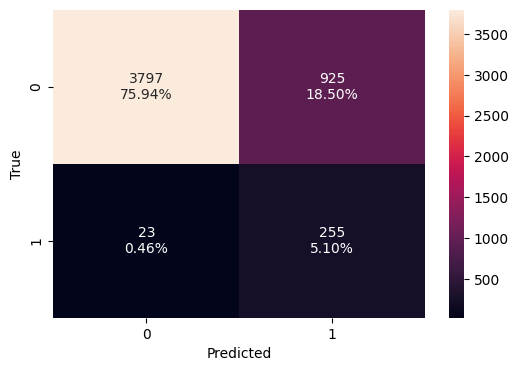

In [ ]:
# creating confusion matrix for predictions
confusion_matrix_sklearn(tuned_model_xgboost, X_validation, y_validation)

#####Random Forest: Tuning

Let's tune the Random Forest model using the recommended hyperparameters provided with the project:

```
param_grid = {
    "n_estimators": [200, 250, 300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1), 'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

```

In [ ]:
# Time model building
%%time

# Tuning Random Forest
estimator_random_forest = RandomForestClassifier(random_state=1)

# Grid of recommended tuning parameters
parameter_grid_rf = {
    'n_estimators': [50,110,25],
    'min_samples_leaf': np.arange(1, 4),
    'max_features': [np.arange(0.3, 0.6, 0.1),'sqrt'],
    'max_samples': np.arange(0.4, 0.7, 0.1),
    'class_weight': [{0: 0.33, 1: 0.66}]
}

# Run the randomized search version to assist with runtime issues
grid_obj_random_forest = GridSearchCV(
      estimator_random_forest,
      parameter_grid_rf,
      scoring=scorer
      )

# Fit the model to the data
grid_obj_random_forest = grid_obj_random_forest.fit(X_train_under, y_train_under)

# Set the model to the best combination of parameters
tuned_model_random_forest = grid_obj_random_forest.best_estimator_

# Fit the model to the data using the best estimator
tuned_model_random_forest.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(grid_obj_random_forest.best_params_, grid_obj_random_forest.best_score_))

Best parameters are {'class_weight': {0: 0.33, 1: 0.66}, 'max_features': 'sqrt', 'max_samples': 0.5, 'min_samples_leaf': 3, 'n_estimators': 50} with CV score=0.9038381069186926:
CPU times: user 51.7 s, sys: 133 ms, total: 51.9 s
Wall time: 52.2 s


In [ ]:
# Calculating metrics on training data
tuned_model_random_forest_train = model_performance_classification_sklearn(
    tuned_model_random_forest, X_train, y_train
)
print('Training performance:')
tuned_model_random_forest_train

Training performance:


Accuracy    Recall  Precision        F1
0  0.922467  0.936298   0.412388  0.572584

In [ ]:
# Calculating metrics on validation data
tuned_model_random_forest_val = model_performance_classification_sklearn(
    tuned_model_random_forest, X_validation, y_validation
)
print('Validation performance:')
tuned_model_random_forest_val

Validation performance:


Accuracy    Recall  Precision        F1
0    0.9112  0.881295   0.373476  0.524625

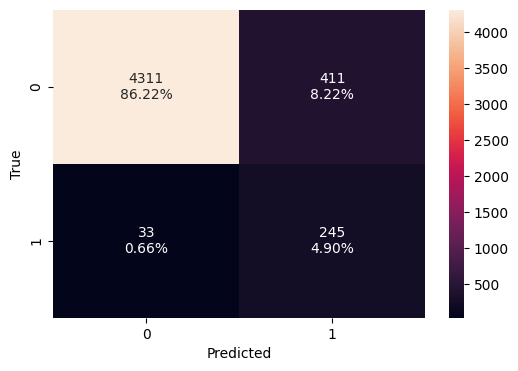

In [ ]:
# creating confusion matrix for predictions
confusion_matrix_sklearn(tuned_model_random_forest, X_validation, y_validation)

#####Gradient Boost: Tuning

Let's perform hyperparameter tuning using the recommended parameters.


```
param_grid = {
    'n_estimators': np.arange(100, 150, 25),
    'learning_rate': [0.2, 0.05, 1],
    'subsample': [0.5, 0.7],
    'max_features': [0.5, 0.7]
}
```




In [ ]:
# Time model building
%%time

# Tuning Gradient Boost
estimator_gradient_boost = GradientBoostingClassifier(random_state=1)

# Grid of recommended tuning parameters
parameter_grid_gb = {
    "n_estimators": np.arange(100, 150, 25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample": [0.5, 0.7],
    "max_features": [0.5, 0.7]
}

# Type of scoring used to compare parameter combinations - we care most about f1
scorer_gb = metrics.make_scorer(metrics.f1_score)

# Run the randomized search, since this is more performant, with modified cv
grid_obj_gradient_boost = GridSearchCV(
      estimator_gradient_boost,
      parameter_grid_gb,
      scoring=scorer_gb
      )

# Fit the model to the data
grid_obj_gradient_boost = grid_obj_gradient_boost.fit(X_train_under, y_train_under)

# Set the model to the best estimator parameters
tuned_model_gradient_boost = grid_obj_gradient_boost.best_estimator_

# Fit the tuned model to the data with best
tuned_model_gradient_boost.fit(X_train_under, y_train_under)

CPU times: user 2min 24s, sys: 154 ms, total: 2min 24s
Wall time: 2min 25s


GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
# Calculating metrics on training data
tuned_model_gradient_boost_train = model_performance_classification_sklearn(
    tuned_model_gradient_boost, X_train, y_train
)
print('Training performance:')
tuned_model_gradient_boost_train

Training performance:


Accuracy    Recall  Precision        F1
0  0.934467  0.977163   0.457513  0.623227

In [ ]:
# Calculating metrics on validation data
tuned_model_gradient_boost_val = model_performance_classification_sklearn(
    tuned_model_gradient_boost, X_validation, y_validation
)
print('Validation performance:')
tuned_model_gradient_boost_val

Validation performance:


Accuracy    Recall  Precision        F1
0    0.9226  0.884892   0.409318  0.559727

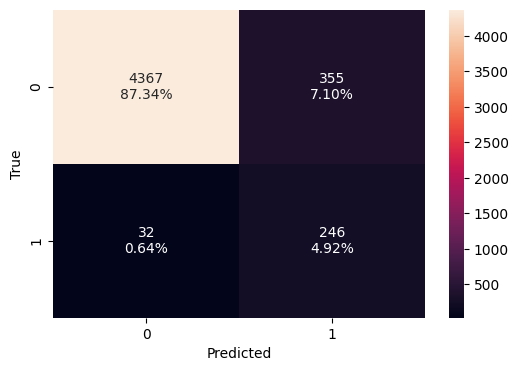

In [ ]:
# creating confusion matrix for predictions
confusion_matrix_sklearn(tuned_model_gradient_boost, X_validation, y_validation)

#### Model Performance Comparisions - Tuned

Tuning this model through undersampling, oversampling and hyperparameters greatly improved performance. Optimizing the model for minimizing False Negatives is critical for imbalanced datasets.

The tuned models demonstrate significantly higher recall values compared to the previous models, indicating improved sensitivity to positive class predictions.

Random Forest and Gradient Boost both show improvement. The Random Forest had an 88% Validation score in the previous results, matching its tuned recall, while Gradient Boost improved from a 79% Validation score to an 88% Recall in the tuned version.

**XGBoost**
* Achieved 100% Recall during training (overfitted), but a 92% Recall on validation data.

**Random Forest**
* Scored 94% Recall on training and 88% Recall on validation.

**Gradient Boost**
* Showed 98% Recall in training and 88% Recall in validation.



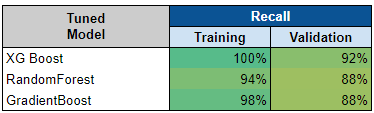


### Final Model - Stacked

Next, let's combine our results to create an ensemble model.

We can choose to either train this model on the same undersampled dataset, or use the normal training data. There are advantages to both approaches, but because we want the model to generalize well, let's first try it on the normal (non-undersampled) training data. We'll also try it on the undersampled data as well.

In [ ]:
# Add the estimators for stacking our final model

# Construct the metamodel
estimators_ensemble = [('XG Boost', tuned_model_xgboost),
                       ('Gradient Boost', tuned_model_gradient_boost),
                       ('Random Forest', tuned_model_random_forest)]

# Construct the metamodel
estimator_ensemble = tuned_model_xgboost

# Construct the stacked models - we will do three, to handle normal, oversampled, and undersampled data
model_ensemble = StackingClassifier(estimators=estimators_ensemble, final_estimator=estimator_ensemble)
model_ensemble_under = StackingClassifier(estimators=estimators_ensemble, final_estimator=estimator_ensemble)
model_ensemble_over = StackingClassifier(estimators=estimators_ensemble, final_estimator=estimator_ensemble)



#### Ensemble Model - Normal Training Data

In [ ]:
# Fit the model to the normal training data
model_ensemble.fit(X_train, y_train)


StackingClassifier(estimators=[('XG Boost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=5,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                                 feature_types=None, gamma=5,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1, ...))

In [ ]:
# Run final model to calculate metrics on normal training data
model_ensemble_train = model_performance_classification_sklearn(
    model_ensemble, X_train, y_train
)
print('Training performance: Normal Training Data')
model_ensemble_train

Training performance: Normal Training Data


Accuracy    Recall  Precision        F1
0    0.9914  0.967548   0.887541  0.925819

In [ ]:
# Run final model to calculate metrics on validation data
model_ensemble_val = model_performance_classification_sklearn(
    model_ensemble, X_validation, y_validation
)
print('Validation performance: ')
model_ensemble_val

Validation performance: 


Accuracy    Recall  Precision        F1
0    0.9804  0.877698   0.792208  0.832765

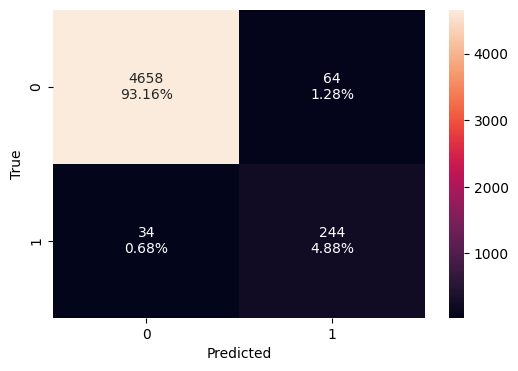

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble, X_validation, y_validation)

#### Ensemble Model - Undersampled Training Data

In [ ]:
# Fit the model to the undersampled training data
model_ensemble_under.fit(X_train_under, y_train_under)


StackingClassifier(estimators=[('XG Boost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=5,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                                 feature_types=None, gamma=5,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1, ...))

In [ ]:
# Run final model to calculate metrics on undersampled training data
model_ensemble_train_under = model_performance_classification_sklearn(
    model_ensemble_under, X_train_under, y_train_under
)
print('Training performance: Undersampled Training Data')
model_ensemble_train_under

Training performance: Undersampled Training Data


Accuracy    Recall  Precision        F1
0  0.926082  0.990385   0.877529  0.930548

In [ ]:
# Run final model to calculate metrics on validation data
model_ensemble_val_under = model_performance_classification_sklearn(
    model_ensemble_under, X_validation, y_validation
)
print('Validation performance: ')
model_ensemble_val_under

Validation performance: 


Accuracy    Recall  Precision        F1
0    0.7632  0.899281   0.177809  0.296912

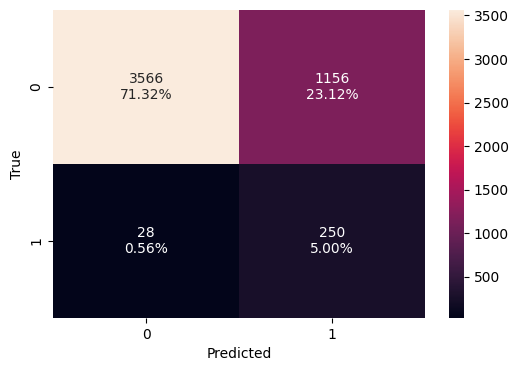

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble_under, X_validation, y_validation)

#### Ensemble Model - Oversampled Training Data

In [ ]:
# Fit the model to the oversampled training data
model_ensemble_over.fit(X_train_over, y_train_over)


StackingClassifier(estimators=[('XG Boost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=5,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                                 feature_types=None, gamma=5,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=50, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=1, ...))

In [ ]:
# Run final model to calculate metrics on oversampled training data
model_ensemble_train_over = model_performance_classification_sklearn(
    model_ensemble_over, X_train_over, y_train_over
)
print('Training performance: Oversampled Training Data')
model_ensemble_train_over

Training performance: Undersampled Training Data


Accuracy    Recall  Precision        F1
0  0.926082  0.990385   0.877529  0.930548

In [ ]:
# Run final model to calculate metrics on validation data
model_ensemble_val_over = model_performance_classification_sklearn(
    model_ensemble_over, X_validation, y_validation
)
print('Validation performance: ')
model_ensemble_val_over

Validation performance: 


Accuracy    Recall  Precision        F1
0    0.7632  0.899281   0.177809  0.296912

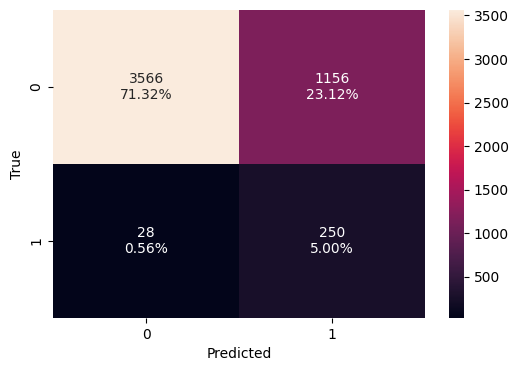

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble_over, X_validation, y_validation)

#### Ensemble Model - Test Data

Now that we are confident in our validation exercise, we are ready to test the model against unseen Test data. Before we can do this, we must pre-process the data to ensure we have no missing values.

Once the data is ready, we'll run our new model against the test dataset to see how well it generalized.

##### Data Preparation - Test Data

In [ ]:
# Drop the target variable from the test dataset
X_test = df_test.drop(['Target'], axis=1)
y_test = df_test['Target']

In [ ]:
#Check the size of the original test data
print_dataframe_shape('X_test', X_test)
print_dataframe_shape('y_test', y_test)

Number of rows and columns for X_test:
(5000, 40)
Number of rows and columns for y_test:
(5000,)


In [ ]:
# Use Imputation to fill in missing values (NaN)
imputer = SimpleImputer(strategy='median')
X_test = imputer.fit_transform(X_test)

In [ ]:
# Drop the target variable from the test dataset
X_test = df_test.drop(['Target'], axis=1)
y_test = df_test['Target']

In [ ]:
#Check the size of the original test data
print_dataframe_shape('X_test', X_test)
print_dataframe_shape('y_test', y_test)

Number of rows and columns for X_test:
(5000, 40)
Number of rows and columns for y_test:
(5000,)


In [ ]:
# Use Imputation to fill in missing values (NaN)
imputer = SimpleImputer(strategy='median')
X_test = imputer.fit_transform(X_test)

In [ ]:
# Run final model to calculate metrics on test data - use normal ensemble model
model_ensemble_test = model_performance_classification_sklearn(
    model_ensemble, X_test, y_test
)
print('Test performance: Model with Normal Data')
model_ensemble_test

Test performance: Model with Normal Data


Accuracy    Recall  Precision        F1
0    0.9808  0.861702       0.81  0.835052

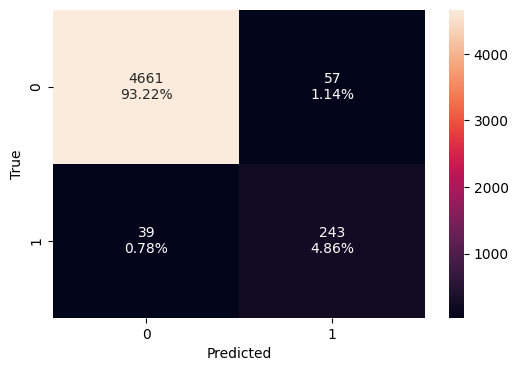

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble, X_test, y_test)

In [ ]:
# Run final model to calculate metrics on test data - use undersampled ensemble model
model_ensemble_test_under = model_performance_classification_sklearn(
    model_ensemble_under, X_test, y_test
)
print('Test performance: Model with Undersampled Data')
model_ensemble_test_under

Test performance: Model with Undersampled Data


Accuracy    Recall  Precision        F1
0     0.766  0.904255   0.182403  0.303571

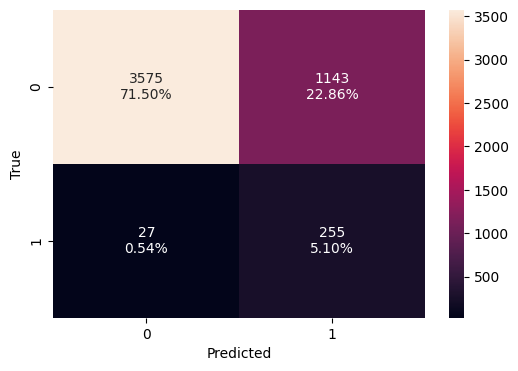

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble_under, X_test, y_test)

In [ ]:
# Run final model to calculate metrics on test data - use oversampled ensemble model
model_ensemble_test_over = model_performance_classification_sklearn(
    model_ensemble_over, X_test, y_test
)
print('Test performance: Model with Oversampled Data')
model_ensemble_test_over

Test performance: Model with Oversampled Data


Accuracy    Recall  Precision        F1
0     0.974  0.868794   0.724852  0.790323

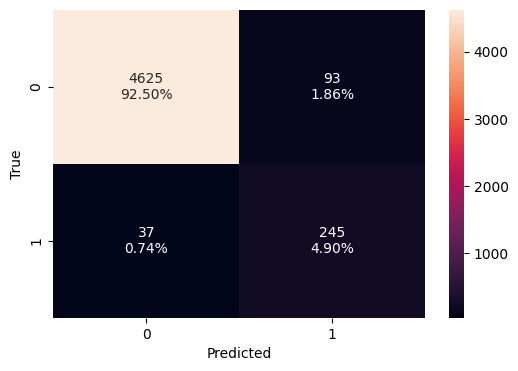

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(model_ensemble_over, X_test, y_test)

##### Model Performance Comparison - Test

**Recall:**The undersampled model yielded the highest Recall (0.9043), indicating it is best at identifying true positives and minimizes false negatives, though it suffers from low precision.

**Accuracy**: The normal data model achieves the highest accuracy (0.9808), suggesting it performs well overall, but with slightly lower recall than the undersampled model.

**Balance**: The oversampled model maintains a good balance between recall (0.8688) and precision (0.7249), making it a strong contender for practical applications.

The undersampled model excels in recall, although the normal and oversampled models provide better overall performance metrics. Since we care *most* about minimizing False Negatives, we will move forward with the undersampled dataset.

#### Feature Importance

The following bar chart illustrates relative feature importance with regard to generator failure. These results are further summarized in our Insights.

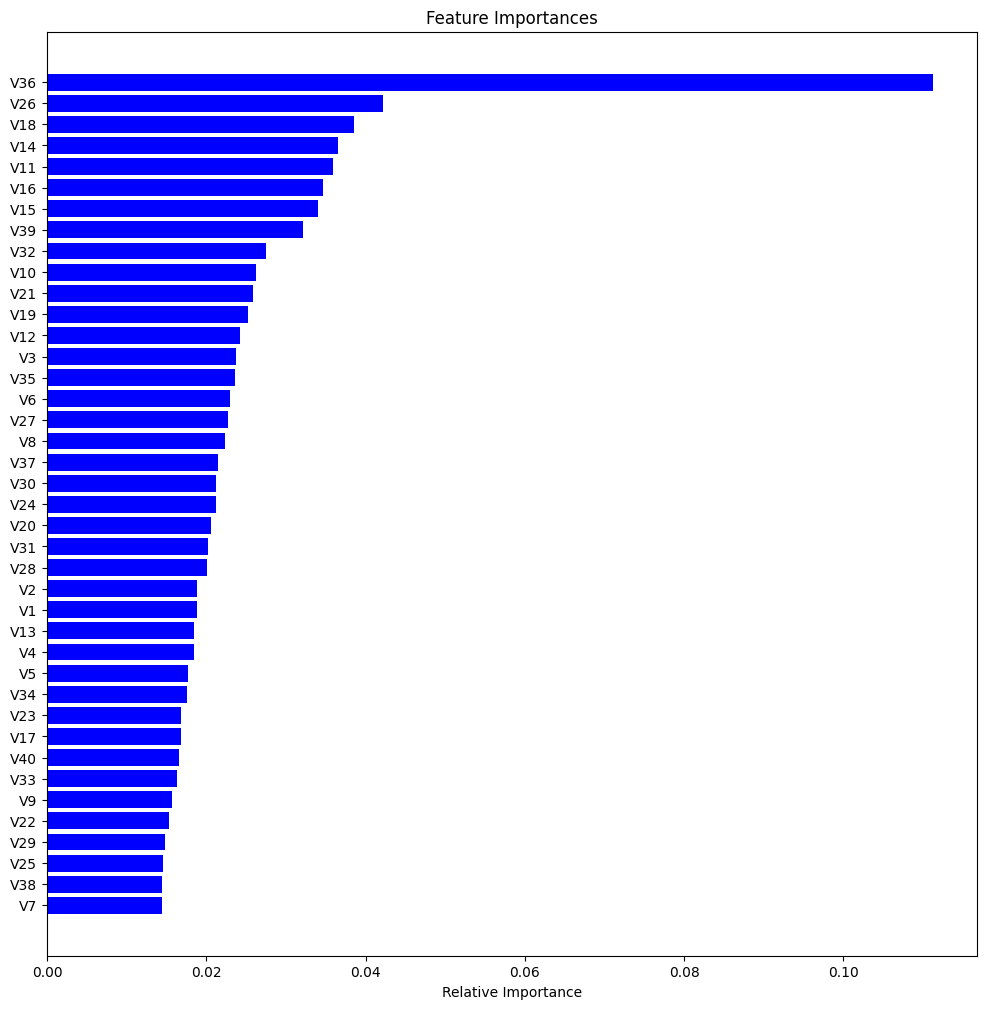

In [ ]:
# List out feature importance based on final XGBoost model (the stacked model classifiers do not support feature importance)
feature_names = X_train.columns
importances =  tuned_model_xgboost.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Print these as values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

Feature  Importance
35     V36    0.111211
25     V26    0.042192
17     V18    0.038492
13     V14    0.036565
10     V11    0.035884
15     V16    0.034713
14     V15    0.034042
38     V39    0.032091
31     V32    0.027499
9      V10    0.026261
20     V21    0.025850
18     V19    0.025181
11     V12    0.024176
2       V3    0.023683
34     V35    0.023568
5       V6    0.022950
26     V27    0.022733
7       V8    0.022354
36     V37    0.021502
29     V30    0.021211
23     V24    0.021187
19     V20    0.020541
30     V31    0.020195
27     V28    0.020072
1       V2    0.018881
0       V1    0.018875
12     V13    0.018471
3       V4    0.018413
4       V5    0.017755
33     V34    0.017538
22     V23    0.016810
16     V17    0.016804
39     V40    0.016611
32     V33    0.016368
8       V9    0.015728
21     V22    0.015293
28     V29    0.014828
24     V25    0.014611
37     V38    0.014447
6       V7    0.014415

### Pipeline Construction

Finally, let's construct a reusable pipeline to ensure our model can easily be redeployed into production.

In [ ]:
# Invoke the librariees we need
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline with Stacking
pipeline_stacked = make_pipeline(
    StandardScaler(),     # Preprocessing step
    model_ensemble_under  # Stacked model: Best performing one (trained on undersampled data)
)

In [ ]:
# Fit the pipeline to the training data
pipeline_stacked.fit(X_train_under, y_train_under)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('XG Boost',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric='logloss',
                                                               feature_types=None,
                                                               gamm...
                                                                  gamma=5,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=0.1,
                                                                  max_bin=None,
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=None,
                                                                  max_depth=None,
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=50,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=1, ...)))])

In [ ]:
# Show the pipeline steps
pipeline_stacked.steps

[('standardscaler', StandardScaler()),
 ('stackingclassifier',
  StackingClassifier(estimators=[('XG Boost',
                                  XGBClassifier(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                device=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric='logloss',
                                                feature_types=None, gamma=5,
                                                grow_policy=None,
                                                importance_type=None,
                                       

In [ ]:
# Run final model to calculate metrics on training data
pipeline_stacked_train_under = model_performance_classification_sklearn(
    pipeline_stacked, X_train_under, y_train_under
)
print('Training performance:')
pipeline_stacked_train_under

Training performance:


Accuracy    Recall  Precision        F1
0  0.926082  0.990385   0.877529  0.930548

In [ ]:
# Run final model to calculate metrics on val data
pipeline_stacked_val = model_performance_classification_sklearn(
    pipeline_stacked, X_validation, y_validation
)
print('Validation performance:')
pipeline_stacked_val

Validation performance:


Accuracy    Recall  Precision        F1
0    0.7632  0.899281   0.177809  0.296912

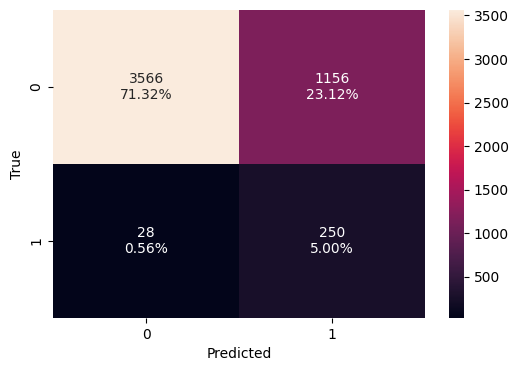

In [ ]:
# Create confusion matrix for predictions
confusion_matrix_sklearn(pipeline_stacked, X_validation, y_validation)

In [ ]:
# Run final model to calculate metrics on test data
pipeline_stacked_test = model_performance_classification_sklearn(
    pipeline_stacked, X_test, y_test
)
print('Test performance:')
pipeline_stacked_test

Test performance:


Accuracy    Recall  Precision        F1
0     0.766  0.904255   0.182403  0.303571

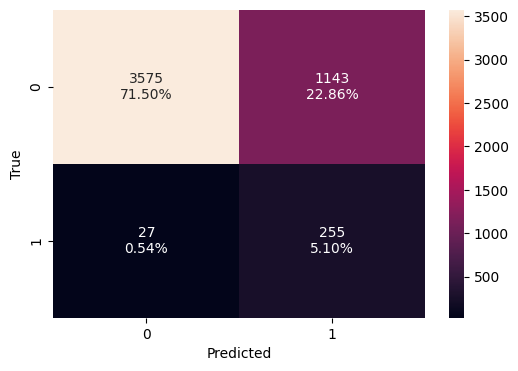

In [ ]:
# Create confusion matrix for predictions - test data
confusion_matrix_sklearn(pipeline_stacked, X_test, y_test)

# Business Insights and Conclusions

The following section details our findings and recommendations to help  ReneWind address generator failure prediction and monitoring.

### Insights

For our final model, we chose to use an Stacked ensemble mode leveraging the following tuned models. In addition, we trained these models using the undersampled dataset to maximize performance.

* XG Boost
* Random Forest
* Gradient Boost

The final model was tested against normal test data, undersampled test data and oversampled test data. Similar to what we observed during our initial raw model, the undersampled data gave superior Recall performance.

* The final model erroneously predicted generator failure 23% of the time (False Positive rate). In these cases, proactive inspections and/or repairs will be conducted, potentially delaying an actual failure and associated replacement costs.

* The final model correctly predicted failures only 5% of the time. However, since we are seeking to prevent *missed* failure predictions, this is not an important value to maximize for this model. Whether it was predicted or not, the replacement cost still applies.

* The final model correctly predicted no failures 72% of the time, resulting in no costs or resource consumption.

* The final model missed predicting generator failures less than 1% of the time (.54% False Negative rate). While the cost of the failure is a very high replacement cost, few failures should remain undetected in production and these costs should be fairly predictable.


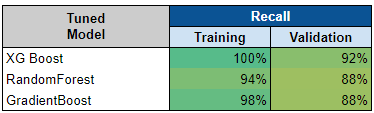

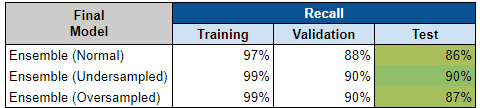

##Recommendations

**Variable Importance**

While we are unable to offer specific insights due to the ciphered nature of the data, we can offer insights into the importance of each, based on our analysis.

Top 25% (Highest Quartile)

* The top features are V36, V26, V18, V14, V11, V16, V15, V39, V32, and V10. These features have the highest importance scores, and therefore contribute the most to generator failures.
  * Special attention or monitoring should be applied to these features.

Middle 50% (Middle Quartiles)
* The middle features range from V21 to V34. These features have moderate importance scores.
  * Monitoring of these variables should continue.

Bottom 25% (Lowest Quartile)
* The bottom features include V23, V17, V40, V33, V9, V22, V29, V25, V38, and V7. These features have the lowest importance scores.
  * Fewer resources can be devoted to monitoring of these features, as they have little to no bearing on generator failures.

**Data**

* The business should add device identifiers to track data specifically against certain generators over their lifetime. If we find that we are correctly predicting multiple inspections and repairs for specific generators, replacement costs can more readily be planned.

* If any of the top 25% of features can be monitored or forecasted, applying engineering effort toward these will yield the highest chance of preventing generator failures.



##Conclusions

The model developed in the notebook generalized well on our test data and should be deployed into production.

After a measurable time in production (12 months minimum), we suggest re-running this analysis to assess actual production model performance. If the undersampled model is not generalizing as well for new unseen production data, we recommend adjusting the pipeine to use the normal dataset instead.

#Export Notebook

In [ ]:
!pip install nbconvert

In [ ]:
# Create an HTML version of this notebook - do this last
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Learning/Data Coursework/PGP-DSBA/6-Model Tuning/Project 6/MT_Project_LearnerNotebook_FullCode.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Learning/Data Coursework/PGP-DSBA/6-Model Tuning/Project 6/MT_Project_LearnerNotebook_FullCode.ipynb to html
[NbConvertApp] Writing 8834268 bytes to /content/drive/MyDrive/Learning/Data Coursework/PGP-DSBA/6-Model Tuning/Project 6/MT_Project_LearnerNotebook_FullCode.html


***